In [1]:
import pandas as pd
df = pd.read_csv('../input/consumercomplaints/complaints.csv')
df.iloc[:,:10].head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX
4,2021-03-02,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33325


In [2]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679285 entries, 0 to 1999963
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 679285 non-null  object
 1   Product                       679285 non-null  object
 2   Sub-product                   627113 non-null  object
 3   Issue                         679285 non-null  object
 4   Sub-issue                     528206 non-null  object
 5   Consumer complaint narrative  679285 non-null  object
 6   Company public response       339012 non-null  object
 7   Company                       679285 non-null  object
 8   State                         675680 non-null  object
 9   ZIP code                      528244 non-null  object
 10  Tags                          111909 non-null  object
 11  Consumer consent provided?    679285 non-null  object
 12  Submitted via                 679285 non-null  object
 13

In [4]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [5]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [6]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [7]:
df['category_id'] = df['Product'].factorize()[0]

In [8]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

# Mapping Dictionaries
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [9]:
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
3,Debt collection,Pioneer has committed several federal violatio...,0
8,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
9,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


In [10]:
import sys
sys.getsizeof(df)/(1024**3)

0.7826486974954605

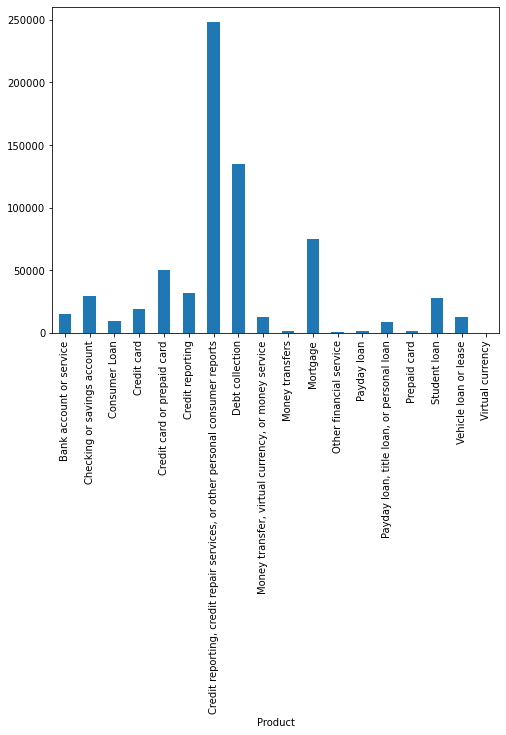

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(679285, 1072423)

In [13]:
import sys
sys.getsizeof(features)/(1024**3)

5.960464477539063e-08

In [14]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
df_feat = pd.DataFrame(columns=['Product', 'Unigrams', 'Bigrams'])

for product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])

    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    # Top N most correlated unigrams and bigrams for each category
    df_cat = pd.DataFrame(index=range(N), columns=['Product', 'Unigrams', 'Bigrams'])
    df_cat['Product'] = product
    df_cat['Unigrams'] = unigrams[-N:]
    df_cat['Bigrams'] = bigrams[-N:]
  
    df_feat = pd.concat([df_feat, df_cat], axis=0, ignore_index=True)

In [15]:
df_feat.head(20)

,Product,Unigrams,Bigrams
0,Bank account or service,citigold,checking account
1,Bank account or service,overdraft,overdraft fees
2,Checking or savings account,checking,savings account
3,Checking or savings account,deposit,checking account
4,Consumer Loan,vehicle,auto loan
5,Consumer Loan,car,drive time
6,Credit card,macy,american express
7,Credit card,card,credit card
8,Credit card or prepaid card,citi,american express
9,Credit card or prepaid card,card,credit card


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [18]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [19]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [20]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
1640035,Debt collection,This company refuses to provide me verificatio...,0


In [21]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
1667242,Credit reporting,I am disputing the inaccurate information the ...,13


# Model Selection using Cross Validation

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0),
    LinearSVC(),
    #MultinomialNB(),
    #LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

    print(model_name)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
RandomForestClassifier
LinearSVC
LinearSVC


In [23]:
models = [
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df2 = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)

    print(model_name)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df2 = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

MultinomialNB
MultinomialNB
LogisticRegression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression


In [25]:
cv_df = pd.concat([cv_df, cv_df2], axis=0)

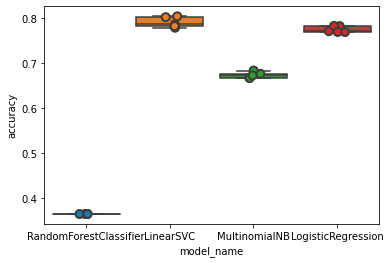

In [26]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [27]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.790721
LogisticRegression        0.774987
MultinomialNB             0.673554
RandomForestClassifier    0.365259
Name: accuracy, dtype: float64

# Undersampling

In [28]:
import numpy as np

# Undersampling using median count 
nsamples_per_class = np.int16(df['Product'].value_counts().median())
undersample = lambda df: df.loc[np.random.choice(a=df.index, size=min(len(df.index), nsamples_per_class), replace=False)]
df_bal = df.groupby(['Product'], as_index=False).apply(undersample)

print(df_bal.shape)

(174113, 3)


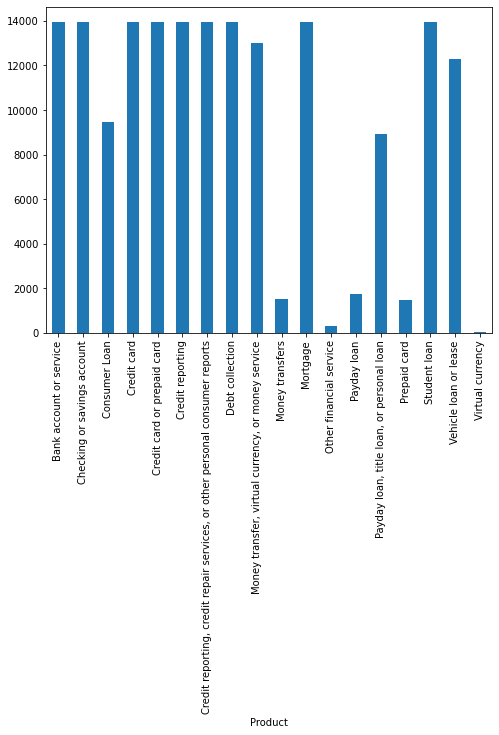

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_bal.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [30]:
df = df_bal

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(174113, 411119)

# Baseline Classifiers

- Logistic Regression
- (Multinomial) Naive Bayes
- Linear Support Vector Machine
- Random Forest

# Optimize Baseline Models Using GridSearchCV

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## Multinomial Naive Bayes Classifier

In [33]:
# Implement the grid search
pipe = Pipeline([("vectorizer", CountVectorizer()), 
                 ("classifier", MultinomialNB())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__alpha':[1, 0.1]}

gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Multinomial Naive Bayes classifier  
gridCV.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

In [ ]:
# Evaluate the Multinomial Naive Bayes classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

## Logistic Regression Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 #("tfidfVectorizer", TfidfVectorizer()),
                 ('classifier', LogisticRegression())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__C':[0.5, 1],
          'classifier__penalty':['l2', None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Logistic Regression classifier
gridCV.fit(X_train, y_train)

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

In [ ]:
# Evaluate the Logistic Regression classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

## Linear Support Vector Machine Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 #("tfidfVectorizer", TfidfVectorizer()),
                 ('classifier', LinearSVC())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          'classifier__loss':['squared_hinge', 'hinge']}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Linear SVC classifier
gridCV.fit(X_train, y_train)

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

In [ ]:
# Evaluate the Linear SVC classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

## Random Forest Classifier

In [ ]:
# Implement the grid search
pipe = Pipeline([('vectorizer', CountVectorizer()), 
                 #("tfidfVectorizer", TfidfVectorizer()),
                 ('classifier', RandomForestClassifier())])

params = {'vectorizer__ngram_range':[(1,1), (1,2)], 
          #'tfidfVectorizer__stop_words':[None, 'english'],
          'classifier__n_estimators':[50, 100, 150, 200]
          'classifier__max_depth':[2, 3, 4],
          'classifier__random_state':[0, None]}
          
gridCV = GridSearchCV(pipe, param_grid=params)

# Train the Random Forest classifier
gridCV.fit(X_train, y_train)

In [ ]:
print(gridCV.best_params_)
print(gridCV.best_score_)

In [ ]:
# Evaluate the Random Forest classifier
y_pred = gridCV.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

In [41]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

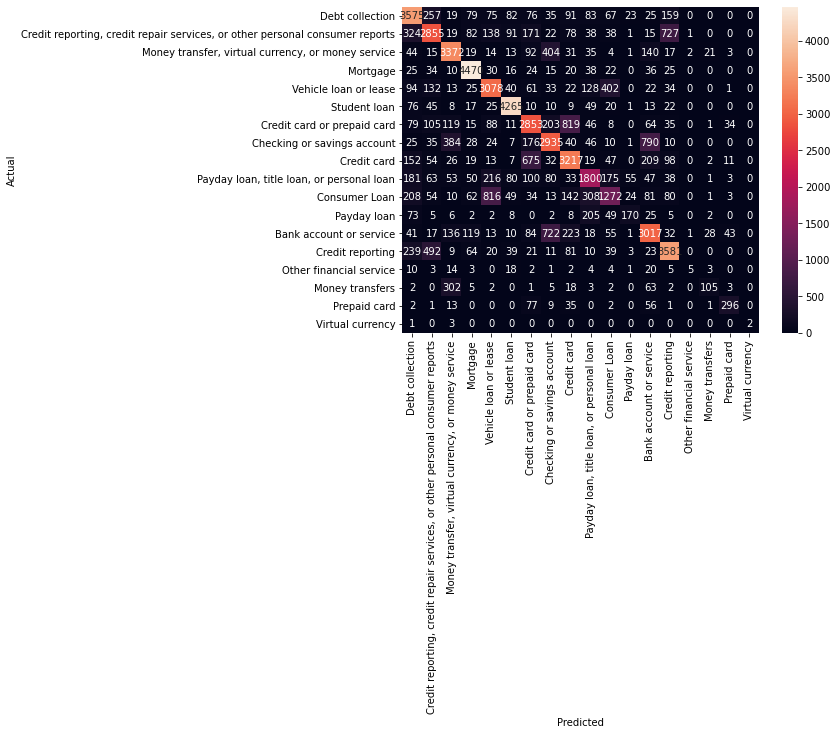

In [42]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [43]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 324 examples.


Product  \
6 263167   Credit reporting, credit repair services, or o...   
  865396   Credit reporting, credit repair services, or o...   
  195805   Credit reporting, credit repair services, or o...   
  1934661  Credit reporting, credit repair services, or o...   
  454388   Credit reporting, credit repair services, or o...   
...                                                      ...   
  342739   Credit reporting, credit repair services, or o...   
  1363668  Credit reporting, credit repair services, or o...   
  908070   Credit reporting, credit repair services, or o...   
  342526   Credit reporting, credit repair services, or o...   
  1866763  Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 263167   I had a bill from XXXX XXXX XXXX Hospital ( XX...  
  865396   I have contacted Santander trying to remove th...  
  195805   The below letter was sent to all three credit ...  
  1934661  have checked my credit report and noticed inac...  
  454388   I received my credit report and there was unko...  
...                                                      ...  
  342739   On XX/XX/2019 I paid off the remainder of my d...  
  1363668  This debt was reported to the credit bureaus. ...  
  908070   XXXX  and XXXX show debt by XXXX which is outs...  
  342526   Every one of these accounts and transactions I...  
  1866763  I RECENTLY CONTACTED PORTFOLIO RECOVERY ASSOCI...  

[324 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Debt collection' : 44 examples.


Product  \
8 329390   Money transfer, virtual currency, or money ser...   
  536609   Money transfer, virtual currency, or money ser...   
  396004   Money transfer, virtual currency, or money ser...   
  142190   Money transfer, virtual currency, or money ser...   
  798725   Money transfer, virtual currency, or money ser...   
  1006719  Money transfer, virtual currency, or money ser...   
  872854   Money transfer, virtual currency, or money ser...   
  330462   Money transfer, virtual currency, or money ser...   
  533448   Money transfer, virtual currency, or money ser...   
  82461    Money transfer, virtual currency, or money ser...   
  199843   Money transfer, virtual currency, or money ser...   
  60968    Money transfer, virtual currency, or money ser...   
  1895351  Money transfer, virtual currency, or money ser...   
  1855552  Money transfer, virtual currency, or money ser...   
  530266   Money transfer, virtual currency, or money ser...   
  1801093  Money transfer, virtual currency, or money ser...   
  816258   Money transfer, virtual currency, or money ser...   
  680708   Money transfer, virtual currency, or money ser...   
  1878877  Money transfer, virtual currency, or money ser...   
  250144   Money transfer, virtual currency, or money ser...   
  642122   Money transfer, virtual currency, or money ser...   
  1943720  Money transfer, virtual currency, or money ser...   
  887073   Money transfer, virtual currency, or money ser...   
  811796   Money transfer, virtual currency, or money ser...   
  406741   Money transfer, virtual currency, or money ser...   
  251622   Money transfer, virtual currency, or money ser...   
  274980   Money transfer, virtual currency, or money ser...   
  757083   Money transfer, virtual currency, or money ser...   
  713807   Money transfer, virtual currency, or money ser...   
  1898041  Money transfer, virtual currency, or money ser...   
  680397   Money transfer, virtual currency, or money ser...   
  146972   Money transfer, virtual currency, or money ser...   
  376460   Money transfer, virtual currency, or money ser...   
  476430   Money transfer, virtual currency, or money ser...   
  978720   Money transfer, virtual currency, or money ser...   
  951430   Money transfer, virtual currency, or money ser...   
  1899674  Money transfer, virtual currency, or money ser...   
  1361997  Money transfer, virtual currency, or money ser...   
  1161528  Money transfer, virtual currency, or money ser...   
  326375   Money transfer, virtual currency, or money ser...   
  410290   Money transfer, virtual currency, or money ser...   
  1824670  Money transfer, virtual currency, or money ser...   
  1030024  Money transfer, virtual currency, or money ser...   
  1992189  Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 329390   {$400000.00} was transferred. They held the fu...  
  536609   Hi, I have a huge problem with the information...  
  396004   I have repeatedly attempted to dispute charges...  
  142190   Robocall for Credit Bureau stating that they w...  
  798725   I am a licensed attorney in the state of Calif...  
  1006719  I called Debt Recovery Soloutions spoke to a X...  
  872854   On XXXX XXXX 2017, I authorized an electronic ...  
  330462   I signed up for help with Optima Advocates 2 a...  
  533448   XXXX XXXX XXXX called and identified themselve...  
  82461    I have been harrassed for 2 years. Ive tried r...  
  199843   It was a private business matter collecting a ...  
  60968    BLUF : This company is using intimidating verb...  
  1895351  I sent a transfer of {$200.00} on XXXX XXXX. I...  
  1855552  On XXXX-18 i went to atlanta check cashers loc...  
  530266   Why is keybank using the same tactics to not a...  
  1801093  XXXX XXXX XXXX XXXX XXXX XXXXXXXX XXXX CA XXXX...  
  816258   I have had an open on account with XXXX XXXX X...  
  680708   XXXX XXXX XXXX was contacte


'Mortgage' predicted as 'Debt collection' : 25 examples.


Product                       Consumer_complaint_narrative
10 1621945  Mortgage  Debtor is inaccurately reporing a debt to the ...
   1979131  Mortgage  On XX/XX/2018, I received a call from a man wh...
   1741325  Mortgage  First of all I am a widow and XXXX. my daughte...
   392916   Mortgage  Im requesting debt validation I sent a debt va...
   375286   Mortgage  JP Morgan Chase employees refused to fix or ad...
   38566    Mortgage  This complaint follows two previous complaints...
   1671438  Mortgage  I attempted to cancel an automatic payment, bu...
   1913666  Mortgage  Opposing counsel XXXX XXXX has responded to my...
   1825074  Mortgage  Suntrust foreclosed without written notice. \n...
   34136    Mortgage  I am the seller of a home that relied on a len...
   290254   Mortgage  M & T Bank, XXXX. Contacted on XX/XX/20 at thi...
   1636808  Mortgage  Your service help me to get the contract from ...
   1688383  Mortgage  Dear SPS, Please respond to actual question re...
   868816   Mortgage  The problem is that no one has paid attention ...
   532632   Mortgage  I have submitted proof of homeowner 's insuran...
   1707325  Mortgage  this is the fourth complaint about this compan...
   1651127  Mortgage              I suspect they produced a forged note
   1625083  Mortgage  In accordance with the Texas Debt Collection A...
   1742288  Mortgage  I filed for bankruptcy many years ago. I keep ...
   189072   Mortgage  Started with a debt collection letter on XX/XX...
   1711509  Mortgage  XXXX of my home equity line loans was sold to ...
   1721286  Mortgage  The company will not provide a " Satisfaction ...
   111718   Mortgage  Dear CFPB, please find this Complaint against ...
   324216   Mortgage  TRANSUNION, XXXX, and XXXX  each has reported ...
   897445   Mortgage  On XXXX XXXX, XXXX, the home equity loan held ...


'Vehicle loan or lease' predicted as 'Debt collection' : 94 examples.


Product  \
16 886681   Vehicle loan or lease   
   1980967  Vehicle loan or lease   
   91181    Vehicle loan or lease   
   1945469  Vehicle loan or lease   
   761529   Vehicle loan or lease   
...                           ...   
   541367   Vehicle loan or lease   
   992923   Vehicle loan or lease   
   648903   Vehicle loan or lease   
   918092   Vehicle loan or lease   
   953046   Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 886681   I turned in a XXXX XXXX lease seven months ear...  
   1980967  This is a follow up complaint to XXXX and, in ...  
   91181    I found the balance in the car loan was not ac...  
   1945469  I submitted a complaint # XXXX on XX/XX/XXXX. ...  
   761529   I am requesting this investigation under the a...  
...                                                       ...  
   541367   In 2017, I had a car loan with Regional Accept...  
   992923   I was tasked with short notice deployment arou...  
   648903   Credit Acceptance Corporation is fraudulently ...  
   918092   Myself and My husband mailed a debt validation...  
   953046   Truck was a XXXX XXXX XXXX was acquired in XXX...  

[94 rows x 2 columns]


'Student loan' predicted as 'Debt collection' : 76 examples.


Product                       Consumer_complaint_narrative
15 1668044  Student loan  After reviewing my credit report i noticed acc...
   910980   Student loan  The complaint is against Bass & Associates a d...
   1660635  Student loan  This debt is over 4 years old which is the sta...
   276281   Student loan  I received a telephone call at my place of emp...
   788989   Student loan  I am reporting multiple incidents involving on...
...                  ...                                                ...
   1738706  Student loan  I received a notice from Coast professional th...
   882039   Student loan  A long time ago I paid off all my loans from s...
   1631436  Student loan  I am XXXX and all my school loans were paid of...
   1796033  Student loan  I was called at XXXX and answered the phone an...
   1665479  Student loan  Have never heard of Coast Professionals until ...

[76 rows x 2 columns]


'Credit card or prepaid card' predicted as 'Debt collection' : 79 examples.


Product  \
4 931005   Credit card or prepaid card   
  866453   Credit card or prepaid card   
  896257   Credit card or prepaid card   
  1888982  Credit card or prepaid card   
  765177   Credit card or prepaid card   
...                                ...   
  919794   Credit card or prepaid card   
  1843936  Credit card or prepaid card   
  1843945  Credit card or prepaid card   
  730511   Credit card or prepaid card   
  42850    Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 931005   I have a XXXX account which is through XXXX XX...  
  866453   On XXXX XXXX. My credit card was charged XXXX ...  
  896257   In XX/XX/2018 I spoke to a rep about the issue...  
  1888982  I sent a letter to Capital One on XX/XX/XXXX w...  
  765177   My original bill was {$2100.00}. I've paid my ...  
...                                                      ...  
  919794   My credit report shows that I have a charge of...  
  1843936  XX/XX/XXXX To Whom It May Concern, I would be ...  
  1843945  I received a letter dated XX/XX/XXXX informing...  
  730511   the above account does not belong to me nor di...  
  42850    A week ago i received two letter from XXXX, XX...  

[79 rows x 2 columns]


'Checking or savings account' predicted as 'Debt collection' : 25 examples.


Product  \
1 869628   Checking or savings account   
  127582   Checking or savings account   
  39064    Checking or savings account   
  263877   Checking or savings account   
  334416   Checking or savings account   
  813191   Checking or savings account   
  186988   Checking or savings account   
  1793203  Checking or savings account   
  681245   Checking or savings account   
  962567   Checking or savings account   
  340561   Checking or savings account   
  1875755  Checking or savings account   
  1847858  Checking or savings account   
  428777   Checking or savings account   
  341529   Checking or savings account   
  96825    Checking or savings account   
  852978   Checking or savings account   
  970818   Checking or savings account   
  577232   Checking or savings account   
  1802453  Checking or savings account   
  1864443  Checking or savings account   
  378068   Checking or savings account   
  1879229  Checking or savings account   
  345663   Checking or savings account   
  1027092  Checking or savings account   

                                Consumer_complaint_narrative  
1 869628   Additional documents to go along with original...  
  127582   While I was in XXXX XXXX in Virginia from ( XX...  
  39064    ThereisnoevidenceofthevalidityoftheXXXXtransac...  
  263877   Im the victim of identity theft and I dont rec...  
  334416   '' We placed {$1300.00} in suspense on XX/XX/X...  
  813191   I have some weird harassing legal office calli...  
  186988   I received a phone call from a Courier service...  
  1793203  we got a telephone call from a company that pa...  
  681245   I have been dealing with this nonsense since X...  
  962567   XX/XX/2017 I notice I had a XXXX balance in my...  
  340561   On XX/XX/XXXX I signed up for a security monit...  
  1875755  I've been back and forth with Bank of America ...  
  1847858  On XX/XX/18 I checked my account online to fin...  
  428777   XXXX XXXX XXXX for {$130.00} and {$340.00} sho...  
  341529   I paid the amount owe contact them to remove s...  
  96825    I returned merchandise that I had purchased a ...  
  852978   I was made aware of an investment and checking...  
  970818   ACCOUNT IS SHOWING ON MY XXXX REPORT. THIS IS ...  
  577232   I made a complaint with you about it.The compl...  
  1802453  {$280.00} dollars were taken out of my account...  
  1864443  XXXX collection agency went through a third pa...  
  378068   I got a claim but do know where or how to clai...  
  1879229  This account should be closed. XXXX XXXX XXXX ...  
  345663   I had previously submitted the following compl...  
  1027092  On XX/XX/XXXXmy bank account was frozen. I con...


'Credit card' predicted as 'Debt collection' : 152 examples.


Product                       Consumer_complaint_narrative
3 1713465  Credit card  Due to XXXX XXXX action. This Debt Collector C...
  1042235  Credit card  Had a   XXXX   XXXX   credit card. Lost job an...
  1736259  Credit card  I was in a 8yr relationship # My ex applied fo...
  1732900  Credit card  XX/XX/2015, Midland Credit Management was told...
  1709856  Credit card  American Express Centurion Bank has obtained a...
...                ...                                                ...
  1629643  Credit card  XXXX XXXX, 2016 - I received a letter from XXX...
  1728890  Credit card  This is a follow up to a complaint I filed wit...
  1615339  Credit card  I have been contacted on numerous times by pho...
  1724613  Credit card  Sears allows there automated attendant to call...
  1725222  Credit card  I arranged for a payment plan to make good on ...

[152 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 181 examples.


Product  \
13 1880546  Payday loan, title loan, or personal loan   
   1817693  Payday loan, title loan, or personal loan   
   648137   Payday loan, title loan, or personal loan   
   1792617  Payday loan, title loan, or personal loan   
   1810527  Payday loan, title loan, or personal loan   
...                                               ...   
   822609   Payday loan, title loan, or personal loan   
   64816    Payday loan, title loan, or personal loan   
   973832   Payday loan, title loan, or personal loan   
   875384   Payday loan, title loan, or personal loan   
   951706   Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 1880546  I have several loans out and I'm starting this...  
   1817693  I pay easy money {$230.00} and I have my bank ...  
   648137   I have no knowledge of this account. I have tr...  
   1792617  The company states that I have n't payed them ...  
   1810527  Calling my parents house for a loan I dont any...  
...                                                       ...  
   822609   My girlfriend, XXXX XXXX, went to XXXX XXXX XX...  
   64816    How is this company allowed to charge interest...  
   973832   Recently while conducting a monitor of my cred...  
   875384   I have no choice but to question the business ...  
   951706   Company XXXX XXXX XXXX XXXX XXXX contacted me ...  

[181 rows x 2 columns]


'Consumer Loan' predicted as 'Debt collection' : 208 examples.


Product                       Consumer_complaint_narrative
2 1700899  Consumer Loan  They contacted my mother house on XXXX/XXXX/20...
  1632914  Consumer Loan  I signed up for the real estate investor 's ed...
  1681528  Consumer Loan  I have requested numerous times for Santander ...
  1610837  Consumer Loan  Nationwide Acceptance 's website says I owe a ...
  777999   Consumer Loan  The loan account ( account # XXXX ) from this ...
...                  ...                                                ...
  1698208  Consumer Loan  This creditor is extremely aggressive in their...
  1680579  Consumer Loan  In 2007, I had leased a vehicle through XXXX. ...
  1721980  Consumer Loan  The 2015 XXXX XXXX truck under purchase from a...
  1971816  Consumer Loan  I have received a letter from LTD attempting t...
  1707915  Consumer Loan  Notified lender unable to pay due to medical X...

[208 rows x 2 columns]


'Payday loan' predicted as 'Debt collection' : 73 examples.


Product                       Consumer_complaint_narrative
12 1637141  Payday loan  I received a letter in the mail from a debt co...
   1686004  Payday loan  This company sent me an email stating they hav...
   1708197  Payday loan  I took out a loan with XXXX XXXX. I am now bei...
   1787192  Payday loan  I was contacted by this agency this morning an...
   1744164  Payday loan  I was contacted by an officer and gave me a nu...
...                 ...                                                ...
   1738563  Payday loan  A debt collector called and said that they are...
   1700024  Payday loan  I keep receiving phone calls from people at a ...
   1671823  Payday loan  On several occasions I have submitted certifie...
   1063488  Payday loan  not sure what the debt is for have n't talked ...
   1635487  Payday loan  Trying to collect on a debt that I do n't reco...

[73 rows x 2 columns]


'Bank account or service' predicted as 'Debt collection' : 41 examples.


Product  \
0 1645582  Bank account or service   
  778547   Bank account or service   
  1062813  Bank account or service   
  1591711  Bank account or service   
  1635081  Bank account or service   
  1688996  Bank account or service   
  1063325  Bank account or service   
  1616570  Bank account or service   
  1652450  Bank account or service   
  1746764  Bank account or service   
  1682712  Bank account or service   
  1745542  Bank account or service   
  772398   Bank account or service   
  1695509  Bank account or service   
  1643233  Bank account or service   
  1699497  Bank account or service   
  1706695  Bank account or service   
  1661419  Bank account or service   
  1717099  Bank account or service   
  1723034  Bank account or service   
  858889   Bank account or service   
  1696646  Bank account or service   
  1704352  Bank account or service   
  1646321  Bank account or service   
  1676512  Bank account or service   
  1615033  Bank account or service   
  1755883  Bank account or service   
  1749406  Bank account or service   
  1646822  Bank account or service   
  1733253  Bank account or service   
  1753271  Bank account or service   
  1735288  Bank account or service   
  1620591  Bank account or service   
  1708213  Bank account or service   
  1643620  Bank account or service   
  1691395  Bank account or service   
  1645894  Bank account or service   
  1741745  Bank account or service   
  1614571  Bank account or service   
  1626895  Bank account or service   
  1710490  Bank account or service   

                                Consumer_complaint_narrative  
0 1645582  I owed approximately XXXX dollars, to XXXX whi...  
  778547   Received an incoming call from a local phone n...  
  1062813  I had several accounts at BMO Harris Bank in X...  
  1591711  I had an account with Bank of America in XXXX ...  
  1635081  I was in search of information about BOA 's Pr...  
  1688996  I submitted a dispute with BK OF AMER account ...  
  1063325  I previously submitted a complaint on XX/XX/20...  
  1616570  My account was closed by PNC Bank .... My acco...  
  1652450  I keep getting letters for the past few years ...  
  1746764  BRCLYSBANKDE ACCOUNT NUMBERs : XXXX XXXX/XXXX/...  
  1682712  As with File no 2016 - CFPB XXXX Navy Federal ...  
  1745542  XXXX Regarding above complaint ; after months ...  
  772398   A debt collector contacted me via fake process...  
  1695509  This is in regards to XXXX and the illegal tra...  
  1643233  To whom it may concern, I am disappointed with...  
  1699497  Hello, I have received a mail dated back to XX...  
  1706695  I closed my US bank account over 5 years ago. ...  
  1661419  US Bank is attempting to collect an unreasonab...  
  1717099  good dayMy name is XXXX XXXX and attend XXXX X...  
  1723034  I summited a dispute with all credit bueraus f...  
  858889   Woke up to find a joint acct I share with my d...  
  1696646  I received a letter in the mail from a collect...  
  1704352  I have been contacted by several companies reg...  
  1646321  SYNCB/LOWE 'S DC ACCOUNT NUMBERs : XXXX XX/XX/...  
  1676512  Bank of America took my business account overd...  
  1615033  Years ago, I used to have an account with U.S....  
  1755883  i have been fighting with bank of america for ...  
  1749406  I am being contacted continually by 5th 3rd Ba...  
  1646822  PNC XXXX XXXX Bank sent me a notice from XXXX ...  
  1733253  Third party escrow company collected my money ...  
  1753271  I am being charged a debt for a company that I...  
  1735288  Bank of America has been trying to collect on ...  
  1620591  I have been getting a lot of calls on my fax p...  
  1708213  I was recently charge {$75.00} fee on my check...  
  1643620  I had come to a settlement with US bank and af...  
  1691395  Well Fargo and it 's " agents '' have been HAR...  
  1645894  I been eating at XXXX for awhile, so today XXX...  
  1741745  ON XXXX XXXX, XXXX, A DEB


'Credit reporting' predicted as 'Debt collection' : 239 examples.


Product                       Consumer_complaint_narrative
5 1685736  Credit reporting  XXXX appears on my credit report as an open co...
  1603906  Credit reporting  I have been a victim of identity theft, this c...
  1662759  Credit reporting  XXXX account # XXXX I have insurance, I paid m...
  1722470  Credit reporting  I continue to be harassed by XXXX XXXX. They a...
  1704877  Credit reporting  XXXX XXXX has placed a report on my XXXX burea...
...                     ...                                                ...
  1687229  Credit reporting  XXXX XXXX XXXX On XXXX the original creditor w...
  1662815  Credit reporting  There has been an bankrupty on my account that...
  1670301  Credit reporting  It shows on my credit that I have a {$75.00} b...
  1655672  Credit reporting  I have no contract with MIDLAND FUNDING. They ...
  1632583  Credit reporting  I would like to thank your office for the swif...

[239 rows x 2 columns]


'Other financial service' predicted as 'Debt collection' : 10 examples.


Product  \
11 1633937  Other financial service   
   1683030  Other financial service   
   1700009  Other financial service   
   1688911  Other financial service   
   1647867  Other financial service   
   1707045  Other financial service   
   1713489  Other financial service   
   739586   Other financial service   
   1791655  Other financial service   
   1703084  Other financial service   

                                 Consumer_complaint_narrative  
11 1633937  After talking to an XXXX XXXX employee and ans...  
   1683030  ON the day both social security and SSI XXXX f...  
   1700009  Calling me on my job and submitting personal i...  
   1688911  I contacted the Law Office of Michael Lupolove...  
   1647867  I was contacted by a representative and was to...  
   1707045  Money Management international did not disclos...  
   1713489  Returned check amounts for XXXX are showing as...  
   739586   Cornerstone Legal Group , LLC XXXX XXXX XXXX X...  
   1791655  As of XXXX XXXX I had repaid my debt with an e...  
   1703084  I have just started with Clear One Advantage a...


'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 257 examples.


Product                       Consumer_complaint_narrative
7 479759   Debt collection  Im making a complaint against trans world syst...
  1905724  Debt collection                That account does not belongs to me
  483907   Debt collection  I sent The Bureaus a letter on XX/XX/XXXX, to ...
  1120440  Debt collection  I have filed a dispute with FOCUS FINANCIAL SE...
  35905    Debt collection  XXXX XXXX is reporting a account on all three ...
...                    ...                                                ...
  770817   Debt collection  I recently received a copy of my credit file f...
  1844926  Debt collection  On XX/XX/2018 I requested validation from XXXX...
  138007   Debt collection  I filed bankruptcy on XX/XX/2018. In XXXX Disc...
  956715   Debt collection  XXXX XXXX XXXX, SSN # : XXXX XXXX XXXX XXXX XX...
  379481   Debt collection  I NOTICED IN XXXX THAT A FRAUDULENT ACCOUNT WA...

[257 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 15 examples.


Product  \
8 61142    Money transfer, virtual currency, or money ser...   
  595682   Money transfer, virtual currency, or money ser...   
  142532   Money transfer, virtual currency, or money ser...   
  798863   Money transfer, virtual currency, or money ser...   
  221631   Money transfer, virtual currency, or money ser...   
  741034   Money transfer, virtual currency, or money ser...   
  1969331  Money transfer, virtual currency, or money ser...   
  342061   Money transfer, virtual currency, or money ser...   
  544489   Money transfer, virtual currency, or money ser...   
  193491   Money transfer, virtual currency, or money ser...   
  288411   Money transfer, virtual currency, or money ser...   
  1000977  Money transfer, virtual currency, or money ser...   
  516899   Money transfer, virtual currency, or money ser...   
  970657   Money transfer, virtual currency, or money ser...   
  214987   Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 61142    They just XXXX  me and changed the subject and...  
  595682   XX/XX/2020 I canceled a transaction of {$180.0...  
  142532   They locked my account. It has been locked for...  
  798863   PayPal Credit offe rs both standard and deferr...  
  221631   See attachment for specific details : Unauthor...  
  741034   This is a {$2.00} XXXX dollar 'pump and dump C...  
  1969331  I used '' TransUnion '' website to check credi...  
  342061   I began using Venmo only 2 weeks ago and feel ...  
  544489   Wells Fargo employees stole my ID and applied ...  
  193491   In general a debit card was opened in my name ...  
  288411   XX/XX/2020 I was alerted by XXXX  through XXXX...  
  1000977  Dear staff, I recently opened a PayPal account...  
  516899   My identity has been stolen all accounts Inked...  
  970657   XXXX XXXX XXXX XXXX XXXX. \n\nThese con artist...  
  214987   JPMORGAN FINANCIAL CORP HAS BEEN exposing ALL ...


'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 34 examples.


Product                       Consumer_complaint_narrative
10 1639268  Mortgage  Land Home Financial is reporting a debt discha...
   833273   Mortgage  As of XXXX XXXX, XXXX, Ocwen again changed the...
   30255    Mortgage  In XXXX of 2018 my loan was sold to XXXX XXXX ...
   342746   Mortgage  Shellpoint Mortgage has reported on XX/XX/2020...
   1636458  Mortgage  I applied for a reverse mortgage through One R...
   311680   Mortgage  I have written to Ocwen on two occasions point...
   1677098  Mortgage  I have previous had an auto loan XXXX and a re...
   1985165  Mortgage  We have a mortgage with what started out to be...
   1610490  Mortgage  We settled a dispute with Chase regarding a mo...
   622100   Mortgage  I enrolled in a CARES ACT forbearance plan in ...
   1718364  Mortgage  WELLS FARGO SHOWED THEY PAYMENT AS BEING LATE ...
   1906947  Mortgage  I signed up for automatic payments to be deduc...
   623786   Mortgage  TO XX/XX/XXXX TEXAS XXXX XXXX XXXX XXXX XXXX X...
   389284   Mortgage  I have not been late on this account. I have b...
   1722463  Mortgage  Saxon Mortgage is inaccurately reporting the m...
   1621725  Mortgage  BB & T XXXX XXXX and XXXX XXXX sent my husband...
   491305   Mortgage  I was on a COVID-19 Deferment Plan that I sign...
   594585   Mortgage  We closed with XXXX on XXXX XX/XX/2019 and our...
   1744436  Mortgage  SETERUS INC is reporting a delinquent account....
   1856581  Mortgage  Step 1 : What is this complaint about? \nAccor...
   1653209  Mortgage  I am filing this complaint against DiTech and ...
   1722650  Mortgage  I wanted to buy a home.I shopped around a lot ...
   764724   Mortgage  This is the letter I have sent to all three of...
   778865   Mortgage  This is in rebuttal to previous complaint XXXX...
   1829419  Mortgage  I am currently in chapter XXXX. My husband is ...
   1902751  Mortgage  Due to some uncontrollable circumstances, I ha...
   265156   Mortgage  I payed my XXXX XXXX and XX/XX/XXXX payment on...
   968790   Mortgage  On XX/XX/2019, I applied online for a mortgage...
   338157   Mortgage  I applied for a mortgage loan with NVR Mortgag...
   536705   Mortgage  None of the information showing on my consumer...
   368601   Mortgage  Several disputes have been made with regards t...
   411881   Mortgage  XX/XX/XXXX, XX/XX/XXXX, & XX/XX/XXXX showed I ...
   1005706  Mortgage  on XX/XX/2018 a credit check was done. I DID N...
   58546    Mortgage  Was applying for a mortgage refinance through ...


'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 132 examples.


Product  \
16 535287   Vehicle loan or lease   
   247558   Vehicle loan or lease   
   615726   Vehicle loan or lease   
   534548   Vehicle loan or lease   
   520108   Vehicle loan or lease   
...                           ...   
   1866354  Vehicle loan or lease   
   736060   Vehicle loan or lease   
   900427   Vehicle loan or lease   
   1857633  Vehicle loan or lease   
   180813   Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 535287   Re : Request to Reinvestigate & Delete Account...  
   247558   RateGenius is a auto refinance company online ...  
   615726   In XXXX I received a notice that my account wa...  
   534548   bad warranty and balance on the original contr...  
   520108   On XX/XX/2020, Carvana pulled my personal cred...  
...                                                       ...  
   1866354  I was told by a GoFinanical rep at the company...  
   736060   I have disputed this account with the company ...  
   900427   In XX/XX/XXXX I signed a new auto lease with X...  
   1857633  Issue is with XXXX XXXX XXXX, specifically XXX...  
   180813   On or about XX/XX/2019 I applied for a loan pu...  

[132 rows x 2 columns]


'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 45 examples.


Product                       Consumer_complaint_narrative
15 580521   Student loan  I received a letter for a settlement amount of...
   749607   Student loan  I took out this loan back in XXXX to attend co...
   232288   Student loan  My loan was in default initially, XXXX and now...
   37345    Student loan  I have XXXX XXXX XXXX loan XXXX. I have no way...
   1851585  Student loan  Student Account balance and High APR on studen...
   884844   Student loan  To Whom It May Concern : This letter is a foll...
   1725176  Student loan  After obtaining a copy of my credit I noticed ...
   902071   Student loan  Nelnet and XXXX XXXX XXXX are continuously add...
   930352   Student loan  In XXXX XXXX, I sent a letter to ask for verif...
   241379   Student loan  To whomever it may concern : Thank you very mu...
   1935505  Student loan  THEY ARE REPORTING 90 DAY TO 120 DAYS LATE 3 T...
   114267   Student loan  This company has repeatedly been negligent wit...
   1699800  Student loan  I have attempted to verify this account and to...
   1701513  Student loan  CFPB : I am writing to dispute erroneous credi...
   35131    Student loan  In XX/XX/XXXX, my wife and I obtained a loan f...
   371674   Student loan  I checked my credit and saw the wrong informat...
   522255   Student loan  XX/XX/XXXX XXXX XXXX has refused to furnish th...
   1644565  Student loan  XX/XX/XXXX XXXX XXXX NJ XXXX Complaint Departm...
   1952963  Student loan  A student loan was took out using my informati...
   546384   Student loan  I have a XXXX loan for my XXXX  program throug...
   1837889  Student loan  XXXX XXXX XXXX XXXX appears on all 3 credit re...
   1998298  Student loan  Im have financial difficulties at the moment a...
   1638981  Student loan  I am in forebrance. It shows on my credit repo...
   914163   Student loan  AES ( also known as PHEAA ) is consistently en...
   1844880  Student loan  For XXXX they have been reporting on an incorr...
   505519   Student loan  Account No. XXXX XXXX dba XXXX XXXX XXXX ( XXX...
   1909145  Student loan  My complaint that I submitted earlier on XX/XX...
   1881731  Student loan  PAID OLD LOANS IN FULL, BUT THEY ARE STILL REP...
   1680954  Student loan  Dear XXXX, This is my formal complaint letter ...
   1656217  Student loan  The way the loan is now being reported has cau...
   1847195  Student loan  I recently applied for a mortgage and was deva...
   429980   Student loan  items need to be removed and deleted from cred...
   130738   Student loan  student loan reporting incorrect and inaccurat...
   37033    Student loan  All accounts are paid in full but they do not ...
   106358   Student loan  Ex-husband used my information to get a parent...
   635291   Student loan  on XX/XX/2020, i was attempting to find possib...
   779122   Student loan  The XXXX loans reporting on the XXXX credit bu...
   868676   Student loan  When applying for my student loan, I was under...
   943145   Student loan  Reported that I was 90 days late on a payment,...
   1942437  Student loan  I have ad repeated issues with the collection ...
   612333   Student loan  XXXX XXXXXX/XX/2020XXXX XXXXXXXX XXXX XXXXXXXX...
   930179   Student loan  CFPB : XXXX This is a continued problem with X...
   1874918  Student loan  I have a loan with XXXX XXXX  XXXX. I have alw...
   1971554  Student loan  They said they removed the loan from my accoun...
   421732   Student loan  XXXX  continues to do re investigations, but h...


'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 105 examples.


Product  \
4 159735   Credit card or prepaid card   
  78869    Credit card or prepaid card   
  337182   Credit card or prepaid card   
  332616   Credit card or prepaid card   
  445666   Credit card or prepaid card   
...                                ...   
  957143   Credit card or prepaid card   
  1930146  Credit card or prepaid card   
  213335   Credit card or prepaid card   
  926847   Credit card or prepaid card   
  759594   Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 159735   This account is being reported inaccurately. I...  
  78869    capital one ( 2 different accounts, numerous e...  
  337182   On XX/XX/2019 I sent a dispute letter to the C...  
  332616   My fifth third credit card account was not rep...  
  445666   I am showing a 30 day late on my credit report...  
...                                                      ...  
  957143   Upon reviewing my finances I checked my annual...  
  1930146  XXXX XXXX XXXX XXXX XXXX XXXX/ XXXX  all on th...  
  213335   Experian is claiming the following issue conce...  
  926847   I ordered a pair of jeans from XXXX and return...  
  759594   Due to the pandemic I was unemployed and unabl...  

[105 rows x 2 columns]


'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 35 examples.


Product  \
1 1879403  Checking or savings account   
  561829   Checking or savings account   
  232299   Checking or savings account   
  794829   Checking or savings account   
  393480   Checking or savings account   
  681116   Checking or savings account   
  607007   Checking or savings account   
  961398   Checking or savings account   
  492070   Checking or savings account   
  911577   Checking or savings account   
  1002036  Checking or savings account   
  699650   Checking or savings account   
  26450    Checking or savings account   
  1853392  Checking or savings account   
  110401   Checking or savings account   
  213954   Checking or savings account   
  957636   Checking or savings account   
  1839241  Checking or savings account   
  1000223  Checking or savings account   
  344250   Checking or savings account   
  505245   Checking or savings account   
  75388    Checking or savings account   
  918027   Checking or savings account   
  883492   Checking or savings account   
  802625   Checking or savings account   
  71632    Checking or savings account   
  1970608  Checking or savings account   
  806910   Checking or savings account   
  1892749  Checking or savings account   
  914145   Checking or savings account   
  71215    Checking or savings account   
  540899   Checking or savings account   
  1834325  Checking or savings account   
  121495   Checking or savings account   
  612544   Checking or savings account   

                                Consumer_complaint_narrative  
1 1879403  My identity has been stolen and the perpetrato...  
  561829   I had a line of credit with Citizens Bank that...  
  232299   I received a letter dated XX/XX/XXXX from M & ...  
  794829   STOLEN IDENTITY LEAD TO A BANK OF AMERICA ACCO...  
  393480   I noticed an unauthorized checking account ope...  
  681116   I disputed inaccurate accounts reported by com...  
  607007   Over XXXX worth of unrefunded fraud by XXXX XX...  
  961398   i have spoken to all the banks that i have the...  
  492070   According to XXXX  transactions data, on the d...  
  911577   A checking and savings account was opened frau...  
  1002036  XXXX XXXX put a block on a merchant without my...  
  699650   I was informed by the Consumer Finance Protect...  
  26450    On XX/XX/2019, I logged on to my XXXX XXXXXXXX...  
  1853392  I believe I have a victim of identity theft. M...  
  110401   On XX/XX/XXXX and XX/XX/XXXX I applied for an ...  
  213954   I have made several attempts to rectify this s...  
  957636   I have presented Goldman Sachs Bank USA with d...  
  1839241  WELLS FARGO SHOWING ON XXXX XXXX XXXX XXXX HAV...  
  1000223  I filed a complaint with the CFPB on 2 factor ...  
  344250   On XX/XX/20 I initiated a one-time {$800.00} d...  
  505245   I believe I've been a victim of identity test....  
  75388    XX/XX/2018 was the date of the rejected openin...  
  918027   Bank of America allowed XXXX XXXX XXXX XXXX XX...  
  883492               open accounts cra and hippa violation  
  802625   My bank is not reporting my updated balance to...  
  71632    I tried to sign up for the MoneyLion product t...  
  1970608  I am writing about ameris bank and manager XXX...  
  806910   XXXX XXXX XXXX XXXX failed to credit my accoun...  
  1892749  In XX/XX/XXXX I fell on difficult times financ...  
  914145   My complaint is regarding City Bank. Citi Bank...  
  71215    A checking and savings account was opened frau...  
  540899   I closed all 3 family Chase accounts in late X...  
  1834325  In XX/XX/XXXXmy wife and I obtained a divorce....  
  121495   ( ( XXXX XXXX XXXX Family Trust w/Comerica-XXX...  
  612544   My accounted for the late transactions I repor...


'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 54 examples.


Product                       Consumer_complaint_narrative
3 1637714  Credit card  Chevron is reporting me on the credit bureaus ...
  1703221  Credit card  I had a fraudulent charge on my bloomingdales ...
  1671724  Credit card  Care Credit miss reported me as deceased. I ha...
  1620561  Credit card  Gap visa. This account has been opened without...
  849515   Credit card  I do not recognize this account it is not mine...
  1730870  Credit card  Back in XXXX XXXX erroneously reported late pa...
  1745573  Credit card  Capitol One used information from my father in...
  1669708  Credit card  I was vacationing in XXXX XXXX when I had frau...
  1716449  Credit card  Between XX/XX/XXXX and XXXX XXXX XXXX/CBNA rep...
  1681029  Credit card  Opened a Visa account with B of A XX/XX/2007 a...
  1654112  Credit card  I was investigating the fraudulent charges on ...
  807813   Credit card  Complaint is that I and all are being manipula...
  1671291  Credit card  I am a identity theft victim, i have had accou...
  1612465  Credit card  I have contacted the fraud department on sever...
  1649488  Credit card  Denial of credit for too many inquiries on my ...
  1684849  Credit card  Chase Card has placed several inquiries on my ...
  1757691  Credit card  I had a credit card with Capital One. They cha...
  1680288  Credit card  We appreciate your taking time form your busy ...
  1663163  Credit card  bank closed my account and is reporting inaccu...
  1645056  Credit card  Target is reporting an account on my credit re...
  1714724  Credit card  I have called several times that they are repo...
  1730998  Credit card  this account was to be deleted from my credit ...
  1631110  Credit card  I paid my credit card bill on time and it is s...
  1679100  Credit card  non payments reported, payments made thru auto...
  1652291  Credit card  I 'm writing my complaint against Seventh Aven...
  1610929  Credit card  My credit card was opened in XXXX. At some poi...
  1692033  Credit card  I was a victim of identity theft/fraud. Withou...
  843582   Credit card  Discover Card had issued credits back due to u...
  1638718  Credit card  I recent had my credit pulled and was alarm ab...
  1637873  Credit card  All XXXX major credit reporting agencies have ...
  1713888  Credit card  I have contacted Citibank at least eight times...
  1664702  Credit card  Sears/CBNA is reported an adversed information...
  1723996  Credit card  In a previous complaint, I requested that Navy...
  1676753  Credit card  I disputed in the latest part of our case, num...
  1061681  Credit card  On two occasions, one in XX/XX/XXXX and XX/XX/...
  1685174  Credit card  I opened a secured credit card with XXXX XXXX ...
  1734314  Credit card  Capital One Representative XXXX explained to m...
  1683320  Credit card  I had unemployment insurance on my Capital One...
  1649179  Credit card  I have been the victim of identity theft fraud...
  1675039  Credit card  Paypal Credit pulled my credit score without m...
  1728349  Credit card  I have on my credit reports Jared XXXX XXXX XX...
  1634228  Credit card  i was a victim of identity theft and i noticed...
  1688602  Credit card  I was preparing to 'DISPUTE ' the results of [...
  1028520  Credit card  I have for the past year disputing this accoun...
  1705188  Credit card  I looked at my credit report and seen somethin...
  779710   Credit card  I had called Capital One and stated I was a vi...
  1743099  Credit card  I received a letter dated XXXX XXXX From Targe...
  1717290  Credit card  The following items were non receipt/unauthori...
  1735531  Credit card  I had my credit report pulled on XX/XX/2017, o...
  1646319  Credit card  XXXX and Transunion have reported this incorre...
  1631829  Credit card  on XXXX/XXXX/2015. i obtain a copy of my credi...
  1613797  Credit card  Synchrony Bank is now reporting to multiple co...
  1624101  Credit card  I had an account with Lowe 's but it was at le...
  1703453  Credit c


'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 63 examples.


Product  \
13 376275   Payday loan, title loan, or personal loan   
   220040   Payday loan, title loan, or personal loan   
   996469   Payday loan, title loan, or personal loan   
   99616    Payday loan, title loan, or personal loan   
   29049    Payday loan, title loan, or personal loan   
...                                               ...   
   537423   Payday loan, title loan, or personal loan   
   754291   Payday loan, title loan, or personal loan   
   154338   Payday loan, title loan, or personal loan   
   1959412  Payday loan, title loan, or personal loan   
   177235   Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 376275   I agreed to pay a settlement to National Credi...  
   220040   Was preapproved for up to 10k on or around XX/...  
   996469   Account is closed and was paid in full. Never ...  
   99616    Request of terms, rules, agreements with vario...  
   29049    I filed for bankruptcy XX/XX/2018 XXXX Sun Loa...  
...                                                       ...  
   537423   There is a time share reporting on my credit r...  
   754291   XXXX Previously I filed a complaint with CFPB ...  
   154338   I keep receiving offers to apply for loans. I ...  
   1959412  Sunset Finance, XXXX XXXX XXXX XXXX # XXXX, XX...  
   177235   They claim my credit score is below 700, when ...  

[63 rows x 2 columns]


'Consumer Loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 54 examples.


Product                       Consumer_complaint_narrative
2 1669848  Consumer Loan  I disputed the balance on account number XXXX ...
  1726264  Consumer Loan  There a couple or several inquiries being repo...
  1695466  Consumer Loan  I made a purchase to a XXXX Compass jeep. Afte...
  1707321  Consumer Loan  to help clear this matter I am prepared to off...
  835058   Consumer Loan  We were over 30 days late making a payment on ...
  1631532  Consumer Loan  Letters have been sent asking for them to prov...
  1684393  Consumer Loan  Company sent me a letter on XXXX/XXXX/XXXX in ...
  1710322  Consumer Loan  I sumbitted a complaint against drivetime repo...
  1689081  Consumer Loan       Paid in full and is saying it was never paid
  1693825  Consumer Loan  I closed the account XX/XX/XXXX.why is still s...
  1694406  Consumer Loan  TJX TJMAX said that I have an account and I to...
  1614013  Consumer Loan  The company reported a late payment on my repo...
  1627560  Consumer Loan  Completed an inquiry with Lending XXXX to refi...
  1711202  Consumer Loan  I have had my car that is finance through XXXX...
  1784013  Consumer Loan  I paid off my auto loan in XX/XX/2013. Capital...
  1746701  Consumer Loan  These accounts were opened in approx XX/XX/XXX...
  1652337  Consumer Loan  My name is XXXX XXXX XXXX date of birth XXXX/X...
  1661314  Consumer Loan  XXXX XXXX XXXX XXXX XXXX XXXX XXXX Georgia XXX...
  1716683  Consumer Loan  Account was sold and still being reported as a...
  1730605  Consumer Loan  CBC Innovis/First direct Lending I have tried ...
  1723921  Consumer Loan  This formal complaint is due to a various tren...
  1671818  Consumer Loan  My account with Regions Bank XXXX XXXX XXXX XX...
  1675426  Consumer Loan  I purchased a vehicle from DriveTime XX/XX/XXX...
  1624589  Consumer Loan  I Have a loan with Vouch Financial and have ma...
  1694941  Consumer Loan  WHILE PURCHASING A VEHICLE, I WAS TURNED DOWN ...
  1732035  Consumer Loan  US bank keeps reporting inaccurate information...
  1613979  Consumer Loan  I previously submitted a complaint on worth fi...
  1707550  Consumer Loan  Inaccurate information being reported to credi...
  1741330  Consumer Loan  Hello In reviewing our credit report we notice...
  1063361  Consumer Loan  The credit bureaus are reporting credit that i...
  1633281  Consumer Loan  Citizens Bank has repeatedly reported that my ...
  1638638  Consumer Loan  Santander is reporting as if the loan is open ...
  1734754  Consumer Loan  closed the credit card paid in full and after ...
  1622453  Consumer Loan  THERE ARE UNKNOW INQUIRES ON MY CREDIT REPORT ...
  1621670  Consumer Loan  I paid this loan on XX/XX/XXXX. The company up...
  853278   Consumer Loan  Ford Motor Credit made several monetary and cl...
  1697509  Consumer Loan  Sun Trust is reporting derogatory and inaccura...
  1782336  Consumer Loan  Car Hop and UAC are reporting incorrect inform...
  1679669  Consumer Loan  There is a hard inquiry on my credit report th...
  1668699  Consumer Loan  I APPLIED FOR A XXXX AUTOLOAN WITH XXXX, AND C...
  771293   Consumer Loan  I applied for a loan for a car XX/XX/XXXX the ...
  1743359  Consumer Loan  the company ran my credit report multiple time...
  1669747  Consumer Loan  I see that XXXX is reporting me late on an acc...
  1616725  Consumer Loan  I had my credit score ran 2 times by Spring Le...
  1613361  Consumer Loan  To whom it may concern, Exeter Finance Corp is...
  772684   Consumer Loan  This item [COMPASS BK XXXXAUTOMOBILE INSTALLME...
  1616938  Consumer Loan  I received a loan for my vehicle and I was nev...
  1689744  Consumer Loan  I began shopping for a new automobile in XXXX ...
  1037047  Consumer Loan  I took out an installment loan XX/XX/XXXX. I h...
  1637137  Consumer Loan  XXXX XXXX XXXX XXXX as Assignee Gamache and Me...
  1731188  Consumer Loan  I filed a complaint on Toyota Motor for report...
  1686561  Consumer Loan  This is a follow up on complaint # XXXX


'Bank account or service' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 17 examples.


Product  \
0 1711236  Bank account or service   
  1694773  Bank account or service   
  1742892  Bank account or service   
  1746975  Bank account or service   
  1710992  Bank account or service   
  1700003  Bank account or service   
  1648500  Bank account or service   
  1697182  Bank account or service   
  663337   Bank account or service   
  1737608  Bank account or service   
  1745585  Bank account or service   
  1717621  Bank account or service   
  1733402  Bank account or service   
  1731524  Bank account or service   
  1697403  Bank account or service   
  1626479  Bank account or service   
  1683658  Bank account or service   

                                Consumer_complaint_narrative  
0 1711236  Fraudulent charges on account are refusing to ...  
  1694773  There is an account with Pioneer/XXXX XXXX XXX...  
  1742892  This is a fraudulent account that I never appl...  
  1746975  I am a victim of identity theft. My personal i...  
  1710992  I recently tried to open a Business bank accou...  
  1700003  Early warning services is reporting inaccurate...  
  1648500  Applied and approved for loan in XX/XX/XXXX at...  
  1697182                Fraudulent action to freeze account  
  663337   I paid off a charge-off account at Chase Bank ...  
  1737608  Opened an account with syncrony bank made paym...  
  1745585  Capital one bank refuses to remove fraudulent ...  
  1717621  PENTAGON FCU XXXX ACCOUNT NUMBER OPEN DATE XX/...  
  1733402  I have discovered someone stole my identity an...  
  1731524  Regions Bank is erroneously reporting a negati...  
  1697403  I have had some problems with PayPal in the pa...  
  1626479  On XX/XX/XXXX, I filed a complaint towards cit...  
  1683658  My bank asked me to apply for a bank credit ca...


'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 492 examples.


Product                       Consumer_complaint_narrative
5 1722988  Credit reporting  I have multiple duplicate inquiries on my cred...
  1655071  Credit reporting  PLEASE CAN SOMEONE HELP ME!!!! Equifax has ref...
  1641515  Credit reporting  this is the first time ive ever received my ba...
  1612037  Credit reporting  My credit was pulled without knowledge on XXXX...
  1673108  Credit reporting  Credit Karma is displaying invalid scores and ...
...                     ...                                                ...
  1673414  Credit reporting  Transunion Keeps putting 90 Day Initial Alerts...
  1614276  Credit reporting  I hereby acknowledge that I am the author of a...
  1687018  Credit reporting  I was the victim of identity theft. The credit...
  1602479  Credit reporting  In my credit reports it has me as having multi...
  1684458  Credit reporting  There is a credit inquiry from XXXX XXXX that ...

[492 rows x 2 columns]


'Debt collection' predicted as 'Money transfer, virtual currency, or money service' : 19 examples.


Product                       Consumer_complaint_narrative
7 917066   Debt collection  I sold tickets and used paypal goods and servi...
  14292    Debt collection  Received a letter in the mail dated XX/XX/19 f...
  1825883  Debt collection  XXXX XXXX XXXX XXXX  XXXX, XXXX XXXX XXXX, XXX...
  136309   Debt collection  I have been on XXXX since XXXX XXXX. I had use...
  1892884  Debt collection  Received a debt collections letter dated XX/XX...
  1924875  Debt collection  I preface this by conceding that that automate...
  59598    Debt collection  I am having a issue with bill me later through...
  1649932  Debt collection  i got a letter from PayPal inc charging me {$9...
  1837401  Debt collection  The company is XXXX and whenever I am late on ...
  542024   Debt collection  I have been receiving emails from " PayPal '' ...
  1693196  Debt collection  XXXX in my book is a thief & scammer, th ewors...
  1843340  Debt collection  CFPB Complaint XXXX ( which is closed ). \nThe...
  639606   Debt collection  I made a purchase with Paypal Pay in 4 payment...
  145611   Debt collection  I am asked to pay {$520.00} by I C system. I w...
  84857    Debt collection  They call numerous times, do not send anything...
  35061    Debt collection  I disuputed this account as soon as It came to...
  935614   Debt collection  PHOENIX FINANCIAL SERVICE {$490.00} I never us...
  1866099  Debt collection  AS I HAVE DONE SEVERAL TIMES BEFORE I PLACED A...
  844400   Debt collection  Last XX/XX/XXXXeye opened checking and saving ...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Money transfer, virtual currency, or money service' : 19 examples.


Product  \
6 1991561  Credit reporting, credit repair services, or o...   
  1877358  Credit reporting, credit repair services, or o...   
  288087   Credit reporting, credit repair services, or o...   
  600737   Credit reporting, credit repair services, or o...   
  192409   Credit reporting, credit repair services, or o...   
  211136   Credit reporting, credit repair services, or o...   
  503438   Credit reporting, credit repair services, or o...   
  682342   Credit reporting, credit repair services, or o...   
  340308   Credit reporting, credit repair services, or o...   
  1839668  Credit reporting, credit repair services, or o...   
  939566   Credit reporting, credit repair services, or o...   
  471068   Credit reporting, credit repair services, or o...   
  265681   Credit reporting, credit repair services, or o...   
  959403   Credit reporting, credit repair services, or o...   
  387992   Credit reporting, credit repair services, or o...   
  907533   Credit reporting, credit repair services, or o...   
  367066   Credit reporting, credit repair services, or o...   
  981432   Credit reporting, credit repair services, or o...   
  79562    Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 1991561  I paid my {$5000.00} debt relief. They have 3 ...  
  1877358  XXXX  Account number XXXX  amount {$840.00} XX...  
  288087   This seems to be the same issue when you guys ...  
  600737   ON XX/XX/2020, I TRIED TO CONTRIBUTE A SMALL D...  
  192409   XX/XX/2018 PayPal Credit made an unauthorized,...  
  211136   Can not contact company to update my phone num...  
  503438   One of the three major credit bureaus, Experia...  
  682342   I have called for 3 months on getting these ha...  
  340308   XX/XX/XXXX, I received a letter from Synchrony...  
  1839668  Name : XXXX & XXXX XXXX Address : XXXX XXXX XX...  
  939566   Please see the annexed complaint with exhibits...  
  471068   I sold a home on XX/XX/2020. I started receivi...  
  265681   On XXXX XX/XX/19 I had five different inquires...  
  959403   My whole identity has been stolen. Hacked and ...  
  387992   To : Freedom Debt Relief Crossroads Financial ...  
  907533   More files to upload to previous of which I wa...  
  367066   Hello, Beginning XX/XX/2020, I received an ema...  
  981432   on XXXX XXXX i file a consumer complaint with ...  
  79562    Earlier complaint not addressed they sent me t...


'Mortgage' predicted as 'Money transfer, virtual currency, or money service' : 10 examples.


Product                       Consumer_complaint_narrative
10 1848499  Mortgage  initiated file with CFPB in XX/XX/2018. # XXXX...
   957111   Mortgage  Our loan was sold, to a company with very poor...
   1664836  Mortgage  This is my SECOND complain exactly on the same...
   537325   Mortgage  I am filing an official complaint regarding Pl...
   364896   Mortgage  DEAR CFPB : LAST WEEK REGIONS MAKE THE OFFER R...
   1945926  Mortgage  On XX/XX/XXXX I paid off the mortgage with Ban...
   1689100  Mortgage  Purched a home in XXXX for XXXX dollars in the...
   529828   Mortgage  I refinanced and paid off my mortgage with Pen...
   1622313  Mortgage  I am not understanding Wells Fargo has done wi...
   680813   Mortgage  First, where is the form to report discriminat...


'Vehicle loan or lease' predicted as 'Money transfer, virtual currency, or money service' : 13 examples.


Product  \
16 1368872  Vehicle loan or lease   
   60452    Vehicle loan or lease   
   139238   Vehicle loan or lease   
   296209   Vehicle loan or lease   
   1932680  Vehicle loan or lease   
   470764   Vehicle loan or lease   
   65825    Vehicle loan or lease   
   515964   Vehicle loan or lease   
   44788    Vehicle loan or lease   
   1793105  Vehicle loan or lease   
   662907   Vehicle loan or lease   
   1854116  Vehicle loan or lease   
   587997   Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 1368872  This is in response to your  XXXX   XXXX ,  XX...  
   60452    I have a lease payment of {$47.00}. My bank ac...  
   139238   I sent in a cashiers check over a week ago and...  
   296209   HELLO, I AM TRYING TO BUY A HOUSE AND NEED A C...  
   1932680  Our first call was on XX/XX/XXXX. They claimed...  
   470764   I got a loan from Carvana. I used my XXXX card...  
   65825    Capital One Bank in the month of XX/XX/2019 sh...  
   515964   Flagship Acceptance Corporation is refusing to...  
   44788    On the XXXX of XXXX I sent in a payment of {$5...  
   1793105  On XX/XX/XXXX I made 2 payment via XXXX bill p...  
   662907   XXXX does not allow XXXX to connect the accoun...  
   1854116  MY PROBLEM IS THAT SANTANDER CONSUMER IS RECEI...  
   587997   XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX X...


'Student loan' predicted as 'Money transfer, virtual currency, or money service' : 8 examples.


Product                       Consumer_complaint_narrative
15 1679850  Student loan              Called and no one was able to help me
   1007448  Student loan  I received mail from EQUITABLE ACCEPTANCE, sta...
   1830927  Student loan  Due to delays processing my refinancing, I ove...
   603405   Student loan  To whom it may concern ; I recently took out a...
   1627870  Student loan  The 3rd party billing provider on my student l...
   563600   Student loan  I tried to pay off my loan in one final paymen...
   41744    Student loan  Hi, I kept getting contacted by this company c...
   1651552  Student loan  I have not been able to access my account for ...


'Credit card or prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 119 examples.


Product  \
4 112623   Credit card or prepaid card   
  198607   Credit card or prepaid card   
  713750   Credit card or prepaid card   
  250662   Credit card or prepaid card   
  120935   Credit card or prepaid card   
...                                ...   
  551052   Credit card or prepaid card   
  152165   Credit card or prepaid card   
  1948706  Credit card or prepaid card   
  249991   Credit card or prepaid card   
  54810    Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 112623   I transferred some points from my HSBC World E...  
  198607   Wells Fargo allowed someone named XXXX XXXX XX...  
  713750   I made a purchase from furniture store on XX/X...  
  250662   I ordered merchandise from XXXX. ( {$37.00} )....  
  120935   CYBER CRIME : In the summer of XXXX, I was a v...  
...                                                      ...  
  551052   CashApp - Square CashApp Debit Card ( Square )...  
  152165   On XX/XX/2019, I was in contact with a person ...  
  1948706  I am an XXXX year old victim of the credit car...  
  249991   I had purchased this card almost a week ago I ...  
  54810    I received a call from social security adminis...  

[119 rows x 2 columns]


'Checking or savings account' predicted as 'Money transfer, virtual currency, or money service' : 384 examples.


Product  \
1 250300  Checking or savings account   
  585388  Checking or savings account   
  399245  Checking or savings account   
  204352  Checking or savings account   
  81526   Checking or savings account   
...                               ...   
  363575  Checking or savings account   
  12837   Checking or savings account   
  51860   Checking or savings account   
  873165  Checking or savings account   
  83379   Checking or savings account   

                               Consumer_complaint_narrative  
1 250300  Bank transferred from my account to overseas w...  
  585388  I was trying to invest in XXXX account through...  
  399245  I transferred {$170000.00} from my XXXX XXXX a...  
  204352  {$8700.00} were transferred out of my Bank of ...  
  81526   I opened a complaint/claim with PayPal ( Case ...  
...                                                     ...  
  363575  Someone used our login information to gain acc...  
  12837   The problem is with Synchrony Bank. The proper...  
  51860   I asked to change the account type to Basic Ba...  
  873165  On XXXX, {$300.00} was withdrawn from our acco...  
  83379   My tax preparer wrongly direct my IRS refund i...  

[384 rows x 2 columns]


'Credit card' predicted as 'Money transfer, virtual currency, or money service' : 26 examples.


Product                       Consumer_complaint_narrative
3 1654446  Credit card  I had a Paypal account and an additional credi...
  1739352  Credit card  In XXXX 2014, Bank of America permitted a bala...
  1649323  Credit card  A couple of years ago XXXX called me about get...
  1729058  Credit card  1. ) I own a timeshare in XXXX named : XXXX. T...
  871738   Credit card  I sell some personal property on XXXX from tim...
  1683151  Credit card  NEW FORM OF CREDIT CARD SCAM USING ONLINE XXXX...
  1722814  Credit card  I need you do something this company is stolen...
  1619739  Credit card  Bank of America is declining legitimate charge...
  1642573  Credit card  We 've had a PayPal account for years and year...
  1694558  Credit card  On XXXX XXXX, 2015, I sent a {$500.00} deposit...
  1554775  Credit card  I sent funds to my Paypal Smart Connect accoun...
  1623096  Credit card  I am currently experiencing some of the proble...
  1619793  Credit card  I have a XXXX account. I used it online to tra...
  1724538  Credit card  XXXX XXXX is allowing unatherised transiactoin...
  1618093  Credit card  This is my followup complaint for my initial c...
  1011769  Credit card  On XXXX/XXXX/2017 I was approved by Comenity C...
  1694573  Credit card  Hello, I am trying to resolve an issue with a ...
  1692038  Credit card  A buyer has purchased a watch from me online a...
  1716895  Credit card  XXXX, as a part of it 's XXXX transition, is c...
  1758831  Credit card  Starting in XXXX of XXXX, The State of Florida...
  1738216  Credit card  I stopped using Paypal a while ago. I tried to...
  1671599  Credit card  I recently set up a checking account with CapO...
  1657710  Credit card  Wal-Mart/Synchrony has violated my consumer ri...
  1662709  Credit card  I tried to buy gift cards on XXXX. I was buyin...
  1645580  Credit card  PayPal Credit simply ignores my claims to refu...
  1694025  Credit card  I have a paypal smart connect account. I can v...


'Payday loan, title loan, or personal loan' predicted as 'Money transfer, virtual currency, or money service' : 53 examples.


Product  \
13 44872    Payday loan, title loan, or personal loan   
   963389   Payday loan, title loan, or personal loan   
   346202   Payday loan, title loan, or personal loan   
   538547   Payday loan, title loan, or personal loan   
   573507   Payday loan, title loan, or personal loan   
   980448   Payday loan, title loan, or personal loan   
   469387   Payday loan, title loan, or personal loan   
   636885   Payday loan, title loan, or personal loan   
   428789   Payday loan, title loan, or personal loan   
   324613   Payday loan, title loan, or personal loan   
   1998752  Payday loan, title loan, or personal loan   
   799492   Payday loan, title loan, or personal loan   
   886528   Payday loan, title loan, or personal loan   
   1857310  Payday loan, title loan, or personal loan   
   511205   Payday loan, title loan, or personal loan   
   704801   Payday loan, title loan, or personal loan   
   312586   Payday loan, title loan, or personal loan   
   59537    Payday loan, title loan, or personal loan   
   717869   Payday loan, title loan, or personal loan   
   1934170  Payday loan, title loan, or personal loan   
   144753   Payday loan, title loan, or personal loan   
   260349   Payday loan, title loan, or personal loan   
   58410    Payday loan, title loan, or personal loan   
   1938195  Payday loan, title loan, or personal loan   
   263377   Payday loan, title loan, or personal loan   
   431159   Payday loan, title loan, or personal loan   
   638471   Payday loan, title loan, or personal loan   
   694898   Payday loan, title loan, or personal loan   
   872728   Payday loan, title loan, or personal loan   
   312349   Payday loan, title loan, or personal loan   
   87573    Payday loan, title loan, or personal loan   
   259552   Payday loan, title loan, or personal loan   
   1951392  Payday loan, title loan, or personal loan   
   1028042  Payday loan, title loan, or personal loan   
   1875996  Payday loan, title loan, or personal loan   
   1920491  Payday loan, title loan, or personal loan   
   16502    Payday loan, title loan, or personal loan   
   897746   Payday loan, title loan, or personal loan   
   1813807  Payday loan, title loan, or personal loan   
   1897542  Payday loan, title loan, or personal loan   
   260841   Payday loan, title loan, or personal loan   
   311954   Payday loan, title loan, or personal loan   
   180507   Payday loan, title loan, or personal loan   
   1829300  Payday loan, title loan, or personal loan   
   654112   Payday loan, title loan, or personal loan   
   909021   Payday loan, title loan, or personal loan   
   913322   Payday loan, title loan, or personal loan   
   389673   Payday loan, title loan, or personal loan   
   607664   Payday loan, title loan, or personal loan   
   227701   Payday loan, title loan, or personal loan   
   680058   Payday loan, title loan, or personal loan   
   160564   Payday loan, title loan, or personal loan   
   800152   Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 44872    On XX/XX/2019 I went to TitleMax to obtain a l...  
   963389   XXXX is not prioritizing my additional payment...  
   346202   On XX/XX/2019 I was going through the checkout...  
   538547                  Was not able to connect my account  
   573507   I had called King of Kash and made a payment y...  
   980448   I contacted the company in an email that i can...  
   469387   I can't get an update from the bank to connect...  
   636885   My Pnc bank disconnected from XXXX about XXXX ...  
   428789   They made me send hundreds of dollars for fees...  
   324613   XXXX is unavailable to connect with my back ac...  
   1998752  On XX/XX/2018 I spoke with a representative as...  
   799492   I entered into a   XXXX   XXXX   business agre...  
   886528   I initiated a balance transfer for {$7200.00} ...  
   1857310  Several years ago, there was a big intiative f...  
   5112


'Consumer Loan' predicted as 'Money transfer, virtual currency, or money service' : 10 examples.


Product                       Consumer_complaint_narrative
2 1700450  Consumer Loan  XXXX XXXX XXXX poses as a lender who lend mone...
  1794746  Consumer Loan  This company took money out of my account mulp...
  867747   Consumer Loan  The companies were using a finance company to ...
  1702413  Consumer Loan  I signed up for Fan Dual awhile back and choos...
  1615097  Consumer Loan  Once again I am providing the proof that item ...
  772734   Consumer Loan  Made a $ XXXX+ payment on my line of credit ( ...
  1757524  Consumer Loan  I am a XXXX, I sent Wells Fargo a financial in...
  1656017  Consumer Loan  Vehicle was paid off and refund due. Company r...
  1629546  Consumer Loan  I am another victim of the paypal scandal that...
  1611114  Consumer Loan  I never signed up for a Paypal loan. I did n't...


'Payday loan' predicted as 'Money transfer, virtual currency, or money service' : 6 examples.


Product                       Consumer_complaint_narrative
12 1601968  Payday loan  My checking account number is not hidden nor e...
   1794673  Payday loan  Company name-   XXXX   XXXX   Account balance ...
   1717892  Payday loan  I was issued a check from ez Corp. For a settl...
   1680249  Payday loan  A guy from Eloans sent me and email and said t...
   1626255  Payday loan  i paid two weeks in advance after taking my da...
   1680250  Payday loan  I was contacted by ELoan.They would give me a ...


'Bank account or service' predicted as 'Money transfer, virtual currency, or money service' : 136 examples.


Product  \
0 1746872  Bank account or service   
  1734818  Bank account or service   
  1663410  Bank account or service   
  1681970  Bank account or service   
  1643617  Bank account or service   
...                            ...   
  1784659  Bank account or service   
  1641677  Bank account or service   
  771341   Bank account or service   
  834652   Bank account or service   
  1713982  Bank account or service   

                                Consumer_complaint_narrative  
0 1746872  Complaint about use of excessive exchange rate...  
  1734818  On XXXX XXXX I wrote out a check for a vehicle...  
  1663410  This morning I woke up to a fraudulant charge ...  
  1681970  complaint on Synchrony Bank XXXX Synchrony ban...  
  1643617  I am filing this complaint because Paypal rest...  
...                                                      ...  
  1784659  I XXXX ( XXXX ) XX/XX/XXXX has posted my resum...  
  1641677  Complaint against PayPal Synopsis : PayPal unf...  
  771341   Paypal has my account listed with a negative b...  
  834652   I paid via Paypal a friend for a game currency...  
  1713982  I was transferring money to a friend using my ...  

[136 rows x 2 columns]


'Credit reporting' predicted as 'Money transfer, virtual currency, or money service' : 9 examples.


Product                       Consumer_complaint_narrative
5 1617292  Credit reporting  Due to my XXXX not correctly applying two paym...
  1712163  Credit reporting  I receive an email saying " An event occurred ...
  1658556  Credit reporting  one of many included seeing a XXXX XXXX XXXX a...
  1724047  Credit reporting  I have an account set up with CreditKarma, and...
  774721   Credit reporting  This account is supposed to be {$0.00} balance...
  1658482  Credit reporting  I met a man on an online dating service who br...
  1671602  Credit reporting                             My identity got stolen
  1639798  Credit reporting  XXXX is claiming owner ship of my morgage. \nm...
  1655653  Credit reporting  Fraudulent account with XXXX - XXXX was opened...


'Other financial service' predicted as 'Money transfer, virtual currency, or money service' : 14 examples.


Product  \
11 1738589  Other financial service   
   1727591  Other financial service   
   1644848  Other financial service   
   1657424  Other financial service   
   1637143  Other financial service   
   1665298  Other financial service   
   1618774  Other financial service   
   1632814  Other financial service   
   1708137  Other financial service   
   1600367  Other financial service   
   1623562  Other financial service   
   1653150  Other financial service   
   772881   Other financial service   
   1637341  Other financial service   

                                 Consumer_complaint_narrative  
11 1738589  During my last vacation, that I spent in XXXX,...  
   1727591  My husband and I sent 2 US postal service mone...  
   1644848  On XX/XX/XXXX 2006, I entered into a contract ...  
   1657424  I purchased a MoneyGram Money Order for {$400....  
   1637143  I purchased a money order from XXXX on XXXX XX...  
   1665298  Hello, I had processed a moneygram for a perso...  
   1618774  I purchased several money orders from Money Gr...  
   1632814  I had a check made out to my son I was attempt...  
   1708137  My insurance company have issued check for car...  
   1600367  When I deposited a Western Union money order i...  
   1623562  I purchased a WU Money Order for {$75.00} to m...  
   1653150  Earlier this year I was issued a check from Re...  
   772881   The post office destroyed my money order, maki...  
   1637341  I have tried several times to cash my paycheck...


'Money transfers' predicted as 'Money transfer, virtual currency, or money service' : 302 examples.


Product                       Consumer_complaint_narrative
9 1726767  Money transfers  I received an email from " my boss '' asking m...
  1722670  Money transfers  Someone sent me {$1900.00} via the app Venmo o...
  1642061  Money transfers  Recieved a call from a party claiming to be th...
  773386   Money transfers  In regards to case XXXX Paypal has locked me o...
  1650325  Money transfers  I transferred money via MoneyGram at a XXXX st...
...                    ...                                                ...
  1649942  Money transfers  I purchased a ring through ebay and used paypa...
  1035759  Money transfers  I am an XXXX citizen living presently in XXXX....
  1596589  Money transfers  Hi, I used PayPal to send and receive money. I...
  1642648  Money transfers  I signed up for and verified my account with V...
  1696241  Money transfers  Attempted to send money to someone. Had to can...

[302 rows x 2 columns]


'Prepaid card' predicted as 'Money transfer, virtual currency, or money service' : 13 examples.


Product                       Consumer_complaint_narrative
14 1724676  Prepaid card  Money frozen says acct on hold since their sit...
   775155   Prepaid card  My PayPal account was permanently limited with...
   1781234  Prepaid card  On XX/XX/XXXX XXXX night at XXXX and XXXX I we...
   1733081  Prepaid card  On XXXX, I tried to wire money to Volkswagon C...
   1690331  Prepaid card  Google Wallet is a service that allows you to ...
   1623888  Prepaid card  Hello! \nMy name is XXXX XXXX and I put in a c...
   1629578  Prepaid card  Hello, I am writing to make a complain against...
   1686642  Prepaid card  Paypal has limited my account such that I can ...
   773716   Prepaid card  Well, i have been with Paypal for some years n...
   1773401  Prepaid card  Dear Sir, I purchased several  XXXX  giftcards...
   1742006  Prepaid card  I have a {$5.00} charge on my XXXX. This was m...
   1611367  Prepaid card  Paypal is not allowing me to add money to my P...
   1731281  Prepaid card  I sent XXXX to a friend in Virginia to give to...


'Debt collection' predicted as 'Mortgage' : 79 examples.


Product                       Consumer_complaint_narrative
7 1744844  Debt collection  My ex husband and I owned a house in XXXX, NY....
  119046   Debt collection  Legal Staff of Reverse Mortgage Solutions:\n\n...
  1887643  Debt collection  Our mortgage was bought out by Freedom mortgag...
  856121   Debt collection  On XXXX XXXX, 2017, a company called ALTISOURC...
  854812   Debt collection  I initiated a call to The CBE group on XX/XX/X...
...                    ...                                                ...
  1725115  Debt collection  Continued calls after I verified I am not the ...
  232947   Debt collection  My income taxes have been took in full for the...
  1613087  Debt collection  My uncle had a little house is XXXX XXXX. The ...
  1697712  Debt collection  I DID NOT SIGN ANY LOAN DOCUMENT OR A PIECE OF...
  1748133  Debt collection  XXXX/XXXX/XXXX We refinanced our home with a l...

[79 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 82 examples.


Product  \
6 465312  Credit reporting, credit repair services, or o...   
  657938  Credit reporting, credit repair services, or o...   
  225730  Credit reporting, credit repair services, or o...   
  43710   Credit reporting, credit repair services, or o...   
  653795  Credit reporting, credit repair services, or o...   
...                                                     ...   
  814398  Credit reporting, credit repair services, or o...   
  781056  Credit reporting, credit repair services, or o...   
  180189  Credit reporting, credit repair services, or o...   
  67902   Credit reporting, credit repair services, or o...   
  912668  Credit reporting, credit repair services, or o...   

                               Consumer_complaint_narrative  
6 465312  The company is ; Amerisave Mortgage Corporatio...  
  657938  THE CREDIT BUREUS ARE NOT REPORTING MY MONTHLY...  
  225730  Wells Fargo Home Mortgage, Reported late payme...  
  43710   In XXXX last year, XXXX XXXX transferred our L...  
  653795  Completed deed in lieu of foreclosure in XX/XX...  
...                                                     ...  
  814398  First of all, I am a long term, loyal customer...  
  781056  On XX/XX/XXXX, I had my credit pulled when app...  
  180189  I have contacted all three credit bureaus to c...  
  67902   Ditech Financial recently responded to my lett...  
  912668  We were on and protected by the FEMA/Governmen...  

[82 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Mortgage' : 19 examples.


Product  \
8 951524   Money transfer, virtual currency, or money ser...   
  1852678  Money transfer, virtual currency, or money ser...   
  1890882  Money transfer, virtual currency, or money ser...   
  633998   Money transfer, virtual currency, or money ser...   
  496053   Money transfer, virtual currency, or money ser...   
  1877985  Money transfer, virtual currency, or money ser...   
  823926   Money transfer, virtual currency, or money ser...   
  1950506  Money transfer, virtual currency, or money ser...   
  898444   Money transfer, virtual currency, or money ser...   
  234542   Money transfer, virtual currency, or money ser...   
  1957259  Money transfer, virtual currency, or money ser...   
  1889481  Money transfer, virtual currency, or money ser...   
  804595   Money transfer, virtual currency, or money ser...   
  1875289  Money transfer, virtual currency, or money ser...   
  685800   Money transfer, virtual currency, or money ser...   
  555799   Money transfer, virtual currency, or money ser...   
  452423   Money transfer, virtual currency, or money ser...   
  866771   Money transfer, virtual currency, or money ser...   
  413361   Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 951524   On XX/XX/XXXX our area was hit by Hurricane XX...  
  1852678  I was using the online banking for my reoccurr...  
  1890882  Re : XXXX v HSBC Bank Case # XXXX Presiding : ...  
  633998   Over the past year, I have been arguing with S...  
  496053   SN Servicing Corp. has an insurance check they...  
  1877985  We received an insurance claim check from our ...  
  823926   I purchased 2 money orders from western union....  
  1950506  XX/XX/2018. Went to a currency exchange and pa...  
  898444   I sold my home on XX/XX/2019, The check to XXX...  
  234542   XX/XX/XXXX-Home was flooded, filed claim with ...  
  1957259  Re : XXXX v XXXX XXXX Case # XXXX Presiding : ...  
  1889481  On XX/XX/2018 I went into the Bank of America ...  
  804595   This is not a debt collection issue, I chose t...  
  1875289  XXXX was ghost frauded out of my account somew...  
  685800   Reminder complaint XXXX Dear Ladies and Gentle...  
  555799   I was doing my home loan with Select Portfolio...  
  452423   Our home mortgage was transferred to a company...  
  866771   I went to Wells Fargo Bank to wire my mortgage...  
  413361   Received letters with barcodes that lead me to...


'Vehicle loan or lease' predicted as 'Mortgage' : 25 examples.


Product  \
16 1797281  Vehicle loan or lease   
   819766   Vehicle loan or lease   
   467590   Vehicle loan or lease   
   502253   Vehicle loan or lease   
   257648   Vehicle loan or lease   
   800767   Vehicle loan or lease   
   993206   Vehicle loan or lease   
   358729   Vehicle loan or lease   
   216075   Vehicle loan or lease   
   913028   Vehicle loan or lease   
   1965926  Vehicle loan or lease   
   1210182  Vehicle loan or lease   
   437616   Vehicle loan or lease   
   435116   Vehicle loan or lease   
   96204    Vehicle loan or lease   
   1812393  Vehicle loan or lease   
   1856005  Vehicle loan or lease   
   575346   Vehicle loan or lease   
   418071   Vehicle loan or lease   
   1877006  Vehicle loan or lease   
   755418   Vehicle loan or lease   
   45315    Vehicle loan or lease   
   978710   Vehicle loan or lease   
   631708   Vehicle loan or lease   
   1863687  Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 1797281  I filed complaints and the company refused to ...  
   819766   Reached out to lender, no action taken, no res...  
   467590   I was placed into the US Bank assistance progr...  
   502253   XX/XX/XXXX I bought my leased car through my d...  
   257648   Wells fargo is doing nothing but lying to me a...  
   800767   In   XXXX   wells  Fargo  charged my account o...  
   993206   When I am 15 days late on a payment I am charg...  
   358729   I applied online at XXXX XXXX XXXX to refinanc...  
   216075   Hello. Last Month my wife and i were worried a...  
   913028   My loan for our XXXX XXXX is a mess. Payment i...  
   1965926  XX/XX/XXXX I put in a application to refinance...  
   1210182  In short XXXX XXXX XXXX refused to offer me a ...  
   437616   On XX/XX/2020 I called Ally Auto to request a ...  
   435116   Around XX/XX/2020 i stated to talk to XXXX in ...  
   96204    Need an old loan removed from the title of my ...  
   1812393  Discovered the lender, XXXX XXXX XXXX, have be...  
   1856005  XXXX XXXX XXXX  - ( XXXX ) XXXX Monday XX/XX/X...  
   575346   Have tried for over a month to receive a payof...  
   418071   My sister and I applied for an RV loan at XXXX...  
   1877006  On XX/XX/2018 at about XXXX CST, I spoke XXXX ...  
   755418   My husband applied to Capital One for a refina...  
   45315    XXXX XXXX XXXX XXXX XXXX XXXX, VA XXXX Sales C...  
   978710   We have a XXXX XXXX XXXX financed with Fifth T...  
   631708   Chase Bank Financing. I spoke with a Chase  re...  
   1863687  On XX/XX/XXXX my wife was seriously injured in...


'Student loan' predicted as 'Mortgage' : 17 examples.


Product                       Consumer_complaint_narrative
15 1804040  Student loan  Please reopen my complaint XXXX as the XXXX 's...
   451756   Student loan  The Account was given a Forbearance thru the M...
   48650    Student loan  I have tried to make large payments on the acc...
   342824   Student loan  I have attached some of the notes and I am wai...
   210766   Student loan  I listed my house for sale, when the attorney ...
   838591   Student loan  Forgery of XXXX certificates of my XXXX childr...
   1602855  Student loan  I set up a payment plan with them a year ago. ...
   359835   Student loan  On XX/XX/2019 I was assigned a new account man...
   11539    Student loan  On XXXX the XXXX 2019 I filed a complaint with...
   1368821  Student loan  The loan was obtained under false pretenses th...
   931106   Student loan  I have been working with XXXX XXXX to update m...
   1923080  Student loan  I have sent numerous times and semt them certi...
   837768   Student loan  Wells Fargo has granted a temporary payment re...
   883483   Student loan  My payments were origionally & routinely draft...
   1661224  Student loan  I can not believe that Wells Fargo has made su...
   569408   Student loan  As per advise from the lender more tan 50 % lo...
   1701030  Student loan  Wells Fargo failed to resolve ny prior complai...


'Credit card or prepaid card' predicted as 'Mortgage' : 15 examples.


Product  \
4 1798400  Credit card or prepaid card   
  621362   Credit card or prepaid card   
  1937583  Credit card or prepaid card   
  811682   Credit card or prepaid card   
  825082   Credit card or prepaid card   
  347254   Credit card or prepaid card   
  964999   Credit card or prepaid card   
  332676   Credit card or prepaid card   
  407825   Credit card or prepaid card   
  241913   Credit card or prepaid card   
  638556   Credit card or prepaid card   
  1841815  Credit card or prepaid card   
  83967    Credit card or prepaid card   
  950179   Credit card or prepaid card   
  1885441  Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 1798400  On XX/XX/XXXX in the middle of Recession, I fi...  
  621362   Bank of America is charging me usurious intere...  
  1937583  On several occasions Wells Fargo has fraudulen...  
  811682   I CONTINUE TO HAVE DIFFICULTIES WITH THEIR AUT...  
  825082   I would like to dispute all credit cards and l...  
  347254   I'm in escrow to sell my house. The Title Comp...  
  964999   My complaint is against Barclays bank. What ha...  
  332676   Last year I had fraud occur on my Best Buy acc...  
  407825   In XXXX I contacted Citi bank to let them know...  
  241913   It is wrong for Wells Fargo to be able to subm...  
  638556   On XX/XX/2020 I called Care Credit/Synchronici...  
  1841815  I was told a supervisor was going to call me a...  
  83967    To whom it may concern, Two weeks ago on Thurs...  
  950179   In Key 's response to my CFPB complaint, it pu...  
  1885441  I requested an accommodation/modification of a...


'Checking or savings account' predicted as 'Mortgage' : 28 examples.


Product  \
1 1359928  Checking or savings account   
  996556   Checking or savings account   
  947981   Checking or savings account   
  1864927  Checking or savings account   
  891587   Checking or savings account   
  1024168  Checking or savings account   
  101402   Checking or savings account   
  1882487  Checking or savings account   
  1022998  Checking or savings account   
  1934768  Checking or savings account   
  651361   Checking or savings account   
  558248   Checking or savings account   
  577532   Checking or savings account   
  790034   Checking or savings account   
  571999   Checking or savings account   
  557228   Checking or savings account   
  121574   Checking or savings account   
  1928641  Checking or savings account   
  67998    Checking or savings account   
  541156   Checking or savings account   
  813732   Checking or savings account   
  229848   Checking or savings account   
  960556   Checking or savings account   
  128432   Checking or savings account   
  883585   Checking or savings account   
  984299   Checking or savings account   
  206976   Checking or savings account   
  1826693  Checking or savings account   

                                Consumer_complaint_narrative  
1 1359928  I am yet again filing a complaint against Well...  
  996556   On XX/XX/XXXX BMO Harris paid on my behalf {$2...  
  947981   Huntington charged me a " return item fee '' f...  
  1864927  I am filing a complaint against TD Bank. I mai...  
  891587   This relates to CFPB claim XXXX against People...  
  1024168  my brother mortgage and bank accounts was tran...  
  101402   Bank of America took {XXXX} from my personal c...  
  1882487  JP Morgan chase bank holds the proceeds from a...  
  1022998  The bill pay system struggles to align itself ...  
  1934768  I bank with Regions Bank. I made a mortgage pa...  
  651361   TIMELINE : On XX/XX/2020 we scheduled a paymen...  
  558248   In XXXX I made a {$1000.00} principle payment ...  
  577532   On XX/XX/XXXX I called PNC Benefits to order c...  
  790034   I discovered XXXX checks from my ESCROW OVERAG...  
  571999   Feedback provided CFPB CLOSED THIS AND THE BAN...  
  557228   In XXXX, I got a VA secured mortgage with BB &...  
  121574   My account with chase is # XXXX i pay for lega...  
  1928641  My baby sister, XXXX XXXX XXXX, WAS KILLED ON ...  
  67998    My name is XXXX XXXX I'm currently in the hosp...  
  541156   I have the following new issues with Wells Far...  
  813732   A building I own had a major fire on XXXX XXXX...  
  229848   On XX/XX/XXXX this letter was sent by E-Mail t...  
  960556   We have been customers of Suntrust for almost ...  
  128432   This is a follow-up complaint to # XXXX Wells ...  
  883585   There was fraudulent activity that took place ...  
  984299   On XX/XX/XXXX, I discovered that a Bill Pay pa...  
  206976   Hi, I would like to file complaint concerning ...  
  1826693  I used BB & Ts online bill pay to pay my mortg...


'Credit card' predicted as 'Mortgage' : 19 examples.


Product                       Consumer_complaint_narrative
3 1695604  Credit card  This is a complaint against the CFPB. I filed ...
  1661683  Credit card  I went onto Chase.com and paid my bill but the...
  1758766  Credit card  Discover Card is / has charged off my credit c...
  1676900  Credit card  Was requested by the State of Wyoming complain...
  1620207  Credit card  I had a due date of XX/XX/XXXX, min payment XX...
  1741532  Credit card  I am getting statements sent to my home with a...
  1657360  Credit card  A company hired to help us raise our credit sc...
  1698187  Credit card  A property has an insurance for flood that is ...
  1670503  Credit card  US Bank charges a late fee when I make a month...
  1696488  Credit card  back in XXXX 2016 was the last payment I made ...
  1607703  Credit card  I am submitting this complaint after months of...
  1631567  Credit card  I submitted a payment on my credit card at Wel...
  1702396  Credit card  I have a Barclays XXXX Extra points VISA card....
  1629826  Credit card  CITI Bank cancelled our XXXX XXXX credit card ...
  1647324  Credit card  In XXXX 2016, I contacted my mortgage company,...
  1717962  Credit card  My wife, XXXX XXXX, has been told numerous tim...
  1745802  Credit card  I. Bought phone from amazonI return the phone ...
  1651881  Credit card  To Whom It May Concern : I served XXXX from XX...
  1646004  Credit card  Ca n't reset password and pay online. Tried to...


'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 50 examples.


Product  \
13 977091   Payday loan, title loan, or personal loan   
   840280   Payday loan, title loan, or personal loan   
   985660   Payday loan, title loan, or personal loan   
   135779   Payday loan, title loan, or personal loan   
   1915349  Payday loan, title loan, or personal loan   
   469203   Payday loan, title loan, or personal loan   
   104638   Payday loan, title loan, or personal loan   
   121635   Payday loan, title loan, or personal loan   
   125052   Payday loan, title loan, or personal loan   
   1934115  Payday loan, title loan, or personal loan   
   248189   Payday loan, title loan, or personal loan   
   754453   Payday loan, title loan, or personal loan   
   807497   Payday loan, title loan, or personal loan   
   1862913  Payday loan, title loan, or personal loan   
   296198   Payday loan, title loan, or personal loan   
   1859326  Payday loan, title loan, or personal loan   
   751305   Payday loan, title loan, or personal loan   
   892348   Payday loan, title loan, or personal loan   
   330445   Payday loan, title loan, or personal loan   
   945464   Payday loan, title loan, or personal loan   
   1940240  Payday loan, title loan, or personal loan   
   757883   Payday loan, title loan, or personal loan   
   1815341  Payday loan, title loan, or personal loan   
   145366   Payday loan, title loan, or personal loan   
   228788   Payday loan, title loan, or personal loan   
   949486   Payday loan, title loan, or personal loan   
   598367   Payday loan, title loan, or personal loan   
   471323   Payday loan, title loan, or personal loan   
   295564   Payday loan, title loan, or personal loan   
   429763   Payday loan, title loan, or personal loan   
   403633   Payday loan, title loan, or personal loan   
   1807757  Payday loan, title loan, or personal loan   
   1397171  Payday loan, title loan, or personal loan   
   1996122  Payday loan, title loan, or personal loan   
   791805   Payday loan, title loan, or personal loan   
   756913   Payday loan, title loan, or personal loan   
   1364204  Payday loan, title loan, or personal loan   
   1791922  Payday loan, title loan, or personal loan   
   1028774  Payday loan, title loan, or personal loan   
   862602   Payday loan, title loan, or personal loan   
   1971007  Payday loan, title loan, or personal loan   
   1894801  Payday loan, title loan, or personal loan   
   1653849  Payday loan, title loan, or personal loan   
   1955993  Payday loan, title loan, or personal loan   
   492655   Payday loan, title loan, or personal loan   
   50896    Payday loan, title loan, or personal loan   
   51705    Payday loan, title loan, or personal loan   
   374103   Payday loan, title loan, or personal loan   
   253938   Payday loan, title loan, or personal loan   
   233801   Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 977091   I closed on a cash out refinanceXX/XX/XXXX. Ch...  
   840280   I lost my job but I bought the insurance to pa...  
   985660   I received a SBA sponsored loan from Regions B...  
   135779   This is in regards to the XXXX Loan Program. I...  
   1915349  i went to school to complete XXXX XXXX the sch...  
   469203   Bank of America has failed to close my Home Eq...  
   104638   XXXX and I were told by U.S. Bank rep XXXX XXX...  
   121635   I had a line of Credit Account with Bank of Am...  
   125052   We had many lenders that wanted us to work wit...  
   1934115  I have a home equity line of credit with PNC b...  
   248189   My elderly veteran father was taken to Suntrus...  
   754453   By way of background- In XXXX, I took out an E...  
   807497   I signed into the XXXX app to get my payday ad...  
   1862913  I went to BB & t Bank on XXXX XXXX XXXX. in XX...  
   296198   XX/XX/20 called to obtain my payoff balance, s...  
   1859326  I received a letter stating Failure To Pay Cou...  
   751305   In XX/XX/XXXX XXXX and XXXX XXXX claim


'Consumer Loan' predicted as 'Mortgage' : 62 examples.


Product                       Consumer_complaint_narrative
2 1702982  Consumer Loan  First of all, I was invited or referred to dif...
  1632626  Consumer Loan  I took a loan with Wells Fargo. The principal ...
  798575   Consumer Loan  Suntrust Home Equity Line of Credit \nThis new...
  1656506  Consumer Loan  This is a dental practice loan. Applied for re...
  1642387  Consumer Loan  Hello There, Commercial Loan Office From Rabo ...
...                  ...                                                ...
  1816489  Consumer Loan  in a bankruptcy and disagree with the amount s...
  1757986  Consumer Loan  After Wells Fargo erroneously reported my acco...
  1783126  Consumer Loan  I received a solicitation from open road lendi...
  1689383  Consumer Loan  Below is my original complaint with Quicken Lo...
  1713606  Consumer Loan  Case number-XXXX.Thank you for taking the time...

[62 rows x 2 columns]


'Bank account or service' predicted as 'Mortgage' : 119 examples.


Product  \
0 1743878  Bank account or service   
  1641112  Bank account or service   
  1032975  Bank account or service   
  1631050  Bank account or service   
  1637468  Bank account or service   
...                            ...   
  1681035  Bank account or service   
  1663572  Bank account or service   
  1624909  Bank account or service   
  1664877  Bank account or service   
  1698771  Bank account or service   

                                Consumer_complaint_narrative  
0 1743878  Wells Fargo took my payment of {$1100.00} from...  
  1641112  US Bank ( US Bancorp ) sent checks I ordered t...  
  1032975  Fifth Third Bank : XXXX XXXX XXXX and XXXX, XX...  
  1631050  To whom it may concern, I '' m filing this com...  
  1637468  Nationstar mortgage services on mortgages are ...  
...                                                      ...  
  1681035  Bank of America received funds from insurance ...  
  1663572  I have a loan that originated with XXXX XXXX. ...  
  1624909  I am attempting to refinance my current mortga...  
  1664877  We are in the midst of refinancing with Bank o...  
  1698771  Applying for a mortgage PNC BANK tried to char...  

[119 rows x 2 columns]


'Credit reporting' predicted as 'Mortgage' : 64 examples.


Product                       Consumer_complaint_narrative
5 1711175  Credit reporting  I have been trying for over a year to get info...
  1740810  Credit reporting  I was offered a position with XXXX who ran a b...
  1795659  Credit reporting  We are trying to refinance our house. \nBackgr...
  1641584  Credit reporting       It shows i have not paid the bill but i have
  1625460  Credit reporting  XXXX mortgage, XXXX home Equity Line of Credit...
...                     ...                                                ...
  1559833  Credit reporting  I have sent various online and telephone dispu...
  1734391  Credit reporting  Several disputes have been sent in regarding m...
  1662517  Credit reporting  Over XXXX towns and goverment on my documents ...
  1733196  Credit reporting  Someone is able to open accounts in my name fr...
  1647403  Credit reporting  XX/XX/2010 we had to short sale our house due ...

[64 rows x 2 columns]


'Debt collection' predicted as 'Vehicle loan or lease' : 75 examples.


Product                       Consumer_complaint_narrative
7 1089895  Debt collection  I received a call from Nissan on or about Mond...
  1683345  Debt collection  The Nissan motor acceptance company has called...
  385140   Debt collection  My car was purchased XX/XX/XXXX and up to date...
  705436   Debt collection  Debt Collector XXXX XXXX XXXX XXXX XXXX entere...
  409850   Debt collection  I spoke with a representative who noted my acc...
...                    ...                                                ...
  306964   Debt collection  Due to medical and covid-19 related issues we ...
  1976581  Debt collection  The laws of the state of Pennsylvania clearly ...
  1996570  Debt collection  Thats not a full and complete investigation. Y...
  369097   Debt collection  I purchased a XXXX Toyota Camry in XXXX with g...
  416271   Debt collection  Co sign for auto Loan was not aware loan not a...

[75 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Vehicle loan or lease' : 138 examples.


Product  \
6 386055   Credit reporting, credit repair services, or o...   
  1019888  Credit reporting, credit repair services, or o...   
  174884   Credit reporting, credit repair services, or o...   
  502300   Credit reporting, credit repair services, or o...   
  340156   Credit reporting, credit repair services, or o...   
...                                                      ...   
  906855   Credit reporting, credit repair services, or o...   
  76820    Credit reporting, credit repair services, or o...   
  23086    Credit reporting, credit repair services, or o...   
  1983475  Credit reporting, credit repair services, or o...   
  120016   Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 386055   XXXX XXXX sent my vehicle to a different place...  
  1019888  I recently purchased a car through a dealershi...  
  174884   I disputed XXXX XXXX XXXX with the credit bure...  
  502300   This account is being reported inaccurately an...  
  340156   XXXX XXXX XXXX XXXX XXXX XXXX XXXX # XXXX The ...  
...                                                      ...  
  906855   I filed bankruptcy back in XX/XX/XXXX, it was ...  
  76820    XXXX XXXX XXXX # XXXX is reporting a late in X...  
  23086    On XX/XX/2019 I completed a preapproval applic...  
  1983475  I applied for a new car lease. My credit was c...  
  120016   In XX/XX/XXXX I leased a new XXXX XXXX from XX...  

[138 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Vehicle loan or lease' : 14 examples.


Product  \
8 141773   Money transfer, virtual currency, or money ser...   
  160947   Money transfer, virtual currency, or money ser...   
  273928   Money transfer, virtual currency, or money ser...   
  520451   Money transfer, virtual currency, or money ser...   
  964828   Money transfer, virtual currency, or money ser...   
  284633   Money transfer, virtual currency, or money ser...   
  1905088  Money transfer, virtual currency, or money ser...   
  1975119  Money transfer, virtual currency, or money ser...   
  1997317  Money transfer, virtual currency, or money ser...   
  1889437  Money transfer, virtual currency, or money ser...   
  798813   Money transfer, virtual currency, or money ser...   
  1938399  Money transfer, virtual currency, or money ser...   
  1855064  Money transfer, virtual currency, or money ser...   
  129924   Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 141773   On XX/XX/19 I purchased a XXXX XXXX Money Orde...  
  160947   Ally Bank changed the limits for transferring ...  
  273928   In XX/XX/XXXX, I received a notice from " the ...  
  520451   My brother used Western Union in XXXX MT to tr...  
  964828   I'm heir to my ex-wife estate she passed, we r...  
  284633   On XX/XX/XXXX, I called into Wells Fargo to ma...  
  1905088  My XXXX XXXX XXXX XXXX failed to transfer {>= ...  
  1975119  American Honda Finance Corporation mailed me a...  
  1997317  On XX/XX/XXXX, I contacted Lincoln Automotive ...  
  1889437  I received a letter dated XX/XX/XXXX regarding...  
  798813   I started a lease on   XXXX   XXXX     with  F...  
  1938399  On XX/XX/XXXX, I contacted USBank to discuss p...  
  1855064  On XX/XX/XXXX, I purchased a time share contra...  
  129924   GM financial no statements request payments to...


'Mortgage' predicted as 'Vehicle loan or lease' : 30 examples.


Product                       Consumer_complaint_narrative
10 1907524  Mortgage  On XX/XX/2018 I posted the monthly payment due...
   538697   Mortgage  I see multiple 30-60 days late marks which is ...
   178928   Mortgage  This particular account situation that is late...
   1943466  Mortgage  I have a loan with XXXX. I have always made my...
   1860044  Mortgage  I had added so much extra $ to principal I am ...
   696260   Mortgage  Purchased modular home in 2000. I was in my tw...
   200381   Mortgage  the company said they are offering a covid rel...
   73403    Mortgage  I recently files Bankruptcy, and the first mon...
   1846021  Mortgage  I am a XXXX Veteran and I trusted XXXX XXXX XX...
   347458   Mortgage  Hello, There are two charges for pay-off lette...
   999423   Mortgage  I took out a home equity loan from PNC bank. S...
   553045   Mortgage  I see multiple 30-60 days late marks which is ...
   97781    Mortgage  I am tryig to pay this loa off, they have adde...
   260225   Mortgage  I paid my loan off in XXXX. My auto bill pay s...
   194901   Mortgage  The loan was transferred from XXXX XXXX  XXXX ...
   129345   Mortgage  I took out a 2nd Mortgage on my house on XX/XX...
   384158   Mortgage  I usually pay my loan payment early, but I los...
   725106   Mortgage  I've been making additional principal payments...
   34083    Mortgage  This is a new loan that was originally w XXXX ...
   954357   Mortgage  Have a first and second loan with HSBC. \n( Be...
   227496   Mortgage  PNC Bank is my home equity loan, open line of ...
   406558   Mortgage  RE : Loan Number XXXX Hi I have spoken about t...
   1947009  Mortgage  wells fargo forclosed XX/XX/2018 after 2 to 6 ...
   1798202  Mortgage  Contacted the company on several occassions wa...
   157823   Mortgage  I applied for a home equity loan with my credi...
   1701562  Mortgage  XXXX XXXX see attached spreadsheet. Numerous v...
   686932   Mortgage  Loan agreement signed XX/XX/XXXX with BMO Harr...
   500333   Mortgage  ONCE AGAIN, US Bank applied funds CLEARLY mark...
   466389   Mortgage  XXXX XXXX, my loan officer, said I needed to p...
   567499   Mortgage           XX/XX/2020 XXXX failed to auto pay loan.


'Student loan' predicted as 'Vehicle loan or lease' : 25 examples.


Product                       Consumer_complaint_narrative
15 1961497  Student loan  I have had several issues with Wells Fargo, li...
   1668348  Student loan  I had issued a complaint before about not gett...
   63763    Student loan  The dates and amounts cary over the course of ...
   367048   Student loan  This particular account situation that is late...
   1976798  Student loan  I have a loan with XXXX. I have always made my...
   814236   Student loan  Excess payments are applied toward future paym...
   915309   Student loan  I am writing in hopes this does not happen to ...
   1874862  Student loan  I have a loan with XXXX. I have always made my...
   979639   Student loan  My spouse recently had some changes made to he...
   232261   Student loan  This particular account situation that is late...
   232510   Student loan  In XX/XX/XXXX, XXXX, XXXX, and XXXX of XXXX I ...
   1635010  Student loan            Trumped up my principal owed illegally.
   978111   Student loan  We applied for a Commerce Bank loan ( serviced...
   1928525  Student loan  I have a loan with XXXX. I have always made my...
   905726   Student loan  Equitable acceptance which is a third party fi...
   1611028  Student loan  Keybank National Association has been acceptin...
   331609   Student loan  This particular account situation that is late...
   355050   Student loan  This particular account situation that is late...
   304802   Student loan  This particular account situation that is late...
   664105   Student loan  I attended a XXXX XXXX  and paid for it with a...
   349230   Student loan  My overage in payments was not applied to the ...
   243126   Student loan  This particular account situation that is late...
   70940    Student loan  They reported that I was late on payments from...
   1866234  Student loan  I have a loan with XXXX XXXX XXXX. I have alwa...
   1706584  Student loan  My name is XXXX XXXX. I attended The XXXX, XXX...


'Credit card or prepaid card' predicted as 'Vehicle loan or lease' : 88 examples.


Product  \
4 988566   Credit card or prepaid card   
  1891946  Credit card or prepaid card   
  355477   Credit card or prepaid card   
  366747   Credit card or prepaid card   
  489202   Credit card or prepaid card   
...                                ...   
  593573   Credit card or prepaid card   
  678199   Credit card or prepaid card   
  284037   Credit card or prepaid card   
  1012293  Credit card or prepaid card   
  331658   Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 988566   I have a charged off account with XXXX XXXX ab...  
  1891946  Bbva compass closed my account. I received no ...  
  355477   This particular account situation that is late...  
  366747   I pay my credit card on time every month on th...  
  489202   I see multiple 30-days late marks which is a c...  
...                                                      ...  
  593573   I see multiple 30 days late marks which is a c...  
  678199   I see multiple 30 & 60-days late marks which i...  
  284037   I was in a area affected by the XXXX. I'm am a...  
  1012293  Account showing a delinquent or past due at so...  
  331658   This particular account situation that is late...  

[88 rows x 2 columns]


'Checking or savings account' predicted as 'Vehicle loan or lease' : 24 examples.


Product  \
1 711175   Checking or savings account   
  157364   Checking or savings account   
  1999010  Checking or savings account   
  369657   Checking or savings account   
  13798    Checking or savings account   
  57486    Checking or savings account   
  895463   Checking or savings account   
  603397   Checking or savings account   
  1845884  Checking or savings account   
  1898445  Checking or savings account   
  1936544  Checking or savings account   
  28246    Checking or savings account   
  669124   Checking or savings account   
  464772   Checking or savings account   
  213066   Checking or savings account   
  51670    Checking or savings account   
  526666   Checking or savings account   
  165753   Checking or savings account   
  1901177  Checking or savings account   
  849689   Checking or savings account   
  979366   Checking or savings account   
  1001525  Checking or savings account   
  876617   Checking or savings account   
  740020   Checking or savings account   

                                Consumer_complaint_narrative  
1 711175   Bank of America absolutely lied. They used XXX...  
  157364   I have been charged twice now by automatic pay...  
  1999010  A family member who asked me to put their bank...  
  369657   On XX/XX/2020, I deposited a loan proceeds che...  
  13798    I have an I.R.A. account with Wells Fargo. \nT...  
  57486    I opened a claim on banco popular. First I ope...  
  895463   On XXXX/XXXX/XXXX I paid XXXX, via USAA certif...  
  603397   I have over 5 years with Chase Bank. I have ne...  
  1845884  I have two products with State Farm : 1 ) Chec...  
  1898445  Chase Bank froze my account and did not fund t...  
  1936544  Our address changed from XXXX to XXXX XXXX at ...  
  28246    On XX/XX/2019 I submitted a dispute with Hunti...  
  669124   I bought a vehicle and contacted Synchrony Ban...  
  464772   I PRESENTED WHAT I WAS TOLD I NEEDED TO, IN OR...  
  213066   Ive sent some documents. But forgot to add som...  
  51670    i cant use my online axcess i tried pay with X...  
  526666   I wanted to upload a PDF file to Santander, bu...  
  165753   On XX/XX/2019, I made a payment in the amount ...  
  1901177  XXXX of XXXX i recvd a call from my then XXXX ...  
  849689   JC Morgan Chase did not correctly respond to m...  
  979366   I made a payment to navy federal credit union ...  
  1001525  On XX/XX/XXXX suntrust was aware I was moving ...  
  876617   OnXX/XX/XXXX, I and XXXX, where I am a XXXX XX...  
  740020   I was charged for a product I returned - XXXX ...


'Credit card' predicted as 'Vehicle loan or lease' : 13 examples.


Product                       Consumer_complaint_narrative
3 1726665  Credit card  I have XXXX finance loans on my account for au...
  1729342  Credit card  On or about XX/XX/XXXX, I called us bank plati...
  1666347  Credit card  My wife, XXXX XXXX, and I are the victims of a...
  1621060  Credit card  I filed a dispute in XX/XX/XXXX-XX/XX/2015 reg...
  190309   Credit card  I 'm not sure if this is the most appropriate ...
  1630697  Credit card  Bank of America charged fees for a payment tha...
  1646271  Credit card  When signing in with customer service represen...
  1685226  Credit card  CONTACTED CHASE AFTER AN UN AGREED CHARGE AMOU...
  1012409  Credit card  I 'm being reported as 30 days late with my pa...
  1701320  Credit card  I am wanting to report an issues with XXXX of ...
  855797   Credit card  I had a GM card for many years. I was living X...
  771861   Credit card  I was shocked when I reviewed my credit report...
  1660527  Credit card  On XXXX XXXX, XXXX amex took my payment 2x. I ...


'Payday loan, title loan, or personal loan' predicted as 'Vehicle loan or lease' : 216 examples.


Product  \
13 1002582  Payday loan, title loan, or personal loan   
   51382    Payday loan, title loan, or personal loan   
   632533   Payday loan, title loan, or personal loan   
   1815043  Payday loan, title loan, or personal loan   
   1833931  Payday loan, title loan, or personal loan   
...                                               ...   
   1845749  Payday loan, title loan, or personal loan   
   1805311  Payday loan, title loan, or personal loan   
   524018   Payday loan, title loan, or personal loan   
   601143   Payday loan, title loan, or personal loan   
   951018   Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 1002582  My car was paid off on XX/XX/XXXX. To date, I ...  
   51382    None of your categories fit my issue. But I fi...  
   632533   My payments are not being applied to principal...  
   1815043  I had a installment loan with Sheffield Financ...  
   1833931  XXXX XXXX XXXX XXXX XXXX XXXX, GA. The above c...  
...                                                       ...  
   1845749  Wells Fargo Financial would not let my Brother...  
   1805311  Ally was overly paid funds that exceeded the t...  
   524018   Do to the covid 19 pandemic, i was furloughed ...  
   601143   O have tried 6 times to make a hardship applic...  
   951018   My complaint starts with Innovate Auto Finance...  

[216 rows x 2 columns]


'Consumer Loan' predicted as 'Vehicle loan or lease' : 816 examples.


Product                       Consumer_complaint_narrative
2 1692055  Consumer Loan  My father, XXXX XXXX, is on a fixed income but...
  1684049  Consumer Loan  I bought a used car on XX/XX/XXXX and financed...
  1613099  Consumer Loan  I have a car 72 month fixed rate Loan with BB ...
  1659824  Consumer Loan  My vehicle was repossessed on XXXX/XXXX/2016 f...
  1673932  Consumer Loan  We purchased a vehicle from Ally Finicial and ...
...                  ...                                                ...
  1632701  Consumer Loan  I applied to refinance a car loan, but was den...
  1718723  Consumer Loan  GM Financial repossessed my mother 's XXXX whe...
  1634696  Consumer Loan  I replaced my XXXX lease of a XXXX XXXX with a...
  1713197  Consumer Loan  In XX/XX/XXXX, I had some unexpected expenses....
  1656321  Consumer Loan  Chase Auto Finance did not post my payments, h...

[816 rows x 2 columns]


'Bank account or service' predicted as 'Vehicle loan or lease' : 13 examples.


Product  \
0 1635805  Bank account or service   
  1062901  Bank account or service   
  1679416  Bank account or service   
  1623211  Bank account or service   
  1639975  Bank account or service   
  1705932  Bank account or service   
  1013039  Bank account or service   
  1675717  Bank account or service   
  1017592  Bank account or service   
  1646821  Bank account or service   
  1707466  Bank account or service   
  1716254  Bank account or service   
  1784465  Bank account or service   

                                Consumer_complaint_narrative  
0 1635805  I paid off my account with Ally Bank for the p...  
  1062901  We purchased a vehicle from XXXX on XX/XX/XXXX...  
  1679416  Wells Fargo Bank took an authorized payment fo...  
  1623211  I applied for a used auto loan through usbank....  
  1639975  I have an auto loan that is financed through C...  
  1705932  I attempted to dispute a charge, XXXX from XXX...  
  1013039  InXX/XX/XXXX I made a XXXX payment to XXXX XXX...  
  1675717  USAA Federal Savings Bank, XXXX XXXX XXXX, XXX...  
  1017592  IN XX/XX/XXXX BANK OF THE WEST FINANCED A XXXX...  
  1646821  I have been a PNC customer for over 14 years. ...  
  1707466  I moved from XXXX to XXXX. Attempting to get m...  
  1716254  I had closed an account with Bank of America w...  
  1784465  I spoke with a supervisor/manager in charge by...


'Credit reporting' predicted as 'Vehicle loan or lease' : 20 examples.


Product                       Consumer_complaint_narrative
5 1030213  Credit reporting  Tidewater Finance Company reported large late ...
  1632370  Credit reporting  XXXX has that I owe {$15000.00}. My car I got ...
  1012312  Credit reporting  XXXX reported to the Credit Reporting Agencies...
  1734273  Credit reporting  I was recently pre-approved for a car loan thr...
  1757459  Credit reporting  Pentagon federal credit union applied fees to ...
  1609026  Credit reporting  The Car Loan for XXXX Lincoln Navigator with X...
  1657499  Credit reporting  XXXX XXXX XXXX is reporting on all XXXX credit...
  1795426  Credit reporting  Describe what happened so we can understand th...
  1636040  Credit reporting  I never received any bills nor any calls as th...
  1730202  Credit reporting  I have contacted Ally multiple times to addres...
  1639605  Credit reporting  I got divorced in XX/XX/XXXX, my ex wife owns ...
  1734443  Credit reporting  deal was cancelled car was broke XXXX said it ...
  1658872  Credit reporting  In XXXX of 2007, my name was listed second on ...
  1684272  Credit reporting  I had paid my auto loan on time, and in full a...
  1659620  Credit reporting  Between XX/XX/XXXX and XX/XX/XXXX I filed a CF...
  1684224  Credit reporting  I had paid my auto loan on time, and in full a...
  1694882  Credit reporting  The website XXXX is broken. This is a well kno...
  1794646  Credit reporting  Tranunion reported me 30 days late after showi...
  1657124  Credit reporting  Capital one auto finance has been reporting my...
  1744280  Credit reporting  I keep getting denied for financial services i...


'Debt collection' predicted as 'Student loan' : 82 examples.


Product                       Consumer_complaint_narrative
7 795979   Debt collection  Attempting to garnish my wages for double the ...
  1867407  Debt collection  I have a student loan account with Navient.nav...
  204982   Debt collection  I made the mistake of co-signing a Sallie Mae ...
  1897528  Debt collection  My student loans are being managed by Navient ...
  1021739  Debt collection  I had to withdraw from the XXXX because it was...
...                    ...                                                ...
  1745358  Debt collection  I was a co signer to XXXX a friend XXXX i she ...
  1739322  Debt collection  I have stated multiple times that Navin t is n...
  75829    Debt collection  2006 student loans that were paid off by salli...
  1672478  Debt collection  I have a forbearance on the debt until XX/XX/X...
  1893089  Debt collection  I had all my loans consolidated with the Depar...

[82 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 91 examples.


Product  \
6 1933579  Credit reporting, credit repair services, or o...   
  1022146  Credit reporting, credit repair services, or o...   
  171279   Credit reporting, credit repair services, or o...   
  628275   Credit reporting, credit repair services, or o...   
  46660    Credit reporting, credit repair services, or o...   
...                                                      ...   
  351804   Credit reporting, credit repair services, or o...   
  325988   Credit reporting, credit repair services, or o...   
  834752   Credit reporting, credit repair services, or o...   
  912432   Credit reporting, credit repair services, or o...   
  337996   Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 1933579  There are 3-5 accounts that were late payments...  
  1022146  Hi, I keep getting different calls from debt c...  
  171279   I disputed inaccurate reporting by Citi Studen...  
  628275   US Department of Education- Loans were calcula...  
  46660    I had reluctantly consolidated student loans i...  
...                                                      ...  
  351804   There was Monthly Payment Agreement of {$460.0...  
  325988   Under section 3513 ( d ) of the CARES Act, all...  
  834752   I have been having a problem with XXXX since X...  
  912432   I had all of my student loans consolidated in ...  
  337996   These accounts were all in default w ith 120+ ...  

[91 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Student loan' : 13 examples.


Product  \
8 1872306  Money transfer, virtual currency, or money ser...   
  1909565  Money transfer, virtual currency, or money ser...   
  915711   Money transfer, virtual currency, or money ser...   
  838963   Money transfer, virtual currency, or money ser...   
  179778   Money transfer, virtual currency, or money ser...   
  126119   Money transfer, virtual currency, or money ser...   
  42204    Money transfer, virtual currency, or money ser...   
  23757    Money transfer, virtual currency, or money ser...   
  199148   Money transfer, virtual currency, or money ser...   
  1370048  Money transfer, virtual currency, or money ser...   
  901739   Money transfer, virtual currency, or money ser...   
  983746   Money transfer, virtual currency, or money ser...   
  844975   Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 1872306  XX/XX/XXXX till now which is XX/XX/XXXX they a...  
  1909565  I was contacted by a company called XXXX XXXX ...  
  915711   Respectable Srs, For some time I have been rec...  
  838963   In XX/XX/XXXX or XX/XX/XXXX, I was contacted r...  
  179778   I received a phone call on Monday, XXXX XXXX, ...  
  126119   I am constantly filling out surveys through XX...  
  42204    I GOT A CALL FROM A THIRD PARTY COMPANY ( AT T...  
  23757    I was called in early XXXX 2019 about Student ...  
  199148   Closed account after 13 years of payment proce...  
  1370048  My mortgage went  to Navient fo r a  Student L...  
  901739   XXXX of 2017, I was contacted by a company say...  
  983746   XX/XX/2018 ... XXXX XXXX a subsidy company of ...  
  844975   Reason ( s ) for complaint : 1 ) Navient cashe...


'Mortgage' predicted as 'Student loan' : 16 examples.


Product                       Consumer_complaint_narrative
10 843186   Mortgage  Why does my interest rate keep increasing and ...
   406557   Mortgage  payments are reflected late in the amortizatio...
   387694   Mortgage  Wells Fargo illegally put me into forbearance ...
   485734   Mortgage  When XXXX hit in XXXX, I filed a forbearance r...
   188179   Mortgage  Federal Reserve reduced interest rates to zero...
   1709355  Mortgage  Bank of America gave me a PREDATORY interest o...
   1938726  Mortgage  I have been paying ahead on my loan sending in...
   907911   Mortgage  XXXX XXXX XXXX XXXX,2007 Closed of Home /Preda...
   536779   Mortgage  I had requested forbearance in XX/XX/2020 and ...
   1706730  Mortgage  Almost impossible to reach anyone on phone. HA...
   523641   Mortgage  I was the " sole borrower '' of the student lo...
   239723   Mortgage  Go to college, they said. Get an education, th...
   465957   Mortgage  I see multiple 120-150 days late marks which i...
   1885027  Mortgage  FCI is the loan servicer XXXX XXXX is the borr...
   1620226  Mortgage  Dear XXXX XXXX, I am reaching out to you in ho...
   1625974  Mortgage  I have a variable rate and I understand comple...


'Vehicle loan or lease' predicted as 'Student loan' : 40 examples.


Product  \
16 164886   Vehicle loan or lease   
   764705   Vehicle loan or lease   
   202263   Vehicle loan or lease   
   1892765  Vehicle loan or lease   
   477644   Vehicle loan or lease   
   507428   Vehicle loan or lease   
   1801131  Vehicle loan or lease   
   282525   Vehicle loan or lease   
   655099   Vehicle loan or lease   
   678123   Vehicle loan or lease   
   1931395  Vehicle loan or lease   
   245364   Vehicle loan or lease   
   501181   Vehicle loan or lease   
   398113   Vehicle loan or lease   
   895560   Vehicle loan or lease   
   1849456  Vehicle loan or lease   
   206435   Vehicle loan or lease   
   348210   Vehicle loan or lease   
   1874928  Vehicle loan or lease   
   1926719  Vehicle loan or lease   
   1944153  Vehicle loan or lease   
   416713   Vehicle loan or lease   
   957777   Vehicle loan or lease   
   944015   Vehicle loan or lease   
   406382   Vehicle loan or lease   
   496107   Vehicle loan or lease   
   1182748  Vehicle loan or lease   
   82208    Vehicle loan or lease   
   1011986  Vehicle loan or lease   
   1906212  Vehicle loan or lease   
   325933   Vehicle loan or lease   
   998362   Vehicle loan or lease   
   31071    Vehicle loan or lease   
   909084   Vehicle loan or lease   
   1978483  Vehicle loan or lease   
   63027    Vehicle loan or lease   
   1936028  Vehicle loan or lease   
   1919394  Vehicle loan or lease   
   862221   Vehicle loan or lease   
   886000   Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 164886   Multiple times I would keep getting a " techni...  
   764705   I am struggling with XXXX XXXX XXXX XXXX XXXX ...  
   202263   The account balance with the company deal depo...  
   1892765  I have an automatic recurring payment set up w...  
   477644   Between XXXX and XXXX we made payments to Safc...  
   507428   I started a boat loan in XXXX of 2019 in which...  
   1801131  XXXX Amount- {$XXXX} Actions taken : FILED DIS...  
   282525   My wife and I applied for an auto loan refinan...  
   655099   OnXX/XX/XXXX I refinanced to loans from TCF to...  
   678123   XXXX XXXX  a penfed asking for copy of driver ...  
   1931395  I was in a XXXX XXXX in XX/XX/2017, which resu...  
   245364   Needed lower payments, was not able to get the...  
   501181   I began an auto loan with Huntington for my XX...  
   398113   My car payment is {$480.00} payment was gettin...  
   895560   I was shocked when I reviewed my credit report...  
   1849456  I have a loan with XXXX XXXX XXXX. I have alwa...  
   206435   NFCU has repeatedly given me the wrong informa...  
   348210   I signed a loan for a car with the understandi...  
   1874928  I was contacted on XX/XX/XXXX by XXXX XXXX XXX...  
   1926719  My loan was sold from XXXX XXXX XXXX and nowhe...  
   1944153  I cosigned on a car for my ex for a XXXX XXXX ...  
   416713   On XX/XX/XXXX an additional payment was proces...  
   957777   On XX/XX/2018 my husband and I applied for a j...  
   944015   I had requested lower payments over a longer t...  
   406382   Month after month I call this incompetent comp...  
   496107   I realized there was a loan that does not belo...  
   1182748  Innovate  XXXX   XXXX   ( fo rmerly  XXXX   XX...  
   82208    This loan was defaulted do to them not working...  
   1011986  On XXXX XXXX,2017 CFPB had sent me a response ...  
   1906212  XXXX is violating my right to due process. The...  
   325933   First Investors Servicing will not work with m...  
   998362   Came to a settlement amount, paid settlement a...  
   31071    in XX/XX/XXXX I am attracted by work downtime ...  
   909084   I currently have a loan with them that I took ...  
   1978483  Hi, i am in the process of trying to refinance...  
   63027    The interest rate on this loan is too high. I ...  
   1936028     I requested statement and never received them.  
   1919394  Hello, Wells Fargo is incorrectly reporting a ...  
   862221   


'Credit card or prepaid card' predicted as 'Student loan' : 11 examples.


Product  \
4 718664   Credit card or prepaid card   
  1942833  Credit card or prepaid card   
  1887269  Credit card or prepaid card   
  109589   Credit card or prepaid card   
  1947974  Credit card or prepaid card   
  1907930  Credit card or prepaid card   
  1975015  Credit card or prepaid card   
  784227   Credit card or prepaid card   
  1843942  Credit card or prepaid card   
  232236   Credit card or prepaid card   
  1943766  Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 718664   I have been trying to communicate with then vi...  
  1942833  2 Late payments from XX/XX/XXXX& XX/XX/2015. I...  
  1887269  I have unsubscribed from all marketing and com...  
  109589   My account information with XXXX XXXX is being...  
  1947974  Consumer Financial Protection Bureau consumerf...  
  1907930  This is in regards to my Discover credit card....  
  1975015  Capital One Refused to help during a hardship ...  
  784227   The late fees have increased finnomally, and i...  
  1843942  First transaction for a balance transfer loan ...  
  232236   NAVY FEDERAL CREDIT UNION IS IN VIOLATION OF T...  
  1943766  I normally pay and monitor my account online. ...


'Checking or savings account' predicted as 'Student loan' : 7 examples.


Product  \
1 132263   Checking or savings account   
  50927    Checking or savings account   
  707401   Checking or savings account   
  1011373  Checking or savings account   
  650957   Checking or savings account   
  661762   Checking or savings account   
  306251   Checking or savings account   

                                Consumer_complaint_narrative  
1 132263   XXXX XXXX XXXX  claimed to consolidate my stud...  
  50927    In XXXX, I was going to school at the local XX...  
  707401   Balance went down for a month, they charged me...  
  1011373  Recently Citibank and XXXX XXXX XXXX have publ...  
  650957   XX/XX/XXXX Sallie Mae Bank : 1. I requested wr...  
  661762   I received my 2 stimulus payments and everyone...  
  306251   I had been furloughed due to Coronavirus shutd...


'Credit card' predicted as 'Student loan' : 7 examples.


Product                       Consumer_complaint_narrative
3 1632852  Credit card  I am writing this letter to inform you that I ...
  1064525  Credit card  I 'm a XXXX vounterable adult and I have a iss...
  1062155  Credit card  I was not properly notified of the delinquency...
  1643542  Credit card  I spoke with them few months back, after my mo...
  1637362  Credit card  I contacted the company ( XXXX XXXX Confirmati...
  1727070  Credit card  I am under the impression that Capital One is ...
  1567409  Credit card  I have had a Citibank Mastercard account since...


'Payday loan, title loan, or personal loan' predicted as 'Student loan' : 80 examples.


Product  \
13 917179   Payday loan, title loan, or personal loan   
   992958   Payday loan, title loan, or personal loan   
   1997027  Payday loan, title loan, or personal loan   
   833752   Payday loan, title loan, or personal loan   
   371208   Payday loan, title loan, or personal loan   
...                                               ...   
   1033515  Payday loan, title loan, or personal loan   
   1809124  Payday loan, title loan, or personal loan   
   233568   Payday loan, title loan, or personal loan   
   77229    Payday loan, title loan, or personal loan   
   1850992  Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 917179   I received loans with these companies. I was u...  
   992958   During one of my deployments a XXXX XXXX loan ...  
   1997027  The company submitted a tax form at the end of...  
   833752   On X/XX/2017, I checked my account balance and...  
   371208   I want to know how I can become part of the la...  
...                                                       ...  
   1033515  Five years agoon XXXX XXXX, 2012, my wife ( a ...  
   1809124  Lending Club offered a payment plan last summe...  
   233568   I explained to a representative that worked fo...  
   77229    My payments are {$180.00} on the XX/XX/XXXX ev...  
   1850992  It shows in my credit report that I owe XXXX X...  

[80 rows x 2 columns]


'Consumer Loan' predicted as 'Student loan' : 49 examples.


Product                       Consumer_complaint_narrative
2 1748600  Consumer Loan  I believe this lender is discriminating on the...
  1731197  Consumer Loan  My XXXX was " bought back '' as part of the XX...
  1651107  Consumer Loan  On XXXX XXXX, XXXX, I applied and was approved...
  1676308  Consumer Loan  A fix interest rate that change all the time. ...
  1060296  Consumer Loan  I would like to make a complaint against Mobil...
  1730204  Consumer Loan  they call me at work text me call all my refre...
  1781497  Consumer Loan  I have XXXX special term loans with Wells Farg...
  1654320  Consumer Loan  I have a loan through Discover. I 've always p...
  1696592  Consumer Loan  My husband has a private student loan he obtai...
  1692170  Consumer Loan  I have fallen into a vicious cycle where I am ...
  1729339  Consumer Loan  Incorrectly reported payments and lates. Then ...
  1719757  Consumer Loan  I asked for my payments to be reduced and file...
  1730964  Consumer Loan  I have been making payments on my husband 's a...
  1788895  Consumer Loan  I believe I am a victim of consumer fraud. I w...
  1664548  Consumer Loan  I have made many advance payments on this loan...
  841768   Consumer Loan  Good evening team, I 'm filing a complaint on ...
  885260   Consumer Loan  My loan does n't seem to drop, I always owe th...
  1706070  Consumer Loan  I 'm unable to make the large biweekly payment...
  1612357  Consumer Loan  I XXXX XXXX XXXX filing a complaint with the C...
  1653905  Consumer Loan  Capital one added on {$190.00} dollars to my b...
  1713091  Consumer Loan  This loan is still on file they have XXXX loan...
  1650763  Consumer Loan  It started with the need to get help for my ca...
  1671112  Consumer Loan  Hello. I have couple loans that it is hard to ...
  1749653  Consumer Loan  For the past several months I 've been paying ...
  1652120  Consumer Loan  Applied for loan with Circleback Lending - aft...
  1624999  Consumer Loan  Harrassing phone calls, during the times I spe...
  1786650  Consumer Loan  every month there an interest charge and is di...
  1724691  Consumer Loan  I took out a personal loan from XXXX XXXX when...
  1781793  Consumer Loan  The loan company keep increasing my loan limit...
  1610134  Consumer Loan  In my follow up to a previous complaint, Iam v...
  998967   Consumer Loan  In XXXX an account was opened in my name under...
  1687120  Consumer Loan  extremely high interest. they offered a very h...
  1031977  Consumer Loan  Please be advised that I am pending a XXXX Vet...
  1734860  Consumer Loan  Capital One loan is for a recreational vehicle...
  1784853  Consumer Loan  Equitable Acceptance, XXXX XXXX XXXX, MN XXXX ...
  1672408  Consumer Loan  We are receiving phone calls ranging from 3-8 ...
  1597353  Consumer Loan  My daughter got a car lease through Honda Fina...
  1124185  Consumer Loan  Exactly how many days in billing cycle from XX...
  1614063  Consumer Loan  I am unable to pay the loan amount at this tim...
  1333433  Consumer Loan  I have had a loan with Circleback Lending for ...
  1732734  Consumer Loan  I renewed the loan and the employee made an er...
  1672074  Consumer Loan  I purchased a XXXX XXXX almost three years ago...
  1651815  Consumer Loan  I am so confused by the terms of this loan. I ...
  1674430  Consumer Loan  I was not aware that the company was charging ...
  1635619  Consumer Loan  I had an old 0 % loan on my Discover credit ca...
  1665158  Consumer Loan  There is a large discrepancy between what I am...
  1653971  Consumer Loan  I was NOT told that I retest accrues daily, I ...
  775090   Consumer Loan  I went to XXXX store # XXXX at XXXX XXXX Mi XX...
  1688140  Consumer Loan  Last year we requested deferment of 3 months, ...


'Payday loan' predicted as 'Student loan' : 8 examples.


Product                       Consumer_complaint_narrative
12 1643865  Payday loan  XXXX separate loans payed on XXXX separate dat...
   1783559  Payday loan  I was charged a great amount of interest and w...
   1675012  Payday loan  Lender contact info is no longer working, both...
   1631563  Payday loan  Re : Your Application for LendUp 's Credit Ser...
   1630865  Payday loan  I 've been a customer off and on for several y...
   782489   Payday loan  I pay XXXX % interest on XXXX. I knew about th...
   1749370  Payday loan  Generally, they will draft all the interest pa...
   1678474  Payday loan  Outrageous interest rates and unmanageable pay...


'Bank account or service' predicted as 'Student loan' : 10 examples.


Product  \
0 1065149  Bank account or service   
  1617398  Bank account or service   
  1687610  Bank account or service   
  1171185  Bank account or service   
  1782716  Bank account or service   
  1622579  Bank account or service   
  1609833  Bank account or service   
  1728594  Bank account or service   
  1720622  Bank account or service   
  1739340  Bank account or service   

                                Consumer_complaint_narrative  
0 1065149  I fell victim to a student debt relief scam. I...  
  1617398  I have been adding extra money to my auto mont...  
  1687610  Our daughter worked for U. S. Bank Home Mortga...  
  1171185  In XXXX I cosigned a loan from Wells Fargo for...  
  1782716  I am a victim of Identity Theft. Someone opene...  
  1622579  There is an old student loan that I have been ...  
  1609833  I opened an account with US Bank in XXXX 2010....  
  1728594  JPMorgan has withdrawn money from my money mar...  
  1720622  First Bank refused to give back or honor my Pr...  
  1739340  Received a letter from BofA on XX/XX/XXXX, dat...


'Credit reporting' predicted as 'Student loan' : 39 examples.


Product                       Consumer_complaint_narrative
5 1064187  Credit reporting  I was in the process of putting my student loa...
  1712323  Credit reporting  I sent dispute forms to all XXXX credit report...
  1635848  Credit reporting  I disputed my navient student loan for a Balan...
  1783565  Credit reporting  I am reviewing my credit report for errors. It...
  1614397  Credit reporting  XXXX XXXX is reporting that I have not made an...
  1740980  Credit reporting  Dear CFPB, I have a high level issues for you ...
  1621792  Credit reporting  I just want my credit score, and none of the w...
  1737884  Credit reporting  My credit report lists an incorrect " 90 days ...
  1655222  Credit reporting  I have a student loan that went into default, ...
  1744813  Credit reporting  My son borrowed the money this is a school loa...
  1622876  Credit reporting  The NYS Department of Education has XXXX loans...
  1671107  Credit reporting  I have had student loans since the age of XXXX...
  1666239  Credit reporting  XXXX IS SHOWING ON MY CREDIT REPORT AT A CREDI...
  1736075  Credit reporting  I wanted the correct information listed on my ...
  1726737  Credit reporting  Hi, I have duplicate credit reports on my repo...
  1782153  Credit reporting  The NYS Department of Education has XXXX loans...
  1722152  Credit reporting  I like to report that I have a Student Loan in...
  1704685  Credit reporting  I have sent copies of documentation that I hav...
  1614125  Credit reporting  Account that should be closed, but is reported...
  1725855  Credit reporting  Reflecting incorrect payment status. Have been...
  1654521  Credit reporting  My credit report is showing that I owe XXXX ( ...
  796936   Credit reporting  I do n't believe the company investigated the ...
  1617577  Credit reporting  XXXX of my student loan payment history is inc...
  1617736  Credit reporting  I have a student loan payment each month. Duri...
  1658229  Credit reporting  XXXX University XXXX XXXX has false reported t...
  1743115  Credit reporting  I am disputing the terms, balance, and amount ...
  1686955  Credit reporting  I did not consent nor sign a contract to be a ...
  1712102  Credit reporting  I was in the process of putting my student loa...
  1698335  Credit reporting  The students loans I owed for college are paid...
  1782799  Credit reporting  I sent a dispute to Equifax electronically abo...
  1673938  Credit reporting  Why is still open on my credit report? and the...
  1720645  Credit reporting  The information presented in credit report loo...
  1730453  Credit reporting  My student loan is being reported as 180 days ...
  1608278  Credit reporting  I was a student at XXXX XXXX XXXX from XX/XX/X...
  1673610  Credit reporting  The student loan company is reporting inaccura...
  779744   Credit reporting  A representative from American Education Servi...
  1669623  Credit reporting  Due to the fact that my problem does n't have ...
  1679795  Credit reporting  The Experian credit report says I have a delin...
  1712541  Credit reporting  I disputed a 90 day late on a Federal Student ...


'Other financial service' predicted as 'Student loan' : 18 examples.


Product  \
11 1680419  Other financial service   
   1599069  Other financial service   
   1035578  Other financial service   
   1701900  Other financial service   
   1718941  Other financial service   
   1716607  Other financial service   
   1675576  Other financial service   
   1654150  Other financial service   
   1785187  Other financial service   
   1735118  Other financial service   
   1063396  Other financial service   
   774291   Other financial service   
   1061808  Other financial service   
   1017757  Other financial service   
   1795148  Other financial service   
   1712857  Other financial service   
   1704291  Other financial service   
   1687110  Other financial service   

                                 Consumer_complaint_narrative  
11 1680419  I was contacted by a company who claimed to be...  
   1599069  In XXXX XXXX I enrolled in a debt management p...  
   1035578  I have recently hired a company who claimed to...  
   1701900  I used a company called FedLoanhelp.org to red...  
   1718941  Nelnet called me and said they could consolida...  
   1716607  In XX/XX/XXXX, I reach out to Fedloanhelp.org ...  
   1675576  I called a number that I found when I searched...  
   1654150  I was making payments to this company in relat...  
   1785187  Financial aid Services was the company that pr...  
   1735118  A third party debt relief service -Student Loa...  
   1063396  Company claiming to get my student loans reduc...  
   774291   On XXXX XXXX, 2016, USA Student Loan.org conta...  
   1061808  I am a 2014 graduate of a XXXX program with ov...  
   1017757  A company by the name of student loan relief d...  
   1795148  I attempted to contact Navient to discuss my s...  
   1712857  I entered into an Agreement with Student Loan ...  
   1704291  Identity theft and a large sum of money stolen...  
   1687110  After speaking with the handler of my student ...


'Debt collection' predicted as 'Credit card or prepaid card' : 76 examples.


Product                       Consumer_complaint_narrative
7 594322   Debt collection  American Express has been harassing me through...
  277395   Debt collection  All we want to know is for whom you bank throu...
  100735   Debt collection  I was checking my credit score on XXXX XXXX an...
  939834   Debt collection  On XX/XX/XXXX I received a call from Wells Far...
  907399   Debt collection  Hello, While traveling abroad in XXXX I inadve...
...                    ...                                                ...
  1838937  Debt collection  My husband was primary card holder and always ...
  1700288  Debt collection     I had XXXX & XXXX, and they charged that to me
  206462   Debt collection  The company XXXX XXXX XXXX files 2 suits again...
  167772   Debt collection  I spoke with a representative on XX/XX/2019abd...
  1654102  Debt collection  After XXXX job losses I hired XXXX XXXX XXXX t...

[76 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 171 examples.


Product  \
6 1034418  Credit reporting, credit repair services, or o...   
  325542   Credit reporting, credit repair services, or o...   
  748357   Credit reporting, credit repair services, or o...   
  193345   Credit reporting, credit repair services, or o...   
  261119   Credit reporting, credit repair services, or o...   
...                                                      ...   
  1997618  Credit reporting, credit repair services, or o...   
  414018   Credit reporting, credit repair services, or o...   
  268148   Credit reporting, credit repair services, or o...   
  38581    Credit reporting, credit repair services, or o...   
  147374   Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 1034418  I was shocked when I reviewed my credit report...  
  325542   Credit score dropped 28 points. The only chang...  
  748357   I have not received confirmation not certified...  
  193345   I don't have a Discover Card. How can they sho...  
  261119   In a nutshell, I'm unable to do a balance tran...  
...                                                      ...  
  1997618  XXXX  has been non-compliant with removing the...  
  414018   Lost card and requested new card to pay the bi...  
  268148   In XX/XX/2020, I discovered that multiple cred...  
  38581    XX/XX/2019, I called Capital One as I had read...  
  147374   RE : XXXX Hello, I worked with you guys to get...  

[171 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Credit card or prepaid card' : 92 examples.


Product  \
8 221153   Money transfer, virtual currency, or money ser...   
  651634   Money transfer, virtual currency, or money ser...   
  815667   Money transfer, virtual currency, or money ser...   
  382800   Money transfer, virtual currency, or money ser...   
  1917221  Money transfer, virtual currency, or money ser...   
...                                                      ...   
  468095   Money transfer, virtual currency, or money ser...   
  807370   Money transfer, virtual currency, or money ser...   
  217530   Money transfer, virtual currency, or money ser...   
  367098   Money transfer, virtual currency, or money ser...   
  692919   Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 221153   A fraudulent merchant kept trying to charge my...  
  651634   On XX/XX/2020, the Supervisor agreed to remove...  
  815667   Petition Dear Lord, Please help us, with these...  
  382800   I recently had a debit card account with blueb...  
  1917221  I get paid on the XX/XX/XXXX of each month and...  
...                                                      ...  
  468095   thought buying power meant can use robinhood c...  
  807370   I had a Paypal Account that was attached to my...  
  217530   I enrolled in BEYOND finance Debt Relief progr...  
  367098   I have been having issues with Cash app since ...  
  692919   Company is soliciting and collecting user deta...  

[92 rows x 2 columns]


'Mortgage' predicted as 'Credit card or prepaid card' : 24 examples.


Product                       Consumer_complaint_narrative
10 759608   Mortgage  American Express endorses mortgages with XXXX....
   918151   Mortgage  please help. \nThey had my payment on the XXXX...
   527493   Mortgage  I started communicating with XXXX XXXX XXXX XX...
   76036    Mortgage  I was shocked when I reviewed my credit report...
   970270   Mortgage  I made two payments that were never credited t...
   953289   Mortgage  We are platinum members with XXXX XXXX with cu...
   1030711  Mortgage  US BANK has been overcharging me on my home ow...
   237076   Mortgage  This particular account situation that is late...
   395847   Mortgage  XXXX  XXXX XXXX ( Social Security XXXX ; CA DL...
   102283   Mortgage  For close to three years, I have paid my mortg...
   299905   Mortgage  I was shocked when reviewing my credit report ...
   898282   Mortgage  I was shocked when reviewing my credit report ...
   91597    Mortgage  I reported an issue with Ditech Financial LLC ...
   166141   Mortgage  I was shocked when reviewing my credit report ...
   1646517  Mortgage  See CFB case XXXX, this is twice they have clo...
   1994847  Mortgage  In XX/XX/XXXX I recieved a XXXX for XXXX XXXX ...
   911891   Mortgage  I made a series of payments in the {$250.00} r...
   1853110  Mortgage  They are trying to force me to set up automati...
   756788   Mortgage  I made a payment on XX/XX/XXXX. It was not app...
   371560   Mortgage  XXXX XXXX XXXX ( Social Security XXXX ; CA DL ...
   167275   Mortgage  I was shocked when I reviewed my credit report...
   127520   Mortgage  Wells Fargo refuses to give credit for payment...
   530569   Mortgage  XX/XX/2020 there was two payments taken out of...
   864495   Mortgage  Penny Mac had a website with an invalid securi...


'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 61 examples.


Product  \
16 991298   Vehicle loan or lease   
   1920129  Vehicle loan or lease   
   688193   Vehicle loan or lease   
   1843337  Vehicle loan or lease   
   472309   Vehicle loan or lease   
...                           ...   
   299274   Vehicle loan or lease   
   1909439  Vehicle loan or lease   
   584216   Vehicle loan or lease   
   43747    Vehicle loan or lease   
   550844   Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 991298   On XX/XX/XXXX Capital One cashed a check for {...  
   1920129  I was shocked when reviewing my credit report ...  
   688193   I see multiple 30-120 days late marks which is...  
   1843337  I was shocked when I reviewed my credit report...  
   472309   I HAVE ATTEMPTED TO REACH OUT SEVERAL TIMES TO...  
...                                                       ...  
   299274   Today XX/XX/20 I get a statement from citizens...  
   1909439  I was shocked when I reviewed my credit report...  
   584216   I formerly filed a complaint in late XXXX XXXX...  
   43747    I was shocked when I reviewed my credit report...  
   550844   XX/XX/XXXX- Deferred payment due to financial ...  

[61 rows x 2 columns]


'Student loan' predicted as 'Credit card or prepaid card' : 10 examples.


Product                       Consumer_complaint_narrative
15 1988237  Student loan  On XX/XX/XXXX, I received an unemployment defe...
   1612175  Student loan  An agent approved me to use a credit card to p...
   452139   Student loan  I was having some financial difficulty in the ...
   939188   Student loan  XX/XX/XXXX {$2600.00} XX/XX/XXXX{$3500.00} I h...
   1798907  Student loan  In XX/XX/XXXX, I used College Ave to refinance...
   868589   Student loan  I was shocked when I reviewed my credit report...
   775412   Student loan  I had changed my monthly payment to more than ...
   867629   Student loan  The account XXXX XXXX has been calling me ever...
   893498   Student loan  .I was shocked when I reviewed my credit repor...
   182401   Student loan  Arete financial freedom made everything seem l...


'Checking or savings account' predicted as 'Credit card or prepaid card' : 176 examples.


Product  \
1 1016879  Checking or savings account   
  463792   Checking or savings account   
  736740   Checking or savings account   
  1960656  Checking or savings account   
  797469   Checking or savings account   
...                                ...   
  449552   Checking or savings account   
  630866   Checking or savings account   
  261789   Checking or savings account   
  966576   Checking or savings account   
  1852399  Checking or savings account   

                                Consumer_complaint_narrative  
1 1016879  Netspend, issued a closed account final check ...  
  463792   Hello, my name is XXXX XXXX. I have a reliacar...  
  736740   On XX/XX/2021, I went to a XXXX XXXX to buy so...  
  1960656  Wells Fargo Bank wants me two Call the Fraud D...  
  797469   I received a letter in the mail saying my addr...  
...                                                      ...  
  449552   My debit card was stolen from my workplace, th...  
  630866   I had planned to go on a trip to the XXXX depa...  
  261789   I filed 2 disputes with USAA Federal Savings B...  
  966576   I 've been trying to open a checking account w...  
  1852399  USAA took {$170.00} from my account for a pack...  

[176 rows x 2 columns]


'Credit card' predicted as 'Credit card or prepaid card' : 675 examples.


Product                       Consumer_complaint_narrative
3 1634142  Credit card  I received several alerts from the XXXX differ...
  1613706  Credit card  Hello - I am hoping you can help me with an is...
  772571   Credit card  I received a letter from Synchrony Bank ( form...
  1722234  Credit card  I got a new credit card with Comenity for purc...
  1692909  Credit card  My husband injured himself and needed to inter...
...                ...                                                ...
  1567124  Credit card  I paid my credit bill on time, actually early....
  1722235  Credit card  Comenity Bank approved a XXXX card for me on X...
  1670638  Credit card  Representatives with U.S. Bank provided incorr...
  1686688  Credit card  After granting me a Care Credit card, Synchron...
  1702746  Credit card  I have been making on-time payments in good cr...

[675 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 100 examples.


Product  \
13 878300   Payday loan, title loan, or personal loan   
   82860    Payday loan, title loan, or personal loan   
   1361385  Payday loan, title loan, or personal loan   
   1984713  Payday loan, title loan, or personal loan   
   307510   Payday loan, title loan, or personal loan   
...                                               ...   
   1846267  Payday loan, title loan, or personal loan   
   2723     Payday loan, title loan, or personal loan   
   863157   Payday loan, title loan, or personal loan   
   512506   Payday loan, title loan, or personal loan   
   446865   Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 878300   Called XXXX XXXX 2018 to close account since I...  
   82860    Opening another coplaint based on previous Com...  
   1361385  I am writing to dispute a billing error in the...  
   1984713  I ordered a TV online with " XXXX XXXX XXXX XX...  
   307510   I received a letter in the mail that named a p...  
...                                                       ...  
   1846267  On XX/XX/XXXX, I purchased a XXXX XXXX from XX...  
   2723     I recently got hit with a 30 day late payment ...  
   863157   I am a XXXX XXXX XXXX XXXX XXXX. I am a gun ow...  
   512506   They lowered my credit limit. I want it put ba...  
   446865   XXXX XXXX XXXX XXXX XXXX Ct. \nXXXX NC XXXX My...  

[100 rows x 2 columns]


'Consumer Loan' predicted as 'Credit card or prepaid card' : 34 examples.


Product                       Consumer_complaint_narrative
2 1643391  Consumer Loan  I took a cruise on the XXXX XXXX from XXXX XXX...
  1642427  Consumer Loan  I applied and was approved for credit ( XXXX )...
  1624897  Consumer Loan  I was trying to get direct deposit so bank of ...
  1615067  Consumer Loan  I have tried to set this Wells Fargo account o...
  1629936  Consumer Loan  Was denied credit increase and the denial lett...
  1682721  Consumer Loan  Making payments on time to Well Fargo. XXXX co...
  1609381  Consumer Loan  Last XXXX XXXX I applied for a credit line to ...
  1712786  Consumer Loan  I make online payments, on time, then find  ou...
  1721577  Consumer Loan  I purchased 'FurnitureGard Comprehensive Plan ...
  1702728  Consumer Loan  PURCHASED MATTRESS AND WAS NOT TOLD ABOUT PROM...
  1727584  Consumer Loan  I took out a {$15000.00} interest-free ( until...
  1734755  Consumer Loan  I made a {$25.00} purchase on my Belk card in ...
  1588457  Consumer Loan               see upload letter please. Thank you.
  1672986  Consumer Loan  I had a Citibank card that was used and paid o...
  1638230  Consumer Loan  I leased a XXXX XXXX from XXXX/Chase Manhattan...
  1781890  Consumer Loan  On XX/XX/XXXX I purchase some furnitures from ...
  1682818  Consumer Loan  My husband needed XXXX XX/XX/XXXX, ( XXXX ) th...
  777925   Consumer Loan  PayPay Credit offers no payments no interest f...
  1691782  Consumer Loan  I paid for XXXX using CareCredit credit card a...
  1628907  Consumer Loan  Synchrony Financial has locked me out of the a...
  1694020  Consumer Loan  Received a letter from PayPal Credit ( XXXX XX...
  1751814  Consumer Loan  I have written to this company called Swiss Co...
  1686920  Consumer Loan  Creditor 's representatives gave me incorrect ...
  1616857  Consumer Loan  On XX/XX/XXXX, I took out a line of credit thr...
  1642084  Consumer Loan  It is a charged off account but they are still...
  1665375  Consumer Loan  This is my second complaint. TD Bank continues...
  1742959  Consumer Loan  We purchased a ring at Zales on XX/XX/XXXX. Th...
  1613693  Consumer Loan  Bought a lawnmower from Lowe 's zero interest ...
  1716157  Consumer Loan  This relates to the " credit card payment '' m...
  1795149  Consumer Loan  I co ntacted Discover Card to g et a debt loan...
  1726296  Consumer Loan  Wells Fargo reported a late status on my accou...
  1781228  Consumer Loan  I have been an American Express customer since...
  779187   Consumer Loan  We had a {$39.00} credit from a credit card co...
  1253111  Consumer Loan  XXXX/XXXX/17 I ORDERED furniture from XXXX XXX...


'Bank account or service' predicted as 'Credit card or prepaid card' : 84 examples.


Product  \
0 1738411  Bank account or service   
  1035422  Bank account or service   
  1685206  Bank account or service   
  1017549  Bank account or service   
  1616667  Bank account or service   
...                            ...   
  1634096  Bank account or service   
  1707738  Bank account or service   
  1622140  Bank account or service   
  1693906  Bank account or service   
  1665869  Bank account or service   

                                Consumer_complaint_narrative  
0 1738411  Log into my online banking account at Synchron...  
  1035422  Someone requested a replacement card from my b...  
  1685206  My husband had XXXX XXXX XXXX XX/XX/2010 with ...  
  1017549  My Bank of America card was used taken and use...  
  1616667  Wednesday, XX/XX/2017 -- While on the Norwegia...  
...                                                      ...  
  1634096  I was approved for Synchrony Bank Credit Card ...  
  1707738  I 've had a Direct Express Debit ( MC ) Card f...  
  1622140  I closed an account with Chase due to fraud ( ...  
  1693906  A few days ago I damaged my card. No lost the ...  
  1665869  I have a XXXX/XXXX XXXX credit card. XX/XX/XXX...  

[84 rows x 2 columns]


'Credit reporting' predicted as 'Credit card or prepaid card' : 21 examples.


Product                       Consumer_complaint_narrative
5 1719179  Credit reporting  I was added to a certain credit card as an " a...
  1648884  Credit reporting  I Have been working on my credit i have an clo...
  1573894  Credit reporting  Just read about deceptive experian/XXXX {$1.00...
  1623621  Credit reporting  I paid off my credit card in XXXX of this year...
  1701154  Credit reporting  I previously held a revolving account with XXX...
  842889   Credit reporting  someone stole my information and opened up an ...
  1688266  Credit reporting  There is XXXX credit card account with XXXX XX...
  1679814  Credit reporting  I am submitting substantial proof that my XXXX...
  1658873  Credit reporting  I was an authorized user on my x-wifes XXXX ch...
  1687895  Credit reporting  I previously held a revolving account with XXX...
  1648195  Credit reporting  I opened a new credit account with XXXX XXXX X...
  774962   Credit reporting  I submitted all the forms as required for an e...
  1637345  Credit reporting  I paid my bill and in full this is the second ...
  1666977  Credit reporting  Arizona XXXX XXXX bill paid, {$44.00} months a...
  778567   Credit reporting  I had a credit card account # XXXX from CITI f...
  1641069  Credit reporting  I can not access my credit reportmy informatio...
  1685310  Credit reporting  My name is XXXX and I reporting BANK OF AMERIC...
  1690703  Credit reporting  I had a payment due to XXXX XXXX on XXXX. I in...
  778693   Credit reporting  I made a purchase of {$60.00} on XX/XX/XXXX us...
  1654492  Credit reporting  I had a credit card with Juniper/ XXXX and the...
  1973383  Credit reporting  I did not complete an order with TransUnion ( ...


'Prepaid card' predicted as 'Credit card or prepaid card' : 77 examples.


Product                       Consumer_complaint_narrative
14 1691690  Prepaid card  When going into a XXXXbank branch to get XXXX ...
   1572550  Prepaid card  I need to make very serious complaints against...
   1717657  Prepaid card  Throughout the course of the last 4 years I ha...
   1688767  Prepaid card  For my job XXXX. These profiles are not used a...
   1367518  Prepaid card  On XX/XX/2017, my card was charged {$25.00} fr...
...                  ...                                                ...
   1697223  Prepaid card  I received a Prepaid Debit card in the mail wi...
   1618304  Prepaid card  I received a netSpend gift card for my birthda...
   1646634  Prepaid card  I opened an Amex Serve with my linked checking...
   1620518  Prepaid card  Hi, I purchased XXXX prepaid myvanilla debit c...
   1731362  Prepaid card  I was given a visa gift card for my birthday, ...

[77 rows x 2 columns]


'Debt collection' predicted as 'Checking or savings account' : 35 examples.


Product                       Consumer_complaint_narrative
7 1975438  Debt collection  XXXX Sponsored XXXX XXXX XXXX. \nUpgrade to XX...
  636163   Debt collection  XXXX XXXX need all items removed somebody is u...
  58675    Debt collection  Hello not sure of the Exact date it was around...
  559776   Debt collection  This is the THIRD time i have had issues with ...
  309253   Debt collection  I was victim of identity theft as a result of ...
  352300   Debt collection  Since Im XXXX XXXX XXXX XXXX and on heavy medi...
  1807527  Debt collection  The amount I am disputing with this company is...
  1022058  Debt collection  I have a Wells Fargo Credit card that went int...
  1989210  Debt collection  Crown Asset Management bought my XXXX XXXX/XXX...
  96905    Debt collection  I am a Service XXXX XXXX XXXX  Veteran at pres...
  294121   Debt collection  Dear CFPB, I am attaching my most recent bank ...
  900678   Debt collection  A XXXX XXXX called between XXXX XXXX on Tuesda...
  1707997  Debt collection  An agreement was made with the company the mat...
  321104   Debt collection  I called this debt collector in hopes to set u...
  919422   Debt collection  XXXX XXXX XXXX. XX/XX/XXXX. {$290.00} XX/XX/XX...
  561972   Debt collection  XXXX has placed a collection on my credit repo...
  1062818  Debt collection  I received a certified letter from Chase attem...
  136886   Debt collection  On XX/XX/2018 I was marked for {$620.00} on an...
  1004681  Debt collection  On XX/XX/2018, XXXX XXXX with XXXX XXXX XXXX c...
  411265   Debt collection  On XX/XX/XXXX, XXXX, Navy Federal Credit Union...
  101955   Debt collection  this account was opened online by someone else...
  578464   Debt collection  On XX/XX/2020 purchased a product door to door...
  1704608  Debt collection  I left bank of America because I was being cha...
  1660669  Debt collection                   account was reopen on XX/XX/XXXX
  66691    Debt collection  XXXX  XXXX charged off was paid in full XXXX X...
  1947286  Debt collection  On XX/XX/XXXX I was arrested for writing worth...
  763670   Debt collection  Saw my pay check and it had a garnishment of X...
  291237   Debt collection  Refinanced home through XXXX XXXX, XXXX XXXX X...
  1924000  Debt collection  We are a not-for-profit corporation. We curren...
  235598   Debt collection  XX/XX/2019 some people request quotation XX/XX...
  1751843  Debt collection  this debt is for an appointment that i missed ...
  282204   Debt collection  I have received your first notice dated XX/XX/...
  189518   Debt collection  For the first time, I opened an LLC small busi...
  908869   Debt collection  I don't ole this. They got my name spelled wro...
  1703067  Debt collection  On XXXX Bank of America Collections department...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Checking or savings account' : 22 examples.


Product  \
6 33135    Credit reporting, credit repair services, or o...   
  786337   Credit reporting, credit repair services, or o...   
  27237    Credit reporting, credit repair services, or o...   
  1847262  Credit reporting, credit repair services, or o...   
  58993    Credit reporting, credit repair services, or o...   
  476360   Credit reporting, credit repair services, or o...   
  162298   Credit reporting, credit repair services, or o...   
  120589   Credit reporting, credit repair services, or o...   
  841930   Credit reporting, credit repair services, or o...   
  819252   Credit reporting, credit repair services, or o...   
  283227   Credit reporting, credit repair services, or o...   
  577225   Credit reporting, credit repair services, or o...   
  349051   Credit reporting, credit repair services, or o...   
  1998358  Credit reporting, credit repair services, or o...   
  672086   Credit reporting, credit repair services, or o...   
  1871228  Credit reporting, credit repair services, or o...   
  598693   Credit reporting, credit repair services, or o...   
  307870   Credit reporting, credit repair services, or o...   
  1832297  Credit reporting, credit repair services, or o...   
  924696   Credit reporting, credit repair services, or o...   
  923417   Credit reporting, credit repair services, or o...   
  1995826  Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 33135    Two credit accounts were opened WITHOUT my con...  
  786337   Early Warning Services was  disputed on  XXXX ...  
  27237    MY complaint is with CFPB and the complaint I ...  
  1847262  In XX/XX/XXXX I spoke with a bank representati...  
  58993    I WITHOUT MY KNOWLEDGE SENT ME AN EMAIL THAT S...  
  476360   UNAUTHORIZED NO SIGNATURE HARD PULLS FROM US B...  
  162298   XXXX  XXXX  XXXX  RECENTLY REPORTED ON XX/XX/2...  
  120589   I have called and sent letters to Equifax. My ...  
  841930   OnXX/XX/XXXX I suspended my XXXX XXXX account ...  
  819252   Made payments. But they marked me late. Have w...  
  283227   My wife and I froze our credit back in 2017 af...  
  577225   Open new account line with Idaho Housing Finan...  
  349051   Re : Filing forged documents in courts and pub...  
  1998358  I used the app XXXX XXXX to show a hard inquir...  
  672086   Early Warning Services XXXX XXXX XXXX XXXX XXX...  
  1871228  I filed a dispute with Equifax on XX/XX/XXXX, ...  
  598693   On XX/XX/2020, this writer contacted XXXX XXXX...  
  307870   I recently won a court order to have this acco...  
  1832297  on Saturday XX/XX/XXXX I checked my credit sco...  
  924696                                    Account is fraud  
  923417   Each month, Bank of Hawaii locks me out of my ...  
  1995826  Wells Fargo undertook criminal activity in cus...


'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 404 examples.


Product  \
8 1914228  Money transfer, virtual currency, or money ser...   
  337101   Money transfer, virtual currency, or money ser...   
  338857   Money transfer, virtual currency, or money ser...   
  445788   Money transfer, virtual currency, or money ser...   
  356610   Money transfer, virtual currency, or money ser...   
...                                                      ...   
  27922    Money transfer, virtual currency, or money ser...   
  83609    Money transfer, virtual currency, or money ser...   
  614481   Money transfer, virtual currency, or money ser...   
  220343   Money transfer, virtual currency, or money ser...   
  25105    Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 1914228  I had deposited a certified check from XXXX to...  
  337101   I am missing out on investments because of thi...  
  338857   On XX/XX/2020 I transferred {$250.00} from my ...  
  445788   XX/XX/2020 tried to send XXXX to XXXX XXXX  XX...  
  356610   On XXXX XX/XX/2020, I made a transaction of am...  
...                                                      ...  
  27922    This issue that I am writing the CFPB about co...  
  83609    On XX/XX/2019 I entered chase bank located XXX...  
  614481   I am following up on Complaint ID XXXX. Bank o...  
  220343   Im trying to link my regular bank account to m...  
  25105    Complaint Type : Customer Service Issues Descr...  

[404 rows x 2 columns]


'Mortgage' predicted as 'Checking or savings account' : 15 examples.


Product                       Consumer_complaint_narrative
10 644421   Mortgage  I made a simple call to pay my mortage with my...
   708505   Mortgage  Hello, I have a business loan with Wells Fargo...
   329276   Mortgage  Pacific Union XXXX County Clerk XXXX FL Police...
   1631774  Mortgage  This is an appeal of a decision made by Wells ...
   189033   Mortgage  On Friday XX/XX/XXXX i called to make a past p...
   662938   Mortgage  My wife lost her job due to covid. In XXXX XX/...
   1918031  Mortgage  SunTrust bought my mortgage. I tried to set up...
   1712441  Mortgage  Wells Fargo neglected the security of my accou...
   249796   Mortgage  OnXX/XX/XXXX, I sent a complaint with number X...
   344261   Mortgage  I have had a mortgage loan with Chase Bank sin...
   1378589  Mortgage  i received your letter today ( XX/XX/XXXX and ...
   81559    Mortgage  Our home mortgage loan was transferred from XX...
   990368   Mortgage  This complaint is in response to prior complia...
   1561335  Mortgage  Banks should never be allowed to close access ...
   1036126  Mortgage  Bank of America 's representatives I have deal...


'Vehicle loan or lease' predicted as 'Checking or savings account' : 33 examples.


Product  \
16 1900140  Vehicle loan or lease   
   908658   Vehicle loan or lease   
   689028   Vehicle loan or lease   
   463075   Vehicle loan or lease   
   796353   Vehicle loan or lease   
   601351   Vehicle loan or lease   
   978627   Vehicle loan or lease   
   1927305  Vehicle loan or lease   
   975946   Vehicle loan or lease   
   124376   Vehicle loan or lease   
   1865068  Vehicle loan or lease   
   521633   Vehicle loan or lease   
   314189   Vehicle loan or lease   
   953722   Vehicle loan or lease   
   540592   Vehicle loan or lease   
   152808   Vehicle loan or lease   
   1953987  Vehicle loan or lease   
   498436   Vehicle loan or lease   
   529446   Vehicle loan or lease   
   147434   Vehicle loan or lease   
   304038   Vehicle loan or lease   
   890834   Vehicle loan or lease   
   592529   Vehicle loan or lease   
   369404   Vehicle loan or lease   
   4362     Vehicle loan or lease   
   1966124  Vehicle loan or lease   
   652938   Vehicle loan or lease   
   820876   Vehicle loan or lease   
   173663   Vehicle loan or lease   
   146324   Vehicle loan or lease   
   869788   Vehicle loan or lease   
   969654   Vehicle loan or lease   
   147957   Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 1900140  On Monday XX/XX/2018 My wife and I called into...  
   908658   XX/XX/XXXX, XX/XX/XXXX, XX/XX/XXXX ... $ XXXXp...  
   689028   I had an auto debit come out of my account tha...  
   463075   I have an open account with citizen, I I belie...  
   796353   Huntington National Bank solicted me for an SB...  
   601351   Refund in the amount of {$1300.00} was receive...  
   978627   On XX/XX/2019 I made a monthly loan payment to...  
   1927305  XX/XX/XXXX I was told via written letter that ...  
   975946   I recently purchased a XXXX XXXX financed with...  
   124376   I had a previous issue with my checking accoun...  
   1865068  Company stated they did not get the XX/XX/XXXX...  
   521633   On XX/XX/2020 I requested online that Capital ...  
   314189   I have my auto loan with Wells Fargo and I onl...  
   953722   Already filed one complaint with your agency a...  
   540592   Our car was financed through Chase Bank. The f...  
   152808   I have no problems with fair at all but they'r...  
   1953987  On XX/XX/XXXX Chase Bank electronically withdr...  
   498436   I signed up for a forbearance plan with Bank o...  
   529446   On XX/XX/XXXX at XXXX central standard time an...  
   147434                                 Account is not mine  
   304038   Wells Fargo merged their websites and I no lon...  
   890834   on XXXX/XXXX/XXXX at XXXX I sent the 3 months ...  
   592529   I have had a on going issue with Wells Fargo f...  
   369404   Please investigate and suspend USAAs banking o...  
   4362     I purchased a used car through XXXX XXXX in XX...  
   1966124  My account should be squared away and the fact...  
   652938   want to have paper statements, dont want to go...  
   820876   I applied  XXXX / XXXX / 17  which I was decli...  
   173663   On XX/XX/2019, I went into a Chase branch to c...  
   146324   Loan was requested for a new RV thru XXXX XXXX...  
   869788   I tried to resolve the issue with XXXX XXXX bu...  
   969654   I have asked CHASE to VALIDATED these accounts...  
   147957   On XX/XX/XXXX I purchased a used XXXX XXXX XXX...


'Student loan' predicted as 'Checking or savings account' : 10 examples.


Product                       Consumer_complaint_narrative
15 700464   Student loan  XXXX - I have multiple accounts with Iowa Stud...
   944068   Student loan  We are co-signors for a loan my son, XXXX XXXX...
   1827972  Student loan  I was sent an email claiming I needed to " rev...
   495495   Student loan  XX/XX/XXXX, XXXX, XXXX, and XXXX 2020 .... cal...
   823957   Student loan  They give the run around refusing to give me d...
   1938177  Student loan  The company recently was bought and is transit...
   920267   Student loan  XX/XX/XXXX 2017 ECMC called my co-works and ha...
   1784696  Student loan  Usa funds has taken my tax return and i am on ...
   993101   Student loan  Today XX/XX/XXXX I called regarding a decrease...
   996247   Student loan  I set up automatic payments, they stopped them...


'Credit card or prepaid card' predicted as 'Checking or savings account' : 203 examples.


Product  \
4 960182   Credit card or prepaid card   
  929853   Credit card or prepaid card   
  69478    Credit card or prepaid card   
  1800539  Credit card or prepaid card   
  481433   Credit card or prepaid card   
...                                ...   
  423110   Credit card or prepaid card   
  250492   Credit card or prepaid card   
  499587   Credit card or prepaid card   
  730117   Credit card or prepaid card   
  53251    Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 960182   I am SERIOUSLY being harassed by CapitalOne. I...  
  929853                    I have never opened this account  
  69478    Reference continuance from Complaint # XXXX.Ch...  
  1800539  My identity was stolen 3 years ago. Some one o...  
  481433   Chime stole XXXX from me. They then closed my ...  
...                                                      ...  
  423110   XXXX XXXX XXXX v. Wells Fargo On XX/XX/XXXX at...  
  250492   Well I see funds but how ever just telling me ...  
  499587                                  Didnt open account  
  730117   On XX/XX/XXXX & XXXX - two unauthorized ATM wi...  
  53251    On Monday XX/XX/2019 around XXXX my vehicle wa...  

[203 rows x 2 columns]


'Credit card' predicted as 'Checking or savings account' : 32 examples.


Product                       Consumer_complaint_narrative
3 1624968  Credit card  Approximately 30 days ago i received a mailed ...
  1613787  Credit card  Bank changed closing date to XX/XX/XXXX instea...
  1700363  Credit card  I made a payment to Bank of America from a che...
  1685355  Credit card  Bonus not received, more than the minimum spen...
  1741091  Credit card  BBVA Compass froze my BBVA Compass XXXX XXXX X...
  1610499  Credit card  I opened an account with Chase on XX/XX/XXXX. ...
  779452   Credit card  Today I logged into my online account to make ...
  1640557  Credit card  Following up on an already disputed issue, one...
  1679378  Credit card  I received a letter from Wells Fargo saying th...
  1061853  Credit card  Bank of America XXXX credit card. \nAn annual ...
  1628285  Credit card  Discover Bank is reporting my old account whic...
  1619628  Credit card  UPromise XXXX serviced by Barclaycards : The t...
  1627866  Credit card  They charge me 2000 % of what they pay me on m...
  1717485  Credit card  HelloI submitted a serious claim regarding und...
  1696926  Credit card  I tried to close the account and was left on h...
  1735842  Credit card  On XX/XX/XXXX I called TD Bank Account Service...
  772440   Credit card  I have several sychrony bank credit cards and ...
  1681465  Credit card  The issue is as follows, Out of the clear blue...
  779098   Credit card  Since XX/XX/XXXX, someone has repeatedly ( 8 t...
  773091   Credit card  Dear sir, I am victim of CC fraud while I make...
  1718145  Credit card  PNC has violated my privacy by placing my priv...
  1666016  Credit card  US BANK has sever offer online, but I opened c...
  1619041  Credit card        I am being charged for unauthorized charges
  1702973  Credit card  I have a credit card account with USAA XXXX. I...
  1626468  Credit card  My credit card with Citi Bank Advantage was se...
  1649359  Credit card  Last year, XXXX XXXX, I went to a credit couns...
  1645019  Credit card  I have contacted Citi Cards multiple times in ...
  1746777  Credit card  Hello CFPB, thank you for taking the time to r...
  1609818  Credit card  US Bank was dishonest with both the CFPB and m...
  1664843  Credit card  I 've credited with bank of America. I lost my...
  1781740  Credit card  There is a {$650.00} XXXX phone offer on my Ci...
  1734727  Credit card  Jcp has joint account I never sign for in my d...


'Payday loan, title loan, or personal loan' predicted as 'Checking or savings account' : 80 examples.


Product  \
13 391602   Payday loan, title loan, or personal loan   
   825520   Payday loan, title loan, or personal loan   
   853589   Payday loan, title loan, or personal loan   
   1953770  Payday loan, title loan, or personal loan   
   277594   Payday loan, title loan, or personal loan   
...                                               ...   
   232850   Payday loan, title loan, or personal loan   
   1031046  Payday loan, title loan, or personal loan   
   483867   Payday loan, title loan, or personal loan   
   966671   Payday loan, title loan, or personal loan   
   922973   Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 391602   We are writing in hopes that you may be able t...  
   825520   On XX/XX/XXXX or XX/XX/XXXX I paid {$100.00} o...  
   853589   on X/XX/17, I received a {$400.00} deposit int...  
   1953770  On XX/XX/XXXX, a payment of {$340.00} was auto...  
   277594   I filed a CFPB complaint yesterday and an earl...  
...                                                       ...  
   232850   XX/XX/XXXX Consumer Financial Protection Burea...  
   1031046  This is what I wrote on " XXXX '' onXX/XX/XXXX...  
   483867   XX/XX/2020,, Cont,, Issues And Mr XXXX XXXX XX...  
   966671   I paid off my loan. Have not used the service ...  
   922973   On XX/XX/XXXX, my husband paid the remaining a...  

[80 rows x 2 columns]


'Consumer Loan' predicted as 'Checking or savings account' : 13 examples.


Product                       Consumer_complaint_narrative
2 1749043  Consumer Loan  They required unreasonable documentation in or...
  1691692  Consumer Loan  My car note is due to SunTrust on the XXXX of ...
  1721109  Consumer Loan  I received a call from Argon Credit asking if ...
  1620662  Consumer Loan  I was APPROVED And funds were never given but ...
  1638125  Consumer Loan  PLEASE SEE CASE NUMBER XXXX THIS IS AN ADDITIO...
  777998   Consumer Loan  I, XXXX XXXX, at XXXX XXXX, XXXX MD XXXX, and ...
  1683529  Consumer Loan  It has come to my attention that there is a cl...
  1749962  Consumer Loan  There is a class action lawsuit involving 5th/...
  1691897  Consumer Loan  JPMorgan Chase allowed my ex-wife on multiple ...
  1607844  Consumer Loan  On XX/XX/XXXX at about XXXX XXXX, I received a...
  771734   Consumer Loan  Hi my name is XXXX XXXX and I am the XXXX last...
  1794661  Consumer Loan  I made a payment on line and apparently keyed ...
  889040   Consumer Loan  Both my family and myself were contacted by so...


'Bank account or service' predicted as 'Checking or savings account' : 722 examples.


Product  \
0 1684918  Bank account or service   
  769787   Bank account or service   
  1668405  Bank account or service   
  1727056  Bank account or service   
  1740237  Bank account or service   
...                            ...   
  1672329  Bank account or service   
  1721358  Bank account or service   
  1629286  Bank account or service   
  1667477  Bank account or service   
  1707232  Bank account or service   

                                Consumer_complaint_narrative  
0 1684918  Good afternoon, a few months ago my mother rec...  
  769787   This complaint regards to a undelivered accoun...  
  1668405  Huntington bank has again double debited my ch...  
  1727056  I am a customer of Wells Fargo 's. Several fra...  
  1740237  I have filed separate complaints over {$38.00}...  
...                                                      ...  
  1672329  I was looking through my account and noticed t...  
  1721358  Last XXXX XXXX at around XXXX in the afternoon...  
  1629286  I have an account with USAA who is located in ...  
  1667477  When I left my last employer, my 401k account ...  
  1707232  Zions Bank of Utah seized the money from my sa...  

[722 rows x 2 columns]


'Credit reporting' predicted as 'Checking or savings account' : 11 examples.


Product                       Consumer_complaint_narrative
5 1795187  Credit reporting  I wrote the  XXXX   Credit Burrows 50 ti mes s...
  1699002  Credit reporting                           Someone is in my account
  1608864  Credit reporting                             This is n't my account
  1659608  Credit reporting  XXXX and the early warning System are reportin...
  1640349  Credit reporting  I have supplied the credit reporting Agency do...
  1664420  Credit reporting            The information was closed and reversed
  1734788  Credit reporting  I banked at XXXX for a long time. I had a stel...
  1648444  Credit reporting  This is my second complaint against EWS. They ...
  1613354  Credit reporting                                this not my account
  1699396  Credit reporting  I applied for a checking account and was told ...
  1065224  Credit reporting  I ordered a copy of my credit report from Expe...


'Prepaid card' predicted as 'Checking or savings account' : 9 examples.


Product                       Consumer_complaint_narrative
14 1731408  Prepaid card  The system had some type of clitch and left me...
   1630074  Prepaid card  XXXX has frozen my safe with {$100.00} in it a...
   1749472  Prepaid card  XXXX has discriminated against me by not letti...
   1707964  Prepaid card  I purchased visa gift card labeled as debit fr...
   777862   Prepaid card  I am the son of  XXXX   XXXX . I opened a net ...
   1706973  Prepaid card   Have n't received any direct deposits in 4 weeks
   1721890  Prepaid card  Monies were unavailable for nearly two weeks. ...
   1681519  Prepaid card  I have an American Express XXXX card for my da...
   1646980  Prepaid card  US Bank will not allow me to close the account...


'Debt collection' predicted as 'Credit card' : 91 examples.


Product                       Consumer_complaint_narrative
7 1668564  Debt collection  XXXX charged {$49.00} to my AM Express card fo...
  1678624  Debt collection  I received a bill for collection with XXXX amo...
  1696007  Debt collection  I DISPUTE THE CHARGES HAD BEEN MADE BECAUSE I ...
  1676555  Debt collection  XX/XX/XXXXCredit Report Confirmation # XXXX di...
  779639   Debt collection  This is in rebuttal to response from original ...
...                    ...                                                ...
  1654002  Debt collection  I was not mature enough to make that decision ...
  109099   Debt collection  per attached PFD file It appears personal ID i...
  798405   Debt collection  To The CFPB : XXXX My office has been receivin...
  1835481  Debt collection  My wageworks credit card sent them a check for...
  1681981  Debt collection  SYNCB inquired on my credit report without my ...

[91 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card' : 78 examples.


Product  \
6 541421   Credit reporting, credit repair services, or o...   
  508420   Credit reporting, credit repair services, or o...   
  1841660  Credit reporting, credit repair services, or o...   
  895931   Credit reporting, credit repair services, or o...   
  1802496  Credit reporting, credit repair services, or o...   
...                                                      ...   
  905161   Credit reporting, credit repair services, or o...   
  727616   Credit reporting, credit repair services, or o...   
  800071   Credit reporting, credit repair services, or o...   
  338982   Credit reporting, credit repair services, or o...   
  400779   Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 541421                    Stuff on my report that wasnt me  
  508420   I have been trying to get this resolved since ...  
  1841660  I had a charge off account with Synchrony Bank...  
  895931   Subject : XXXX - Extras Master Cared - Acct nu...  
  1802496  I was researching my credit report as I do eve...  
...                                                      ...  
  905161   On XXXX/XXXX/XXXX, CHASE made an inquiry into ...  
  727616   I was sneakily billed for their monthly servic...  
  800071   During the month of  XXXX   XXXX ,  XXXX  i tr...  
  338982   I had my Identity stolen on or about XX/XX/XXX...  
  400779           THESE ACCOUNT WAS NEVER APPLIED FOR BY ME  

[78 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Credit card' : 31 examples.


Product  \
8 967790   Money transfer, virtual currency, or money ser...   
  1870349  Money transfer, virtual currency, or money ser...   
  98283    Money transfer, virtual currency, or money ser...   
  103481   Money transfer, virtual currency, or money ser...   
  745315   Money transfer, virtual currency, or money ser...   
  1979287  Money transfer, virtual currency, or money ser...   
  418170   Money transfer, virtual currency, or money ser...   
  241481   Money transfer, virtual currency, or money ser...   
  63829    Money transfer, virtual currency, or money ser...   
  62913    Money transfer, virtual currency, or money ser...   
  651029   Money transfer, virtual currency, or money ser...   
  1806737  Money transfer, virtual currency, or money ser...   
  927035   Money transfer, virtual currency, or money ser...   
  1882431  Money transfer, virtual currency, or money ser...   
  467593   Money transfer, virtual currency, or money ser...   
  249208   Money transfer, virtual currency, or money ser...   
  392864   Money transfer, virtual currency, or money ser...   
  1370638  Money transfer, virtual currency, or money ser...   
  913254   Money transfer, virtual currency, or money ser...   
  796329   Money transfer, virtual currency, or money ser...   
  455761   Money transfer, virtual currency, or money ser...   
  303670   Money transfer, virtual currency, or money ser...   
  339422   Money transfer, virtual currency, or money ser...   
  1938682  Money transfer, virtual currency, or money ser...   
  160234   Money transfer, virtual currency, or money ser...   
  266816   Money transfer, virtual currency, or money ser...   
  276095   Money transfer, virtual currency, or money ser...   
  576402   Money transfer, virtual currency, or money ser...   
  145953   Money transfer, virtual currency, or money ser...   
  1947846  Money transfer, virtual currency, or money ser...   
  1395356  Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 967790   About two weeks ago I received a phone call fr...  
  1870349  I was trying to activate my US Bank Visa Card ...  
  98283    I PAID IN 2016 OVER {$20000.00} TO 2 COMPANIES...  
  103481   PayPal credit. 6 months interest free account....  
  745315   I was told that i was going to enter a service...  
  1979287  Approximately two weeks ago I attempted to rea...  
  418170   Hello, I am sitting here writing into the CFPB...  
  241481   Freedom Debt Relief misled me about their abil...  
  63829    Hi, I recently had an identity theft where the...  
  62913    I have tried several times to call Pay Pal and...  
  651029   Synchrony Bank charged my credit card account ...  
  1806737  PayPal signed me up for a credit card without ...  
  927035   I had a balance of roughly {$2000.00} in my XX...  
  1882431  I recently discovered, quite by accident that ...  
  467593   I pursued getting product, XXXX mislabeled pro...  
  249208   I use XXXX XXXX XXXX and have a PNC credit car...  
  392864   My account was unlinked with XXXX. Was told th...  
  1370638  I have a number of issues with the  XXXX  serv...  
  913254   I attempted to pay for goods at XXXX with a pe...  
  796329   XXXX Dear Sirs of CFPB, We have got the servic...  
  455761   I purchased a purse from a lady and she never ...  
  303670                          I never placed this order.  
  339422   Unemployment service in Maine said they sent m...  
  1938682  Our credit card was hacked after paying someon...  
  160234   ordered a Jersey from XXXX shop online. I used...  
  266816   I check my credit bureaus every month to ensur...  
  276095                    I cant link my accont to XXXX!!!  
  576402   In XXXX, through Key Bank 's online credit car...  
  145953   The Citi Bank Sears issued Credit card site co...  
  1947846  I settled my Wells Fargo Card for {$5600.00} w...  
  1395356             {$35.00} Refund due.  Amazon 


'Mortgage' predicted as 'Credit card' : 20 examples.


Product                       Consumer_complaint_narrative
10 1721673  Mortgage  Bank of America is reporting this Account to t...
   1653510  Mortgage  I was debt free with a paid for house when I g...
   1651888  Mortgage  I called Chase to find out if I could move my ...
   1667427  Mortgage  I was trying to pay XXXX XX/XX/XXXX to get cau...
   1691241  Mortgage  In XX/XX/2016 suddenly I was assessed {$7400.0...
   1665610  Mortgage  # XXXX-I recently discovered I have continuous...
   879225   Mortgage  I have the Home Equity Line of credit with Cit...
   797872   Mortgage  I filed bk a year ago and have been able to se...
   215045   Mortgage  The issue has been ongoing sense XXXX. I was r...
   1724872  Mortgage  Regions Bank turned down my XXXX XXXX XXXX XXX...
   1724804  Mortgage  XXXX I had to file a personal bankruptcy ( due...
   775493   Mortgage  Chase Bank, took 3 1/2 years to approve a shor...
   1651211  Mortgage  XXXX XXXX XXXX XXXX, NY XXXX XXXX XXXX, 2015 W...
   774988   Mortgage  I received a XXXX C Cancellation of debt for t...
   1615050  Mortgage  Recently my mortgage company, US Bank Home Mor...
   1687091  Mortgage  I made a payment prior to the XXXX of the mont...
   1715303  Mortgage  I 'm trying to correct inaccurate reporting on...
   773660   Mortgage  Was instructed to send in my personal info, in...
   1737751  Mortgage  My mortgage was sold from XXXX to XXXX over a ...
   235632   Mortgage  Discover Home Loans  advertisers a process in ...


'Vehicle loan or lease' predicted as 'Credit card' : 22 examples.


Product  \
16 936557   Vehicle loan or lease   
   170901   Vehicle loan or lease   
   807527   Vehicle loan or lease   
   1905167  Vehicle loan or lease   
   805076   Vehicle loan or lease   
   841152   Vehicle loan or lease   
   793792   Vehicle loan or lease   
   1971051  Vehicle loan or lease   
   868529   Vehicle loan or lease   
   1858483  Vehicle loan or lease   
   791177   Vehicle loan or lease   
   440679   Vehicle loan or lease   
   1961931  Vehicle loan or lease   
   1366144  Vehicle loan or lease   
   840655   Vehicle loan or lease   
   48171    Vehicle loan or lease   
   1864999  Vehicle loan or lease   
   932534   Vehicle loan or lease   
   886596   Vehicle loan or lease   
   877372   Vehicle loan or lease   
   83270    Vehicle loan or lease   
   1979174  Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 936557   I was shocked when I reviewed my credit report...  
   170901   You falsely advertise that you help consumers....  
   807527   CSC LOGIC inc, XXXX XXXX XXXXXXXX has several ...  
   1905167  I was shocked when I reviewed my credit report...  
   805076   Chase applied my payment to the wrong account....  
   841152   I was shocked when I reviewed my credit report...  
   793792   Made a payment to UAC on my account which got ...  
   1971051  this complaint is against Wells Fargo bank my ...  
   868529   MY AUTO PAYMENT HAVE BEEN PAST DUE, EVERY MONT...  
   1858483  They tell me XXXX is the only one I can speak ...  
   791177   Open in XXXX closed in XXXX balance {$12000.00...  
   440679   ALORICA, INC HAS BEEN REPRESENTING XXXX ON A L...  
   1961931  This company is incorrectly reporting my accou...  
   1366144  I was shocked when I reviewed my credit report...  
   840655   I was unemployed for 4 months when I called up...  
   48171    Multiple complaints filed here, not sure why I...  
   1864999  I applied for SCRA protection / benefits on my...  
   932534   I was shocked when I reviewed my credit report...  
   886596   Capital One is not applying my payments correc...  
   877372   I was shocked when I reviewed my credit report...  
   83270    Received a letter to pay off account in the le...  
   1979174  Chase ( XXXX ) Auto Finance reported a payment...


'Student loan' predicted as 'Credit card' : 9 examples.


Product                       Consumer_complaint_narrative
15 1731696  Student loan  I receive XXXX billing statements for the same...
   1695148  Student loan  I received a notice from XXXX that they were f...
   1610495  Student loan  Chase assessed {$2000.00} interest on a {$6000...
   1858252  Student loan  I HAVE A LETTER STATING THEY WILL REMOVE ANY P...
   1998812  Student loan  My monthly plan is automatically debited from ...
   682186   Student loan  not understanding the interest on the balance....
   1704070  Student loan  the amount does not go down and infact the amo...
   1901934  Student loan  Improper reporting to my credit report, harass...
   1405980  Student loan  I am getting calls everyday. I ca n't access m...


'Credit card or prepaid card' predicted as 'Credit card' : 819 examples.


Product  \
4 1398809  Credit card or prepaid card   
  805850   Credit card or prepaid card   
  1811391  Credit card or prepaid card   
  865062   Credit card or prepaid card   
  1790876  Credit card or prepaid card   
...                                ...   
  1903606  Credit card or prepaid card   
  852828   Credit card or prepaid card   
  802682   Credit card or prepaid card   
  245170   Credit card or prepaid card   
  611601   Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 1398809  In    2016 I  received several invitations via...  
  805850   This is an Alert to help you manage your credi...  
  1811391  Roughly 60 days ago, Chase had closed my onlin...  
  865062   Back in 2008 I purchased a bedroom set with fi...  
  1790876  I have n't received a credit card statement in...  
...                                                      ...  
  1903606  I have a Citi Visa card for XXXX.\n\nI pay my ...  
  852828   I was locked out of my Target account as usual...  
  802682   In early  XXXX  Chase kept sending me a bill f...  
  245170   i called citi bank collection dept today XXXX ...  
  611601   XX/XX/2017 I applied for a Navy Federal Credit...  

[819 rows x 2 columns]


'Checking or savings account' predicted as 'Credit card' : 40 examples.


Product  \
1 104003   Checking or savings account   
  978203   Checking or savings account   
  355766   Checking or savings account   
  812882   Checking or savings account   
  809988   Checking or savings account   
  1856667  Checking or savings account   
  1886369  Checking or savings account   
  199687   Checking or savings account   
  868301   Checking or savings account   
  1942003  Checking or savings account   
  699881   Checking or savings account   
  883711   Checking or savings account   
  108899   Checking or savings account   
  809063   Checking or savings account   
  1368888  Checking or savings account   
  62551    Checking or savings account   
  969141   Checking or savings account   
  10148    Checking or savings account   
  749519   Checking or savings account   
  1989315  Checking or savings account   
  809093   Checking or savings account   
  897450   Checking or savings account   
  1866637  Checking or savings account   
  427268   Checking or savings account   
  216926   Checking or savings account   
  1029652  Checking or savings account   
  881011   Checking or savings account   
  958461   Checking or savings account   
  934151   Checking or savings account   
  853469   Checking or savings account   
  139856   Checking or savings account   
  965650   Checking or savings account   
  943205   Checking or savings account   
  789454   Checking or savings account   
  1859822  Checking or savings account   
  249045   Checking or savings account   
  115689   Checking or savings account   
  1952389  Checking or savings account   
  49135    Checking or savings account   
  306142   Checking or savings account   

                                Consumer_complaint_narrative  
1 104003   US Bank employee in XXXX, Iowa giving out acco...  
  978203   Made purchase at XXXX \nParts never arrived, X...  
  355766   This complaint is about the disclosures and bu...  
  812882   Bank neligent in customer service and handling...  
  809988   Twice in the last week, Wells Fargo has made m...  
  1856667  Capital one continuously pulled automatic paym...  
  1886369  My husband and I have a joint money market acc...  
  199687   I filed a case : Complaint Number XXXX-XXXX. I...  
  868301   THIS HAS BEEN A CONSISTENT PROBLEM WITH BANK O...  
  1942003  Interest rate paid is not the rate the institu...  
  699881   Bank of America is charging a fee that I was n...  
  883711   On XXXX/XXXX/17 a charge, " Other decrease '' ...  
  108899   claim Number XXXX. This complaint is in regard...  
  809063   On XX/XX/XXXX we paid our daughter 's tuition ...  
  1368888  The Banks Chase  XXXX   XXXX   XXXX   XXXX  Ny...  
  62551    XXXX authorized a fraudulent transaction of {$...  
  969141   XX/XX/XXXX2019 Problem : Failure of access Cit...  
  10148    I have been experiencing identity theft for th...  
  749519   I had a duplicate payment for my credit card d...  
  1989315  My complaint is against XXXX XXXX XXXX XXXX. T...  
  809093   Stop payment was issued to a merchant/charge a...  
  897450   REGARDING THE COMPLAINTS I JUST FILED XXXX END...  
  1866637  seems like the superman plot, but I have a che...  
  427268   My Pnc account is not connecting to my XXXX  c...  
  216926   My card was compromised and I followed protoco...  
  1029652  I was applying for a new credit card answered ...  
  881011   I received an email from Capital One on XXXX X...  
  958461   In XXXX I disputed a charge they said it would...  
  934151   I purchased a product for a trial period and a...  
  853469   Old CFPB Case:XXXX Never Got Resolved.\nI have...  
  139856   On XX/XX/XXXX, Discover closed my savings and ...  
  965650   Chase has improperly withdrawn money from my X...  
  943205   My ex-husband had a credit card with USAA XX/X...  
  789454   XXXX   XXXX   XXXX   XXXX   XXXX     XXXX , MD...  
  1859822  My balance is wrong. \n\nMy transactions were ...  
  249045   Mailed a money order to pay o


'Payday loan, title loan, or personal loan' predicted as 'Credit card' : 33 examples.


Product  \
13 407087   Payday loan, title loan, or personal loan   
   761315   Payday loan, title loan, or personal loan   
   940578   Payday loan, title loan, or personal loan   
   89608    Payday loan, title loan, or personal loan   
   1909823  Payday loan, title loan, or personal loan   
   1833097  Payday loan, title loan, or personal loan   
   854121   Payday loan, title loan, or personal loan   
   125274   Payday loan, title loan, or personal loan   
   838645   Payday loan, title loan, or personal loan   
   1903913  Payday loan, title loan, or personal loan   
   1846099  Payday loan, title loan, or personal loan   
   141295   Payday loan, title loan, or personal loan   
   557504   Payday loan, title loan, or personal loan   
   868880   Payday loan, title loan, or personal loan   
   917017   Payday loan, title loan, or personal loan   
   883762   Payday loan, title loan, or personal loan   
   445400   Payday loan, title loan, or personal loan   
   1890727  Payday loan, title loan, or personal loan   
   902180   Payday loan, title loan, or personal loan   
   514758   Payday loan, title loan, or personal loan   
   873516   Payday loan, title loan, or personal loan   
   928912   Payday loan, title loan, or personal loan   
   112489   Payday loan, title loan, or personal loan   
   928929   Payday loan, title loan, or personal loan   
   800196   Payday loan, title loan, or personal loan   
   159836   Payday loan, title loan, or personal loan   
   893074   Payday loan, title loan, or personal loan   
   167265   Payday loan, title loan, or personal loan   
   684397   Payday loan, title loan, or personal loan   
   1140151  Payday loan, title loan, or personal loan   
   78156    Payday loan, title loan, or personal loan   
   907155   Payday loan, title loan, or personal loan   
   1942892  Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 407087   This is an exact copy, with corrected grammar ...  
   761315   I sent a letter and emails it vendor. Never Re...  
   940578   they are charging me more than i received and ...  
   89608    They gave me a payment schedule n the amounts ...  
   1909823  I was told at in store in XXXX that they would...  
   1833097  Bankers Health care Group aka BHG-inc.com sent...  
   854121   I received a loan from Care Credit ( Synchrony...  
   125274   Received a call from someone who said he was a...  
   838645   I was offered credit to purchase a pet at XXXX...  
   1903913             pls remove acccount from credit breusa  
   1846099  I am a victim of identity theft. I filed a pol...  
   141295   Account was charge without permission as well ...  
   557504   I am paying XXXX percent interest. I asked for...  
   868880   American First Finance is charging us 145 % in...  
   917017   I purchased a central air conditioning unit fr...  
   883762   XXXX last year I got an XXXX and I enroll in t...  
   445400   Loan account XXXX I had a loan with Upgrade th...  
   1890727  So my fee is {$40.00} a month.I pay the bill t...  
   902180   This is about unsolicited calls from First Cas...  
   514758   I have contacted this company and sent letters...  
   873516   BBVA Compass advertises its Online Banking eve...  
   928912   I obtained a line of credit from Paypal in the...  
   112489   Had acct with amazon for 12 years, last money ...  
   928929   My husband and I had a credit card each with X...  
   800196   I bought hard drive s at Amazon, and used thei...  
   159836   they have charged me fees without me knowing s...  
   893074   XXXX XXXX noticed unauthorized charges to Well...  
   167265   Just having problems getting my account re-ope...  
   684397   On XX/XX/XXXX, Capitol One financed a vehicle ...  
   1140151  On XXXX I went to a XXXX office and obtained a...  
   78156    I called in to dispute a late charge fee at U....  
   907155   I noticed that Mobiloans has reported 30 days .


'Consumer Loan' predicted as 'Credit card' : 142 examples.


Product                       Consumer_complaint_narrative
2 1689579  Consumer Loan  Through a consumer action agency, I made conta...
  1620568  Consumer Loan  In XX/XX/XXXX I purchased a hearing aid from X...
  1740977  Consumer Loan  While checking my personal credit report, whic...
  1718140  Consumer Loan  I was charged a late fee when my due date is t...
  1773407  Consumer Loan  In  XXXX  o f 2016 Payment for card Lease did ...
...                  ...                                                ...
  1730560  Consumer Loan  Reliable Credit falsely submitted an applicati...
  1675665  Consumer Loan  RE : Capital One ( Secured Credit Card ) Accou...
  1703421  Consumer Loan  I recently contacted Capital One for a 2 month...
  1717861  Consumer Loan  I had a XXXX XXXX credit card that I suspected...
  1700099  Consumer Loan  On XXXX XXXX, XXXX XXXX XXXX of XXXX XXXX XXXX...

[142 rows x 2 columns]


'Payday loan' predicted as 'Credit card' : 8 examples.


Product                       Consumer_complaint_narrative
12 1690308  Payday loan  I tried to make a {$15.00} purchase and a {$30...
   852246   Payday loan  I feel that the interest charged on my account...
   1738206  Payday loan  I was tricked into signing up for Pay Pal cred...
   1660896  Payday loan  PNC assessed a {$40.00} late fee despite being...
   771332   Payday loan  My balance was under {$50.00} and they added c...
   1609491  Payday loan  On XXXX XXXX 2016 My Capital One Visa credit c...
   772186   Payday loan  LoanMe is reporting erroneous late payments on...
   1613168  Payday loan  Case number : XXXX This information in regards...


'Bank account or service' predicted as 'Credit card' : 223 examples.


Product  \
0 1734173  Bank account or service   
  1748135  Bank account or service   
  1063453  Bank account or service   
  1721513  Bank account or service   
  1706869  Bank account or service   
...                            ...   
  1639071  Bank account or service   
  1717444  Bank account or service   
  1627754  Bank account or service   
  1714825  Bank account or service   
  1719980  Bank account or service   

                                Consumer_complaint_narrative  
0 1734173  RE : EBAY ITEM XXXX I am having a problem with...  
  1748135  I am an American citizen living abroad. US Ban...  
  1063453  Citibank has removed and stopped reporting my ...  
  1721513  I set up a recurring payment for my son 's apa...  
  1706869  I did not activate a new XXXX card issued by S...  
...                                                      ...  
  1639071  When I opened my ck'g accts at Bank of America...  
  1717444  Back in XX/XX/XXXX, I received a statement say...  
  1627754  I ran up a large XXXX Debt with Wells Fargo ar...  
  1714825  To whom it may concern ; This is now my XXXX a...  
  1719980  Hello there, It all started with a fraudulent ...  

[223 rows x 2 columns]


'Credit reporting' predicted as 'Credit card' : 81 examples.


Product                       Consumer_complaint_narrative
5 1673905  Credit reporting  Someone opened a credit card account with XXXX...
  1732582  Credit reporting  My husband recently died a tragic death. He ha...
  1740880  Credit reporting  On XXXX XXXX, 2015 I attempted to purchase a 3...
  1687607  Credit reporting  Today is XXXX/XXXX/16. I am an officially noti...
  1732544  Credit reporting  An account was paid off in 2011. Collection ag...
...                     ...                                                ...
  1714238  Credit reporting  XXXX XXXX XXXX XXXXXXXXXXXX XXXX XX/XX/XXXX to...
  1740275  Credit reporting  I have written a certified letter to this comp...
  1723109  Credit reporting  I noticed that a credit card company reported ...
  1726679  Credit reporting  Someone used my name and credit information to...
  1680404  Credit reporting  XX/XX/XXXX, I experienced an unexpected medica...

[81 rows x 2 columns]


'Money transfers' predicted as 'Credit card' : 18 examples.


Product                       Consumer_complaint_narrative
9 1670849  Money transfers  PayPal requires users to link a bank account t...
  858000   Money transfers  I recently sent {$100.00} to a guy who I sort ...
  1714469  Money transfers  On XX/XX/2016 I purchased an item on eBay Item...
  1741998  Money transfers  This company if refusing to refund my money fo...
  774583   Money transfers  Electronic credit card payment was made from m...
  772691   Money transfers  My phone was stolen on XXXX XXXX. Before I rem...
  1616808  Money transfers  PayPal enrolled me in PayPal Credit without me...
  154649   Money transfers  XXXX wire transfers were sent from my Citibank...
  1714912  Money transfers  I purchased a used XXXX on ebay. I 've made hu...
  1738210  Money transfers  PayPal Credit problems : My dispute lies in a ...
  1558924  Money transfers  My complaint is about PAY PAL. \nPay Pal charg...
  1710870  Money transfers  Pay Pal set up a credit line for my wife and I...
  1710856  Money transfers  I received an email from PayPal on XXXX XXXX s...
  1694384  Money transfers  On XXXX/XXXX/2015 I applied for the Barclay Pl...
  1621048  Money transfers  XXXX had technical issues and was send the req...
  1720984  Money transfers  Per my conversation with CFPB on XXXX/XXXX/15,...
  1607866  Money transfers  while looking for employment I was approached ...
  1686574  Money transfers  A customer initiated a chargeback through thei...


'Prepaid card' predicted as 'Credit card' : 35 examples.


Product                       Consumer_complaint_narrative
14 1636735  Prepaid card  I purchased an item from an online retailer us...
   1741251  Prepaid card  I purchased a visa master card at my local XXX...
   1609486  Prepaid card  On or about XXXX XXXX, XXXX I contacted Capita...
   1618273  Prepaid card  Someone used my information go to apply for cr...
   1793181  Prepaid card  This complaint is for re-open the  Case nu mbe...
   1656113  Prepaid card  For inaccurate reporting and failing to proper...
   1691772  Prepaid card  Hi, I have been a serve member for a little bi...
   1667026  Prepaid card  purchased egift card purchased from Paypal Dig...
   1710931  Prepaid card  I enrolled in American Express has premier shi...
   1721537  Prepaid card  This card company charges XXXX for each declin...
   1699648  Prepaid card  I bought an online subscription to XXXX for ap...
   1721478  Prepaid card  On XXXX/XXXX/16 I noticed charges to my accoun...
   1620914  Prepaid card  I opened up a secure credit card after my rece...
   1672880  Prepaid card  The merchant put a {$50.00} hold on my card, a...
   771747   Prepaid card  I have a problem with American Express Prepaid...
   1730566  Prepaid card  I do remember closing this account back in XXX...
   1680047  Prepaid card  This company, Net Spend sent me a debit card t...
   1626606  Prepaid card  There were no fees associated with this accoun...
   1728943  Prepaid card  In XXXX, I made a large purchase at Kohls.com ...
   1661212  Prepaid card  NetspendXXXX XXXXMy card was hacked a year ago...
   1641761  Prepaid card  PayPower has failed to provide credit. Case nu...
   772431   Prepaid card  To Whom It May Concern : I opened an account w...
   1689707  Prepaid card  My Tmobile Visa account was closed due to an "...
   1717477  Prepaid card  I applied and received a secured credit card f...
   1742470  Prepaid card  I had a REDcard acct that I only used at XXXX ...
   1649845  Prepaid card  Citi 's online form for transferring funds to ...
   782379   Prepaid card  On XXXX XXXX, 2015 I received an email from Am...
   1703733  Prepaid card  Hello - I am a American express credit card me...
   1653598  Prepaid card  There was XXXX unauthorized transactions on my...
   1677941  Prepaid card  XXXX issued a {$50.00} " rebate card '' that s...
   799808   Prepaid card  My card/account was lock, and according to an ...
   1725207  Prepaid card  As a reward from XXXX, I got a prepaid Visa ca...
   1736182  Prepaid card  I put {$300.00} on a prepaid credit card and o...
   1681521  Prepaid card  I tried to use XXXX prepaid American Express c...
   1707607  Prepaid card  I just filed two complaints with this bureau a...


'Debt collection' predicted as 'Payday loan, title loan, or personal loan' : 83 examples.


Product                       Consumer_complaint_narrative
7 1685002  Debt collection  XXXX continues to call my place of business ov...
  733565   Debt collection  NEVER HAD A LEGAL OBLIGATION OR APPLY FOR A LI...
  1215556  Debt collection  Caine & Weiner, a collections law firm, has re...
  864837   Debt collection  I have been a victim of fraud. Several credit/...
  113552   Debt collection  I told the customer service representative abo...
...                    ...                                                ...
  1660515  Debt collection  They contacted my son at work twice on his pho...
  1061311  Debt collection  Regions Bank granted a {$500.00} line of credi...
  120125   Debt collection  On XX/XX/XXXX, Ad Astra Recovery Services ( on...
  1006857  Debt collection  I'm getting continuous calls at least 5 times ...
  1920405  Debt collection  AAA collections agency South Dakota has been c...

[83 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Payday loan, title loan, or personal loan' : 38 examples.


Product  \
6 1822682  Credit reporting, credit repair services, or o...   
  399687   Credit reporting, credit repair services, or o...   
  542205   Credit reporting, credit repair services, or o...   
  519923   Credit reporting, credit repair services, or o...   
  175785   Credit reporting, credit repair services, or o...   
  535605   Credit reporting, credit repair services, or o...   
  292979   Credit reporting, credit repair services, or o...   
  769513   Credit reporting, credit repair services, or o...   
  434883   Credit reporting, credit repair services, or o...   
  261126   Credit reporting, credit repair services, or o...   
  1953701  Credit reporting, credit repair services, or o...   
  789120   Credit reporting, credit repair services, or o...   
  808021   Credit reporting, credit repair services, or o...   
  310419   Credit reporting, credit repair services, or o...   
  135374   Credit reporting, credit repair services, or o...   
  1848010  Credit reporting, credit repair services, or o...   
  493963   Credit reporting, credit repair services, or o...   
  55935    Credit reporting, credit repair services, or o...   
  34444    Credit reporting, credit repair services, or o...   
  556011   Credit reporting, credit repair services, or o...   
  839449   Credit reporting, credit repair services, or o...   
  1824186  Credit reporting, credit repair services, or o...   
  162597   Credit reporting, credit repair services, or o...   
  297637   Credit reporting, credit repair services, or o...   
  45576    Credit reporting, credit repair services, or o...   
  1944248  Credit reporting, credit repair services, or o...   
  1204148  Credit reporting, credit repair services, or o...   
  502201   Credit reporting, credit repair services, or o...   
  1825618  Credit reporting, credit repair services, or o...   
  990238   Credit reporting, credit repair services, or o...   
  1933457  Credit reporting, credit repair services, or o...   
  26869    Credit reporting, credit repair services, or o...   
  895000   Credit reporting, credit repair services, or o...   
  982072   Credit reporting, credit repair services, or o...   
  98029    Credit reporting, credit repair services, or o...   
  1602833  Credit reporting, credit repair services, or o...   
  45583    Credit reporting, credit repair services, or o...   
  842552   Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 1822682  loan was opened by my now XXXX wife on or abou...  
  399687   On XX/XX/XXXX, I received an email alert that ...  
  542205   THIS ACCOUNT WAS DONE WITHOUT ME KNOWING THAT ...  
  519923   Regional ACC likes to violate the fair reporti...  
  175785   My personal loan with XXXX XXXX went to collec...  
  535605   On Wednesday XX/XX/XXXX I received an email fr...  
  292979   On XX/XX/XXXX, I, XXXX, and my husband went in...  
  769513   To Whom It May Concern, I signed up for XXXX X...  
  434883   On XX/XX/XXXX I received an email from Credit ...  
  261126   I recieved a loan consolidation advertisement ...  
  1953701  Since XX/XX/XXXX One Main has done 4 hard inqu...  
  789120   Im a victim of identity theft, and this compan...  
  808021   On XXXX/XXXX/XXXX I filed bankruptcy. OneMain ...  
  310419   This loan was paid in full. It was never sent ...  
  135374   EXPERIAN VIOLATES THE FCRA, DODD-FRANK AND CON...  
  1848010  XXXX XXXX system told me that I get a loan fro...  
  493963   This account was fraudulently opened and maint...  
  55935    I have tried several times getting information...  
  34444    Tower Loan of XXXX, AL reported a hard inquiry...  
  556011   On XX/XX/2020, i entered into an agreement wit...  
  839449   On My Equifax credit report My loans are liste...  
  1824186  I pulled a copy of my XXXX credit report for r...  
  162597   Company is reporting my account as a charge of...  
  297637   I had this account is outside of 


'Money transfer, virtual currency, or money service' predicted as 'Payday loan, title loan, or personal loan' : 35 examples.


Product  \
8 971519   Money transfer, virtual currency, or money ser...   
  216447   Money transfer, virtual currency, or money ser...   
  1985384  Money transfer, virtual currency, or money ser...   
  410198   Money transfer, virtual currency, or money ser...   
  413093   Money transfer, virtual currency, or money ser...   
  1970634  Money transfer, virtual currency, or money ser...   
  587545   Money transfer, virtual currency, or money ser...   
  438824   Money transfer, virtual currency, or money ser...   
  497883   Money transfer, virtual currency, or money ser...   
  48458    Money transfer, virtual currency, or money ser...   
  535505   Money transfer, virtual currency, or money ser...   
  1952199  Money transfer, virtual currency, or money ser...   
  659574   Money transfer, virtual currency, or money ser...   
  227743   Money transfer, virtual currency, or money ser...   
  136320   Money transfer, virtual currency, or money ser...   
  39166    Money transfer, virtual currency, or money ser...   
  763979   Money transfer, virtual currency, or money ser...   
  648409   Money transfer, virtual currency, or money ser...   
  313227   Money transfer, virtual currency, or money ser...   
  9700     Money transfer, virtual currency, or money ser...   
  709285   Money transfer, virtual currency, or money ser...   
  909657   Money transfer, virtual currency, or money ser...   
  1114099  Money transfer, virtual currency, or money ser...   
  1807990  Money transfer, virtual currency, or money ser...   
  336112   Money transfer, virtual currency, or money ser...   
  506381   Money transfer, virtual currency, or money ser...   
  612866   Money transfer, virtual currency, or money ser...   
  1888936  Money transfer, virtual currency, or money ser...   
  1125832  Money transfer, virtual currency, or money ser...   
  49692    Money transfer, virtual currency, or money ser...   
  452704   Money transfer, virtual currency, or money ser...   
  1861588  Money transfer, virtual currency, or money ser...   
  209986   Money transfer, virtual currency, or money ser...   
  669178   Money transfer, virtual currency, or money ser...   
  20781    Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 971519   I was attempting to purchase my leased vehicle...  
  216447   XX/XX/2019 was contacted by a financial adviso...  
  1985384  Was unaware they were charging to a credit car...  
  410198                              Can't use XXXX anymore  
  413093   This isnt being done. The other lie is that th...  
  1970634  While coming into this location today I entere...  
  587545   This is the 2nd time I have tried to link my c...  
  438824   I had a XXXX refund and a XXXX payment to me i...  
  497883   I was looking for a XXXX loan and a guy named ...  
  48458    Capital One Bank offers overdraft protection. ...  
  535505   2- XX/XX/XXXX at XXXX approximately {$1300.00}...  
  1952199  On XXXX XXXX 2018 I received a phone call from...  
  659574   I am unable to let my loan take a payment from...  
  227743   This all occurred on the evening of XX/XX/2019...  
  136320   To whom it may concern, My name is XXXX XXXX X...  
  39166    XXXX was a website I used with my XXXX driver ...  
  763979   On Monday, XX/XX/XXXX, I was contacted via pho...  
  648409   This is a problem with KeyBank. I initiated a ...  
  313227   I bought a new vacuum cleaner from a company o...  
  9700     Tried to pay off loan with a wire transfer fro...  
  709285   I applied for a cash loan from Lending Club bu...  
  909657   I am a current victim that got their identity ...  
  1114099  Ability Recovery Services is handling a debt t...  
  1807990  They keep calling saying PNC BANK regarding XX...  
  336112   IN XXXX XXXX  XXXX  STOLE FROM MY XXXX  XXXX X...  
  506381   I was contacted by Freedom Debt Relief in the ...  
  612866   i am setting up a payment system wit


'Mortgage' predicted as 'Payday loan, title loan, or personal loan' : 38 examples.


Product                       Consumer_complaint_narrative
10 1643841  Mortgage  Went to a Wells Fargo Branch to apply for a HE...
   1705794  Mortgage  GRLoans runs a commercial that advertises an i...
   1652495  Mortgage  We have an equity line of credit with Citibank...
   706828   Mortgage  I paid for the loan application fee. During th...
   820794   Mortgage  I pay my Chase home equity line of credit via ...
   1657628  Mortgage  This complaint is related to Case No. XXXX. My...
   575550   Mortgage  I reach XXXX XXXX from Intercap lending on Fri...
   1658726  Mortgage                               My loan was approved
   672390   Mortgage  This involves XXXX XXXX from XXXX XXXX and XXX...
   33567    Mortgage  It took 4 months for Ally Financial to deny my...
   467466   Mortgage  Refinance application fee of {$500.00} was to ...
   924016   Mortgage  In XXXX I called spoke with a rep who agreed t...
   979818   Mortgage  I had a home equity line of credit with Citize...
   113098   Mortgage  On Friday, XX/XX/2019, I called in to make a p...
   1738648  Mortgage  UNABLE TO CONTINUE WITH MONTHLY PAYMENTS ON PR...
   918739   Mortgage  Files several complaints with this company Fid...
   686910   Mortgage  I requested pay foo amount on XX/XX/XXXX. I de...
   1970203  Mortgage  Lender : Webster Bank in Connecticut ( XXXX, t...
   440157   Mortgage  Wells Fargo basically gave us payment deferral...
   180962   Mortgage  they have locked me out of computer access and...
   545499   Mortgage  We took out an equity line of credit with TCF ...
   1960105  Mortgage  I refer to case number XXXX. I want to make su...
   682673   Mortgage  on XX/XX/2020, I was advised by XXXX of XXXX X...
   1838255  Mortgage  This company is doing fradulent activities. Th...
   680366   Mortgage  The problem is that the loan I took out with U...
   542901   Mortgage  I applied for a loan modificaiton onXX/XX/XXXX...
   1852754  Mortgage  The problem began when PNC Bank went through a...
   1931345  Mortgage  I received papers via mail XXXX-18 stating I w...
   1632920  Mortgage  issues for years : Problem now will not show m...
   1677869  Mortgage  My loan started out at {$70000.00} with Indy M...
   29128    Mortgage  I want the extortionists to pay {$250000.00} p...
   940176   Mortgage  OnXX/XX/2018 I resigned as a Loan Officer with...
   98927    Mortgage  I have a Home Equity Line of Credit with Citiz...
   1615056  Mortgage  My husband and I had requested a home equity l...
   1638962  Mortgage  I have received several letters from these peo...
   1892556  Mortgage  I have a second mortgage through U.S. Bank tha...
   773487   Mortgage  In XXXX, I obtained a HELOC from the former WA...
   962493   Mortgage  Our loan was transferred XX/XX/2017 from XXXX ...


'Vehicle loan or lease' predicted as 'Payday loan, title loan, or personal loan' : 128 examples.


Product  \
16 311102   Vehicle loan or lease   
   265929   Vehicle loan or lease   
   1000436  Vehicle loan or lease   
   16941    Vehicle loan or lease   
   740322   Vehicle loan or lease   
...                           ...   
   106730   Vehicle loan or lease   
   910249   Vehicle loan or lease   
   576753   Vehicle loan or lease   
   1112459  Vehicle loan or lease   
   493164   Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 311102   XX/XX/2019 for XXXXbalance also loan and inter...  
   265929   Please attached. This company is engaged is so...  
   1000436  My husband had lost his job and then we had a ...  
   16941    I called the financial company XXXX XXXX, and ...  
   740322   1. On XX/XX/XXXX i applied for a loan for XXXX...  
...                                                       ...  
   106730   On or about XX/XX/XXXX  i was approve for a lo...  
   910249   obtained loan XX/XX/XXXX interest rate was ver...  
   576753   XX/XX/2020 I contacted Light Stream about appl...  
   1112459  Mariner Finance is using predatory unethical, ...  
   493164   On or about XX/XX/XXXX, the loan company sent ...  

[128 rows x 2 columns]


'Student loan' predicted as 'Payday loan, title loan, or personal loan' : 49 examples.


Product                       Consumer_complaint_narrative
15 1835200  Student loan  Hi I am from ND and I am getting this informat...
   1798777  Student loan  Nelnet took over my loan from XXXX sometime la...
   1708536  Student loan  I made a lump some payment of over {$20000.00}...
   493163   Student loan  Due to COVID-19 havent been able to pay or mak...
   1933947  Student loan  I signed two school loans for my son totaling ...
   1125559  Student loan  When I reached the company my payments where j...
   941429   Student loan  the company name is Credit Adjustments inc, I ...
   749030   Student loan  My son is a XXXX XXXX at XXXX University. This...
   1639189  Student loan  I am in need of assistance in straightening ou...
   902626   Student loan  Never notified of loan changes payments were n...
   638788   Student loan  I've requested the company provide with me all...
   862080   Student loan  MY ACCOUNT IS PAID IN FULL! My account will ge...
   1862670  Student loan  In the past year my loan was paid off, I reque...
   1906556  Student loan  XXXX XXXX  assumed management of my XXXX XXXX ...
   142456   Student loan  I just made a payment in the amount of {$520.0...
   1926642  Student loan  I look on my account on line. on XX/XX/XXXX. i...
   13648    Student loan  I borrowed {$5000.00} in 2006 from at the time...
   1901153  Student loan  On XX/XX/2018 I called the XXXX XXXX hotline a...
   73769    Student loan  hello, since you responded to my last complain...
   905992   Student loan  I started working with XXXX XXXX back in XX/XX...
   186105   Student loan  I sent in a final payment of over {$2700.00} o...
   38478    Student loan  For the last 6 payments, from my payment on XX...
   1700070  Student loan  I continue to receive email notification that ...
   1691223  Student loan  The interest rate is 7.5 percent, which is so ...
   68804    Student loan  hello I have a XXXX XXXX loan that I have been...
   1576817  Student loan  have loan with aes through XXXX. have been pay...
   516750   Student loan  I applied for an {$7500.00} loan with a compan...
   1895889  Student loan  I borrowed $ XXXX, I have already paid $ XXXX ...
   1860106  Student loan  I have requested an updated payment amount sin...
   940710   Student loan  Hello on XX/XX/XXXX I went to pay my loan # XX...
   1012910  Student loan  This letter is to formally put XXXX on notice....
   948786   Student loan  i believe i have been victimized by predatory ...
   1915092  Student loan  XXXX XXXX XXXX charges extremely high interest...
   45869    Student loan  I refinanced my loans at the end of XX/XX/2019...
   176488   Student loan  First of all, discrimination. Loan was under X...
   89834    Student loan  My loan is supposed to be deferred until six m...
   433074   Student loan  I I received a hard copy letter in the mail in...
   1940819  Student loan                     They put me in a predator loan
   710070   Student loan  Online portal to repay loan is not working. Th...
   1904270  Student loan  I already tried to connect and complain about ...
   46342    Student loan  I lost my job and got another job.I am trying ...
   1704602  Student loan  XXXX, Direct loans and other companies have co...
   814347   Student loan  XX/XX/XXXX I send a letter to Naviet requestin...
   1110978  Student loan  I went to XXXX in XX/XX/2008. I was charged a ...
   1872680  Student loan  XXXX XXXX XXXX I requested a payoff and was to...
   381235   Student loan  XXXX XXXX  On XX/XX/XXXX, I logged into my XXX...
   1660533  Student loan  Younomics is charging what I think is illegal ...
   1676688  Student loan  This is my XXXX submission regarding the XXXX....
   1712692  Student loan  I am XXXX. I have been struggle to meet the pa...


'Credit card or prepaid card' predicted as 'Payday loan, title loan, or personal loan' : 46 examples.


Product  \
4 1990685  Credit card or prepaid card   
  322479   Credit card or prepaid card   
  430867   Credit card or prepaid card   
  266722   Credit card or prepaid card   
  1235241  Credit card or prepaid card   
  1860954  Credit card or prepaid card   
  403528   Credit card or prepaid card   
  72799    Credit card or prepaid card   
  986354   Credit card or prepaid card   
  452454   Credit card or prepaid card   
  526283   Credit card or prepaid card   
  951848   Credit card or prepaid card   
  506158   Credit card or prepaid card   
  335074   Credit card or prepaid card   
  865894   Credit card or prepaid card   
  1001134  Credit card or prepaid card   
  1933836  Credit card or prepaid card   
  865060   Credit card or prepaid card   
  178862   Credit card or prepaid card   
  1855304  Credit card or prepaid card   
  573284   Credit card or prepaid card   
  111631   Credit card or prepaid card   
  894803   Credit card or prepaid card   
  76538    Credit card or prepaid card   
  367210   Credit card or prepaid card   
  1926653  Credit card or prepaid card   
  1911793  Credit card or prepaid card   
  443582   Credit card or prepaid card   
  362376   Credit card or prepaid card   
  1927585  Credit card or prepaid card   
  480564   Credit card or prepaid card   
  120816   Credit card or prepaid card   
  721566   Credit card or prepaid card   
  727629   Credit card or prepaid card   
  253268   Credit card or prepaid card   
  880800   Credit card or prepaid card   
  11482    Credit card or prepaid card   
  1927183  Credit card or prepaid card   
  1987076  Credit card or prepaid card   
  591572   Credit card or prepaid card   
  1959222  Credit card or prepaid card   
  875508   Credit card or prepaid card   
  86332    Credit card or prepaid card   
  337453   Credit card or prepaid card   
  1896671  Credit card or prepaid card   
  931185   Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 1990685  I RECEIVED A CERTIFIED LETTER HAVING A CIVIL J...  
  322479   Today I was sent a notice of adding more fees ...  
  430867   ON XXXX An Account was opened with Discover ca...  
  266722   I took out two ( 2 ) loans with Synchrony Bank...  
  1235241  I went to   XXXX   XXXX   for a treatment. Aft...  
  1860954  My account is was open and approved for XXXX b...  
  403528   paypal credit keeps charging me interest when ...  
  72799    Paypal Credit/Synchrony Bank makes offers of 0...  
  986354   XXXX had automatic payment agreement with me t...  
  452454   Below is what I sent to the company by email o...  
  526283   OK HAD LEFT AN ACCOUNT GO DORMANT THEN I NEEDE...  
  951848   I am currently with XXXX a consolidation compa...  
  506158   Back in XXXX I went to XXXX XXXX to get XXXX X...  
  335074   XX/XX/XXXX interest due if not paid in full. I...  
  865894   On XX/XX/XXXX I paid {$7000.00} on the balance...  
  1001134  On or before XX/XX/2019 I applied for XXXX XXX...  
  1933836  On XX/XX/XXXX I received a phone call from Com...  
  865060   I signed up XXXX 2017 with XXXX XXXX, XXXX XXX...  
  178862   in XX/XX/2018 I went to XXXX XXXX  to have mis...  
  1855304  On XX/XX/XXXX I disputed the {$16000.00} amoun...  
  573284   I applied for the card, sent all required docu...  
  111631   This is new account, purchased a lawn mower an...  
  894803   Charge approximately % 2500- {$3000.00} per mo...  
  76538    This is a follow-up to complaint filed under X...  
  367210   On XX/XX/2020, I ordered a mattress from the c...  
  1926653  1 ) For a debt, I paid a healthcare loan provi...  
  1911793  ON XX/XX/XXXX I CALLED DISCOVER, BECAUSE I FOU...  
  443582   around XX/XX/2019 i had fees waived an because...  
  362376   Have been trying to make a payment on my accou...  
  1927585  I have had my bank of america account for over...  
  480564   In XX/XX/2020 this company reported my account...  
  120816   I'm going through financial h


'Checking or savings account' predicted as 'Payday loan, title loan, or personal loan' : 46 examples.


Product  \
1 1898992  Checking or savings account   
  427651   Checking or savings account   
  824622   Checking or savings account   
  1944527  Checking or savings account   
  1395410  Checking or savings account   
  1875274  Checking or savings account   
  274237   Checking or savings account   
  386107   Checking or savings account   
  1832611  Checking or savings account   
  7181     Checking or savings account   
  558230   Checking or savings account   
  525431   Checking or savings account   
  269252   Checking or savings account   
  328811   Checking or savings account   
  876287   Checking or savings account   
  987348   Checking or savings account   
  190703   Checking or savings account   
  748175   Checking or savings account   
  333097   Checking or savings account   
  528757   Checking or savings account   
  1809219  Checking or savings account   
  651746   Checking or savings account   
  313462   Checking or savings account   
  965674   Checking or savings account   
  1986757  Checking or savings account   
  333022   Checking or savings account   
  1971429  Checking or savings account   
  361102   Checking or savings account   
  890862   Checking or savings account   
  129995   Checking or savings account   
  1885084  Checking or savings account   
  804020   Checking or savings account   
  474342   Checking or savings account   
  369410   Checking or savings account   
  129468   Checking or savings account   
  60170    Checking or savings account   
  210584   Checking or savings account   
  959846   Checking or savings account   
  553324   Checking or savings account   
  500265   Checking or savings account   
  1937921  Checking or savings account   
  1948627  Checking or savings account   
  572415   Checking or savings account   
  220491   Checking or savings account   
  553820   Checking or savings account   
  938569   Checking or savings account   

                                Consumer_complaint_narrative  
1 1898992  A full payment was made but I only wanted the ...  
  427651   I lost my checking account information and I t...  
  824622   Wells Fargo has very unfair personal loan to p...  
  1944527  I have bill service at BBT and month after the...  
  1395410  in  XX/XX/XXXX  and  XX/XX/XXXX  2  014 I had ...  
  1875274  Note : You have my permission to publish this ...  
  274237   It won't let me connect my pnc account says th...  
  386107   I notice a XXXX Checking and credit account op...  
  1832611  I made a payment to XXXX on the basis that it ...  
  7181     On XX/XX/19 TD Bank in XXXX XXXX NY took money...  
  558230   While applying for the PA CARES ACT, i am a sm...  
  525431   Wayfair is an extremely unprofessional company...  
  269252   Applied for Paycheck Protection Program loan w...  
  328811   Bank of America is creating an improper and un...  
  876287   I XXXX XXXX XXXXXXXX XXXX., was looking earn s...  
  987348   I had applied on line for a small personal loa...  
  190703   I have a personal checking and savings account...  
  748175   Trying to connect to other financial apps but ...  
  333097   This is pursuant to the initial complaint ( XX...  
  528757   Last month, XX/XX/XXXX, my account showed {$35...  
  1809219  On XX/XX/XXXX Essential Lending an unauthorize...  
  651746   XX/XX/2000 an erroneous auto bill payment ( fr...  
  313462   I use XXXX as a payday loan service and my acc...  
  965674   I authorized State Bank and Trust of Georgia t...  
  1986757  On XX/XX/XXXX I noticed that {$500.00} was dep...  
  333022   Pnc will not let me connect to a third party l...  
  1971429  XX/XX/XXXX we had a unauthorized charge to our...  
  361102   I have contacted and informed Activehours Inc ...  
  890862   I recently applied for personal loans online d...  
  129995   A XXXX XXXX XXXX Report has been completed wit...  
  1885084  I have a 25 % -35 % personal loan with Lending...  
  804020   I use an app callled   XXXX  


'Credit card' predicted as 'Payday loan, title loan, or personal loan' : 19 examples.


Product                       Consumer_complaint_narrative
3 1710067  Credit card  On XXXX XXXX, XXXX, I purchased a XXXX for {$6...
  1688128  Credit card  I lost my job and was trying to find a way to ...
  1670893  Credit card  On XXXX there was a fraudulent online applicat...
  1113291  Credit card  Back in XX/XX/XXXX, I applied and received a c...
  1699699  Credit card  Citi calls me a minimum of three times a day, ...
  1743298  Credit card  I was pre-approved for an AMEX NextStep loan o...
  1025265  Credit card  I received notice of suit on an account that I...
  1658954  Credit card  I would like to file a formal complaint. I hav...
  1618161  Credit card  After years and years and numerous attempts of...
  772118   Credit card                       Account was paid and closed.
  1656968  Credit card  Jared the Galleria of Jewelry keeps calling an...
  1642426  Credit card  Paypal misled me into receiving a line of cred...
  1630127  Credit card  i purchased a snow blower this winter at walma...
  1739102  Credit card  My loan was sold to another company, I made ar...
  1615105  Credit card  I just called Wells Fargo bank Personsl Line o...
  1686124  Credit card  After finishing school and relocating, we beca...
  1698097  Credit card  My Interest Rate is 21.15 % which is 3.25 % + ...
  772941   Credit card  I purchased appliances total almost {$5000.00}...
  773575   Credit card  I signed up for a GE Care Credit Card and was ...


'Consumer Loan' predicted as 'Payday loan, title loan, or personal loan' : 308 examples.


Product                       Consumer_complaint_narrative
2 1735800  Consumer Loan  I never agreed or signed any document to have ...
  1644913  Consumer Loan  I paid my title loan payment to PLS on XX/XX/2...
  1636094  Consumer Loan  Regarding PNC Acct. No. XXXX. \n\nThe purpose ...
  1648655  Consumer Loan  Greensky pulled my credit report twice leaving...
  771360   Consumer Loan  I had sent the company Ace Cash Express a lett...
...                  ...                                                ...
  1694454  Consumer Loan  One Main have sold this account to XXXX XXXX w...
  1747763  Consumer Loan  My complaint comes from the fact that Avant a ...
  1674763  Consumer Loan  For an unknown reason my autodraft ( from my W...
  1711229  Consumer Loan  Hello my name is XXXX XXXX I took out a title ...
  1633613  Consumer Loan  The company Called rise. They sent me a pre-ap...

[308 rows x 2 columns]


'Payday loan' predicted as 'Payday loan, title loan, or personal loan' : 205 examples.


Product                       Consumer_complaint_narrative
12 1782158  Payday loan  I received a called from wertern sky stating I...
   1714578  Payday loan  Retired military do not keep dental coverage s...
   1785191  Payday loan  I took out a payday loan expecting it to be a ...
   1735582  Payday loan  I took out a loan with All Credit lenders in X...
   1719905  Payday loan  Someone used my SSN and personal information t...
...                 ...                                                ...
   1680791  Payday loan  I took a loan from cash call in XXXX 2014. Whe...
   1705639  Payday loan  Ace cash express let me pay my loan. Then afte...
   1619870  Payday loan  I took a loan out with One click cash for {$80...
   1784824  Payday loan  Despite my repeated requests for them to desis...
   1622820  Payday loan  On Loan me 's website it states get rates as l...

[205 rows x 2 columns]


'Bank account or service' predicted as 'Payday loan, title loan, or personal loan' : 18 examples.


Product  \
0 1691186  Bank account or service   
  1683477  Bank account or service   
  1706076  Bank account or service   
  1709963  Bank account or service   
  1727326  Bank account or service   
  1645454  Bank account or service   
  1700355  Bank account or service   
  1670490  Bank account or service   
  1691815  Bank account or service   
  1676162  Bank account or service   
  1733380  Bank account or service   
  1794749  Bank account or service   
  1762768  Bank account or service   
  1662664  Bank account or service   
  1608519  Bank account or service   
  1624874  Bank account or service   
  1651637  Bank account or service   
  1720256  Bank account or service   

                                Consumer_complaint_narrative  
0 1691186  I have XXXX accounts that are not being used. ...  
  1683477  I recently paid off balance in my personal lin...  
  1706076  I opened an overdraft line of credit in 2010 f...  
  1709963  I have an Equity line of credit with US Bank. ...  
  1727326  I feel like I was discriminated by TD bank in ...  
  1645454  I got an email saying I need to update my info...  
  1700355  When I was obtaining a Home Equity Line of Cre...  
  1670490  I deposited an amount into my checking account...  
  1691815  After receiving an advertisement in the mail f...  
  1676162  I had my 2015 tax return sent to net spend on ...  
  1733380  A loan was created illegally thru NFCU, I was ...  
  1794749  I have a credit card and checking accounts w i...  
  1762768  On my line of credit account I owed {$160000.0...  
  1662664  I bank with Wells Fargo. Have checking account...  
  1608519  I have Wells Fargo Business Accounts. When I v...  
  1624874  In XXXX Bank of America gave us a line of cred...  
  1651637  I was in a business XXXX XXXX and we were appr...  
  1720256  XX/XX/XXXX, I took out a credit card loan from...


'Credit reporting' predicted as 'Payday loan, title loan, or personal loan' : 10 examples.


Product                       Consumer_complaint_narrative
5 1035293  Credit reporting  I have been in a XXXX XXXX since XXXX 2015, al...
  1657769  Credit reporting  XXXX is reporting negative account information...
  1783205  Credit reporting  My husband and I entered a lease agreement ren...
  772370   Credit reporting  My wallet was stolen a week ago and I have mad...
  1657588  Credit reporting  I keep getting loan offers an cars approved lo...
  1572643  Credit reporting  HI HOW ARE U MY NAME IS XXXX AND IM XXXX ABOUT...
  1636142  Credit reporting  I open an account with XXXX XXXX on XXXX/XXXX/...
  1686824  Credit reporting  I 've called the company and explained, that I...
  1622111  Credit reporting  There are discrepancies on my credit report. T...
  1723346  Credit reporting  Dear Sir/Madam, I just found out that Caine & ...


'Debt collection' predicted as 'Consumer Loan' : 67 examples.


Product                       Consumer_complaint_narrative
7 961677   Debt collection  Company has constantly and harassed me about p...
  1599611  Debt collection                                 Repeat phone calls
  1925924  Debt collection  My wife has a loan with a finance company. The...
  1672674  Debt collection  XXXX keeps calling me at work eventhough I hav...
  1658638  Debt collection  BigPictureLoans is claiming that I signed an a...
...                    ...                                                ...
  1639523  Debt collection  On XXXX XXXX, 2016 I leased an Infiniti XXXX f...
  884528   Debt collection  XXXX/XXXX/XXXX and XXXX/XXXX/XXXX XXXX Collect...
  1706509  Debt collection  I have a loan with Zia Finance. I told them a ...
  177591   Debt collection  This company showed up on my credit report try...
  1627627  Debt collection  Sterling Jewelers calls me 8-10 times per day ...

[67 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Consumer Loan' : 38 examples.


Product  \
6 573218   Credit reporting, credit repair services, or o...   
  1832988  Credit reporting, credit repair services, or o...   
  935736   Credit reporting, credit repair services, or o...   
  913286   Credit reporting, credit repair services, or o...   
  787330   Credit reporting, credit repair services, or o...   
  75516    Credit reporting, credit repair services, or o...   
  28274    Credit reporting, credit repair services, or o...   
  1372475  Credit reporting, credit repair services, or o...   
  788160   Credit reporting, credit repair services, or o...   
  83898    Credit reporting, credit repair services, or o...   
  1964690  Credit reporting, credit repair services, or o...   
  62580    Credit reporting, credit repair services, or o...   
  1928638  Credit reporting, credit repair services, or o...   
  36584    Credit reporting, credit repair services, or o...   
  1366550  Credit reporting, credit repair services, or o...   
  1951333  Credit reporting, credit repair services, or o...   
  95516    Credit reporting, credit repair services, or o...   
  250803   Credit reporting, credit repair services, or o...   
  821266   Credit reporting, credit repair services, or o...   
  1881556  Credit reporting, credit repair services, or o...   
  452840   Credit reporting, credit repair services, or o...   
  105884   Credit reporting, credit repair services, or o...   
  464634   Credit reporting, credit repair services, or o...   
  1918301  Credit reporting, credit repair services, or o...   
  977461   Credit reporting, credit repair services, or o...   
  851101   Credit reporting, credit repair services, or o...   
  920333   Credit reporting, credit repair services, or o...   
  1799564  Credit reporting, credit repair services, or o...   
  793738   Credit reporting, credit repair services, or o...   
  1939027  Credit reporting, credit repair services, or o...   
  875985   Credit reporting, credit repair services, or o...   
  867894   Credit reporting, credit repair services, or o...   
  51862    Credit reporting, credit repair services, or o...   
  455385   Credit reporting, credit repair services, or o...   
  41630    Credit reporting, credit repair services, or o...   
  172975   Credit reporting, credit repair services, or o...   
  1918761  Credit reporting, credit repair services, or o...   
  679454   Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 573218   I RECVD THIS DOCUMENT IN THE MAIL. I DID NOT S...  
  1832988  I have a credit inquiry on my credit file that...  
  935736   In late XXXX XXXX I took out a home equity loa...  
  913286   After looking over my report and complaining o...  
  787330   XXXX XXXX reported my account 30 days late to ...  
  75516    I have filed a complaint before back in XX/XX/...  
  28274    Last month my heart sank when I looked at my c...  
  1372475  Hi, The Company Avant , Inc. falsely reported ...  
  788160   dear sir/madam, the   XXXX   XXXX   XXXX  , wa...  
  83898    I recently refinanced with XXXX XXXX  XXXX and...  
  1964690  Over the past few years, XXXX began reporting ...  
  62580    Please reverse the late payments reported on X...  
  1928638  Synchrony Financial Bank in XXXX, Florida inco...  
  36584    In XX/XX/XXXX, I opened a auto loan with XXXX ...  
  1366550  This is a follow up to my previous complaint ....  
  1951333  There is a not permitted this company to check...  
  95516    I was lulled into a car dealership with a prea...  
  250803   I'm a XXXX Veteran was in XXXX treatment and t...  
  821266   Several years ago, while I was suffering from ...  
  1881556  Back in XXXX I got a Title Loan through One Ma...  
  452840   I was in a car accident, my car was a total lo...  
  105884   My wife and I just applied for a new loan and ...  
  464634   I cosigned for my Son on a loan. He got into f...  
  1918301  I began receiving calls and notic


'Mortgage' predicted as 'Consumer Loan' : 22 examples.


Product                       Consumer_complaint_narrative
10 1679423  Mortgage  Payment Details First Half Tax Paid PAID DATE ...
   1659313  Mortgage  We refinanced with XXXX XXXX Loans who immedia...
   25047    Mortgage  Called Wells Fargo XXXX to pay off XXXX XXXX '...
   849523   Mortgage  I had a land contract on my house loan was pai...
   571219   Mortgage  My second mortgage, which was modified ( aroun...
   1794070  Mortgage  The company pulled my credit without my author...
   1609706  Mortgage  Received XXXX due statement Paid XXXX, {$1000....
   785169   Mortgage  I have a  30 yr mo rtgage that was purchased a...
   1732710  Mortgage  Well I have a loan with chase bank that I have...
   1710587  Mortgage  I have never applied for a home loan in my ent...
   592634   Mortgage  2 Years ago, after settling with modification....
   1746026  Mortgage  I have been trying to get a loan payoff on my ...
   1398577  Mortgage  I made a {$50000.00} principal payment on a {$...
   830293   Mortgage  I Have 2 complain against Statebridge Mortgage...
   1733379  Mortgage  I filed a complaint XXXX/XXXX/XXXX XXXX about ...
   488065   Mortgage  I requested a business address be used once fo...
   1641223  Mortgage  Wells Fargo NA reported past due delinquency o...
   1635675  Mortgage  I have an interest only home loan that was to ...
   853078   Mortgage  I refinanced my loan the beginning of 2016. I ...
   1671307  Mortgage  Called today at XXXX XXXX/XXXX/2016 and reques...
   1669505  Mortgage  I had a mortgage with BOA. The Loan was paid o...
   1785051  Mortgage  My name is I contacted anyone and everyone tha...


'Vehicle loan or lease' predicted as 'Consumer Loan' : 402 examples.


Product  \
16 1797371  Vehicle loan or lease   
   957652   Vehicle loan or lease   
   850097   Vehicle loan or lease   
   1832530  Vehicle loan or lease   
   373818   Vehicle loan or lease   
...                           ...   
   231538   Vehicle loan or lease   
   1914539  Vehicle loan or lease   
   1361724  Vehicle loan or lease   
   687906   Vehicle loan or lease   
   903149   Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 1797371  CAR-MART in XXXX XXXXXXXX Missouri accepted my...  
   957652   Since the beginning of the loan we have paid a...  
   850097   I have a car loan through, '' Ally, '' and my ...  
   1832530  Lender has repossessed vehicle with no warning...  
   373818   This passed year in XXXX I got a XXXX XXXX XXX...  
...                                                       ...  
   231538   Nissan financial is reporting to all my credit...  
   1914539  I HAVE A LOAN THROUGH CHASE AUTO I SENT IN A C...  
   1361724  I have contacted suntrust by mail asking for v...  
   687906   United Auto XXXX {$4800.00} XX/XX/2016 This ac...  
   903149   I have an auto loan with Santander Consumer US...  

[402 rows x 2 columns]


'Student loan' predicted as 'Consumer Loan' : 20 examples.


Product                       Consumer_complaint_narrative
15 1734210  Student loan  Finance company is unwilling to work with me i...
   1680893  Student loan  Abusive harassment over the phone. \nOnline ac...
   1613288  Student loan  The company is continuing to update my credit ...
   819584   Student loan  one day, i get that letter i enclosed and for ...
   1618528  Student loan  My stepson used my ss # to obtain XXXX differe...
   903290   Student loan  This is my second complaint against my loan se...
   1649451  Student loan  Younomics reported my account being 30 days la...
   1717054  Student loan  I no longer have an account there and they sti...
   1720832  Student loan  Chase bank is re-aging their private loan char...
   1869319  Student loan  I have received multiple calls and voicemails ...
   809801   Student loan  I was forced to take their loan ..threatened t...
   1646155  Student loan  I told Premier Credit on XXXX/XXXX/16 they cal...
   313725   Student loan  SoFi lending pulled my credit report and and o...
   821578   Student loan        Would like a XXXX or less Per month payment
   1622799  Student loan  I 'm not satisfied with Well Fargo 's response...
   1612835  Student loan  The representatives get attitudes with you abo...
   1649535  Student loan  I sent in the payment that was due for the mon...
   1634561  Student loan  I am getting at least two calls per week for t...
   1632077  Student loan  They auto dial me to call them at least 3 time...
   1676510  Student loan  Harassment ( multiple calls and emails nearly ...


'Credit card or prepaid card' predicted as 'Consumer Loan' : 8 examples.


Product  \
4 879934   Credit card or prepaid card   
  151724   Credit card or prepaid card   
  578703   Credit card or prepaid card   
  455176   Credit card or prepaid card   
  1830346  Credit card or prepaid card   
  95347    Credit card or prepaid card   
  1994805  Credit card or prepaid card   
  1882702  Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 879934   On or around XX/XX/2015 I called to make a pay...  
  151724   Reference # XXXX I applied in XXXX for the Hom...  
  578703   Synchrony refuses to allow me to update my add...  
  455176   I was paying my bill monthly until I lost my j...  
  1830346  On XX/XX/XXXX I made a payment using card, it ...  
  95347    On XX/XX/XXXX, I made my regular payment of XX...  
  1994805  It takes XXXX calendar days to post a payment ...  
  1882702  unsolicited calls on my cell phone that I did ...


'Checking or savings account' predicted as 'Consumer Loan' : 10 examples.


Product  \
1 999752   Checking or savings account   
  942524   Checking or savings account   
  1809710  Checking or savings account   
  818239   Checking or savings account   
  156179   Checking or savings account   
  111103   Checking or savings account   
  736536   Checking or savings account   
  373170   Checking or savings account   
  203938   Checking or savings account   
  150614   Checking or savings account   

                                Consumer_complaint_narrative  
1 999752   I have contacted USAA at least 3 times regardi...  
  942524   Hello, I am a XXXX years old and retired, some...  
  1809710  I received an " IMPORTANT PRIVACY CHOICES '' f...  
  818239   The company sends every year a message, saying...  
  156179   I have automatic bill pay through BB & T for m...  
  111103   Capital One - unauthorized transaction Capital...  
  736536   Golden 1 credit union I was trying to get a lo...  
  373170   I was charge over XXXX dollars in fees for low...  
  203938   I have been sick from a XXXX  XXXX  and found ...  
  150614   I had a dispute with XXXX and navy fed got my ...


'Credit card' predicted as 'Consumer Loan' : 47 examples.


Product                       Consumer_complaint_narrative
3 1730994  Credit card  I have an account with Care credit been paying...
  1715684  Credit card  I paid to get a XXXX put in my truck on XXXX X...
  1735352  Credit card  I actually have quite a few complaints about R...
  1610596  Credit card  Synchrony Bank Financial is reported my XXXX X...
  1642430  Credit card  I have repeatedly set up my account for autopa...
  1667317  Credit card  Hello I 'm hoping someone can help me I have a...
  1690039  Credit card  I previously contacted Barclay Bank regarding ...
  1035447  Credit card  I am in bankruptcy as of XX/XX/XXXX. As such, ...
  1624455  Credit card  TD Bank Charged me the payments three times in...
  1675446  Credit card  I have inaccurate late reporting on my credit ...
  1607920  Credit card  I called the credit issuer to request a paymen...
  1717852  Credit card  I had a dispute for XXXX and they will not giv...
  1661676  Credit card  Please be advised on XX/XX/2016 I sent Chase i...
  1651562  Credit card  Good Day, I had contacted Chase for improper h...
  843044   Credit card  I purchased a memory foam bed through XXXX XXX...
  1704579  Credit card  This is loan that Bank of America should have ...
  1622465  Credit card  I ordered an item from XXXX that was never del...
  1614310  Credit card  PayPal opened a credit account for me without ...
  1610182  Credit card  I reserved a car on my daughter and so n't beh...
  1727582  Credit card  On my report there are XXXX chase auto loan in...
  869979   Credit card  Wells Fargo put a furniture company in charge ...
  1671178  Credit card  XX/XX/2014, I purchased Jewelry on the a Wells...
  1665912  Credit card  I have had a XXXX XXXX account since XXXX. My ...
  1754318  Credit card  XXXX offered 48 month low APR promo. Made purc...
  1645915  Credit card  on XXXX XXXX 2014 synchrony bank put a hard in...
  1608356  Credit card  HelloMy name is XXXX XXXX am account holder of...
  1694364  Credit card  Pusuant to 623. ( a ) ( 8 ) ABILITY OF CONSUME...
  1740086  Credit card  In XXXX I was XXXX and had to begin my rehab a...
  1674644  Credit card  this company continued inaccurate balance and ...
  1673268  Credit card  I was unemployed and unable to pay my monthly ...
  1699898  Credit card  Fortiva refuses to close the account that was ...
  1652752  Credit card  I completed a debt consolidation loan and had ...
  1690041  Credit card  My XXXX payment was due XXXX XXXX of XXXX. I p...
  1683800  Credit card  For five years I have never been late on a pay...
  1630107  Credit card  There was a fee on my Amazon store account thr...
  1062804  Credit card  Discover is not posting payments on time. My b...
  1671554  Credit card  I use PayPal very rarely. I learned that they ...
  1741640  Credit card  I obtained care credit for medical expenses wh...
  1660047  Credit card  Hey i have a big problem with Fortiva, i had a...
  1713434  Credit card  In XXXX 2014 I made a purchase in the amount o...
  1661747  Credit card  Heartland Payment Sytems refuses to create a l...
  1743076  Credit card  Citibank would not grant approval for loan via...
  775791   Credit card  In effort to pay off a credit card debit with ...
  1679837  Credit card  XXXX aka PayPal credit put a hard inquiry on m...
  1634069  Credit card  On XXXX/XXXX/15, I entered into a an agreement...
  1615485  Credit card  Bank of America presented me with an online bi...
  1687042  Credit card  On XX/XX/2016, I received a response from Well...


'Payday loan, title loan, or personal loan' predicted as 'Consumer Loan' : 175 examples.


Product  \
13 840295   Payday loan, title loan, or personal loan   
   203231   Payday loan, title loan, or personal loan   
   1361830  Payday loan, title loan, or personal loan   
   142806   Payday loan, title loan, or personal loan   
   7360     Payday loan, title loan, or personal loan   
...                                               ...   
   762587   Payday loan, title loan, or personal loan   
   1367862  Payday loan, title loan, or personal loan   
   340440   Payday loan, title loan, or personal loan   
   1798866  Payday loan, title loan, or personal loan   
   1854516  Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 840295   I have tried multiple times to come to a resol...  
   203231   I was not aware of interest before agreed to l...  
   1361830  I had a car loan wit h  XXXX Toyota Financial,...  
   142806   This loan is listed as an auto loan. This is n...  
   7360     We Started this loan with XXXX XXXX, which was...  
...                                                       ...  
   762587   This account was paid in full by court order o...  
   1367862  I received my loan from  Title Max   XXXX   XX...  
   340440   Fraudulent application of payments. \n\n\nI to...  
   1798866  Collections manager came out and gave loan inf...  
   1854516  Well they Loan me a XXXX dollar but in return ...  

[175 rows x 2 columns]


'Payday loan' predicted as 'Consumer Loan' : 49 examples.


Product                       Consumer_complaint_narrative
12 1741626  Payday loan  I received a loan for XXXX from mypaydayloan.c...
   1607665  Payday loan  The loan was for XXXX, I was charged XXXX mont...
   1686492  Payday loan  I took out a loan for {$550.00} on the premise...
   1701061  Payday loan  I have permanently " opted out '' from unsolic...
   1734388  Payday loan  I received a loan from RISE credit, illegal in...
   1646860  Payday loan  I told the employee of Checkngo that I wanted ...
   503653   Payday loan  XXXX/XXXX/2015 received via mail a letter stat...
   1706506  Payday loan  I borrowed a loan from a company called NetCre...
   1705358  Payday loan  I took out a XXXX loan with big picture loans....
   1640063  Payday loan  I took out a loan in 2008 for XXXX. I paid eac...
   1703767  Payday loan  I had a loan with Speedy Cash and I paid it of...
   1650798  Payday loan  I took out a loan with Loanme in XXXX, the pay...
   1611049  Payday loan  I received an email Check n Go denying a loan ...
   1618937  Payday loan  Took out a {$3500.00} loan over 18 months ago ...
   1670243  Payday loan  I took out a XXXX loan in XXXX 2015, they were...
   1690714  Payday loan  I was n't not informed by Big Picture Loans of...
   1628057  Payday loan  Check smart is calling my place of work and wh...
   1695490  Payday loan  I was told my loan would be be about XXXX mont...
   1620311  Payday loan  I fulfilled the agreement to repay loan in XXX...
   1651140  Payday loan  I received two e-mails and a text message from...
   1715697  Payday loan  I represent, as a manager, a landlord to ACE C...
   1712372  Payday loan  Took a XXXX dollar loan. Was told there would ...
   1690639  Payday loan  I borrowed XXXX in 2012, I have already paid b...
   1585436  Payday loan  In XX/XX/XXXX I had a payday loan with Spotloa...
   1985716  Payday loan  They charged me 643.01 % to pay this loan off,...
   1671357  Payday loan  Originally when I got the loan the agent XXXX ...
   831707   Payday loan  I took out a loan for {$490.00} for furniture....
   1726202  Payday loan  I am working with a credit counseling service ...
   1733967  Payday loan  This is my XXXX complaint about Western Sky Fi...
   1658451  Payday loan  I had signed up for a loan through Big Picture...
   1723311  Payday loan  Cash Central at XXXX XXXX XXXX XXXX, XXXX UT X...
   1630066  Payday loan  Lender sent me a contract saying first payment...
   781135   Payday loan  my wife and i took out  XXXX  catcall loans fo...
   1783707  Payday loan  Twi workers from Continental Credit showed up ...
   1777892  Payday loan  On XXXX/XXXX/2015 I spoke with XXXX different ...
   1715814  Payday loan  Borrowed XXXX finance change every time l make...
   773251   Payday loan  Big Picture Loans charged me a total of {$1900...
   1609326  Payday loan  I XXXX XXXX took a loan out with cash express ...
   1722230  Payday loan  My loan was due on XXXX/XXXX/2015 which I paid...
   1720320  Payday loan  I got a loan from a Payday Place in XXXX GA. W...
   1726780  Payday loan  I recently acquired a XXXX loan from castle pa...
   1665703  Payday loan  I ask the sun loan to stop posting late notice...
   1675777  Payday loan  Offered XXXX loan, after paying XXXX over a fo...
   1674953  Payday loan  Paid the loan off in XX/XX/XXXX. However becau...
   1609707  Payday loan  I keep getting phone calls and mailings from B...
   1682688  Payday loan  I saw a commercial on tv with XXXX XXXX for ca...
   1670045  Payday loan  In XX/XX/2013 I took a loan from Western Sky. ...
   1670088  Payday loan  I never received the loan and the customer ser...
   1056980  Payday loan  XXXX The complaint is in reference to the case...


'Bank account or service' predicted as 'Consumer Loan' : 55 examples.


Product  \
0 1671639  Bank account or service   
  1781301  Bank account or service   
  1670653  Bank account or service   
  1707511  Bank account or service   
  1610502  Bank account or service   
  1679434  Bank account or service   
  1658010  Bank account or service   
  1744902  Bank account or service   
  1734211  Bank account or service   
  1693632  Bank account or service   
  1605999  Bank account or service   
  1638336  Bank account or service   
  1628625  Bank account or service   
  1686414  Bank account or service   
  1620895  Bank account or service   
  1653492  Bank account or service   
  1601283  Bank account or service   
  1730962  Bank account or service   
  1618126  Bank account or service   
  1711227  Bank account or service   
  843581   Bank account or service   
  1714925  Bank account or service   
  1709276  Bank account or service   
  1661395  Bank account or service   
  852562   Bank account or service   
  1709690  Bank account or service   
  1660787  Bank account or service   
  1665548  Bank account or service   
  1693258  Bank account or service   
  1628591  Bank account or service   
  771428   Bank account or service   
  1671016  Bank account or service   
  1648550  Bank account or service   
  1660155  Bank account or service   
  1703274  Bank account or service   
  871068   Bank account or service   
  1638142  Bank account or service   
  773323   Bank account or service   
  1556611  Bank account or service   
  1783030  Bank account or service   
  1695743  Bank account or service   
  1949315  Bank account or service   
  1631804  Bank account or service   
  1697029  Bank account or service   
  1744620  Bank account or service   
  1706368  Bank account or service   
  1636970  Bank account or service   
  1655736  Bank account or service   
  1731713  Bank account or service   
  1749095  Bank account or service   
  1722812  Bank account or service   
  1677679  Bank account or service   
  1656446  Bank account or service   
  1675719  Bank account or service   
  1686021  Bank account or service   

                                Consumer_complaint_narrative  
0 1671639  I have an equity loan with USAA and set up an ...  
  1781301  Santander bank is constantly calling and leavi...  
  1670653  US Bank committed a possible UDAAP violation w...  
  1707511  The bank we are operating with, has giving us ...  
  1610502  In XXXX XXXX, Chase bank via bill pay forwarde...  
  1679434  I went to XXXX XXXX to get an XXXX inspection ...  
  1658010  I had an account with Wells Fargo that I paid ...  
  1744902  I call up to make a payment usually day before...  
  1734211  Found a Hard Inquiry Entry on my consumer cred...  
  1693632  I have made a payment each month as required t...  
  1605999  My complaint to XXXX about Bank Of America/MBN...  
  1638336  I have an auto loan with USAA and I chose auto...  
  1628625  I applied for Business loan products at NFCU w...  
  1686414  In XXXX / XXXX of XXXX, I began to have paymen...  
  1620895  We finance a bed bought at XXXX in XXXX 2014. ...  
  1653492  I bought a car from a " buy here, pay here '' ...  
  1601283  This is previous case that I submitted which g...  
  1730962  I signed up for a program with Synchrony Bank....  
  1618126  XXXX 2011 my purse was stolen out of my car an...  
  1711227  My checking account with Huntington Bank, # XX...  
  843581   On XX/XX/2014 Chase Banking copy, s of my bank...  
  1714925  Paypal Credit is requesting a high minimum pay...  
  1709276  RE Case number XXXX On XX/XX/2016, I hired XXX...  
  1661395  Purchased a vehicle in XXXX Texas. The dealer ...  
  852562   BOTH BMW AND BMW FINANCIAL SERVICES ARE " FRAU...  
  1709690  US Bank is reporting false information on my c...  
  1660787  Our lease ended on XX/XX/XXXX and we inquired ...  
  1665548  td bank charge me {$35.00} return fee, when it...  
  1693258  I viewed my credit report and find a lender " ...  
  162859


'Credit reporting' predicted as 'Consumer Loan' : 39 examples.


Product                       Consumer_complaint_narrative
5 1671077  Credit reporting  Dear Sir/Madam I am writing you because I have...
  806711   Credit reporting  Mercedes Benz Financial Services did not place...
  1014991  Credit reporting  I paid off my auto loan XX/XX/2016 before that...
  1653976  Credit reporting  When attempting to get cable service with XXXX...
  1643124  Credit reporting  I and my wife obtained a loan for my 2015 XXXX...
  1624531  Credit reporting  It is showing up as a negative mark on my file...
  1625485  Credit reporting  I used lending XXXX to view my credit score fo...
  1654799  Credit reporting  ON XX/XX/2016 I WENT OUT CAR SHOPPING TO PURCH...
  1679522  Credit reporting  My equity line from XXXX XXXX ending in XXXX w...
  1687152  Credit reporting  On XX/XX/2015, I received financing for the pu...
  1690695  Credit reporting  they allowed someone to apply for credit in my...
  780701   Credit reporting  XXXX   XXXX   XXXX  changed the terms of a joi...
  1663738  Credit reporting  I have never solicites crdito with XXXX for a ...
  1715237  Credit reporting  Lexus-Nexus has incorrect personal data. My cr...
  1658863  Credit reporting  I filed a paper request for my credit report a...
  1684232  Credit reporting  I see that XXXX charged off an account. They s...
  1680307  Credit reporting  In XXXX of 2016 My wife and I went to a car de...
  1720660  Credit reporting  I went to XXXX Jeep/Dodge dealership only to i...
  1660769  Credit reporting  I received my discharge for my bankruptcy on X...
  1786700  Credit reporting  While checking my credit score XXXX is showing...
  1670912  Credit reporting  XXXX lost 2 of my payments made in XXXX XXXX w...
  1611220  Credit reporting  Trans Union is reporting a 6 and 1/2 year old ...
  1693401  Credit reporting  I purchased a vehicle from XXXX, asked them an...
  1658201  Credit reporting  This account was included in a bankruptcy and ...
  1711986  Credit reporting  When making a final payment on a closed accoun...
  1739891  Credit reporting  Several years ago I purchased a car from XXXX ...
  1694719  Credit reporting  My husband was going to XXXX for some dental w...
  1679528  Credit reporting  On XXXX XXXX 2014, a car dealership ran my cre...
  1695219  Credit reporting  They have not corrected my personal info after...
  1061259  Credit reporting  Exeter Finance Corp is reporting to all XXXX b...
  1734148  Credit reporting  i have asked them repeatedly to correct inform...
  1617541  Credit reporting  On XXXX XXXX, 2015 my wife, XXXX XXXX, and I, ...
  1640692  Credit reporting  I am showing a 30-day late payment on all my c...
  1034971  Credit reporting  checked my credit report and saw a negative re...
  1694728  Credit reporting  XXXX lost XXXX of my payments made in XXXX XXX...
  1756627  Credit reporting  The Company XXXX Car Loan I 'd reporting open ...
  1550803  Credit reporting  I voluntarily turned in a pick up to   XXXX   ...
  1651795  Credit reporting  I 've disputed this account with all XXXX cred...
  1658547  Credit reporting  Called XXXX and the associate told me that as ...


'Debt collection' predicted as 'Payday loan' : 23 examples.


Product                       Consumer_complaint_narrative
7 1683765  Debt collection  I am continuously contacted and also at my mot...
  1708936  Debt collection  DRS is attempting to collect on a payday loan ...
  1714677  Debt collection  Harassing family members asking for my social ...
  1734826  Debt collection  Received call from this number XXXX times, on ...
  1723082  Debt collection  On Saturday XXXX XXXX, 2015 at XXXX XXXX an un...
  1784787  Debt collection  I have an outstanding payday loan, I am being ...
  1746190  Debt collection  These people brought a illegal loan usury inte...
  1638680  Debt collection  I have encountered many incidents of financial...
  1028191  Debt collection  I noticed this new collection on my credit. I ...
  296607   Debt collection  I was contacted by my mother on XX/XX/XXXX who...
  798589   Debt collection  I received a phone call from someone who refus...
  1627774  Debt collection  XXXX XXXX called several relatives and friends...
  1709370  Debt collection  I never received payday loan and collection wi...
  1720003  Debt collection  My name is XXXX XXXX and this is in regards to...
  1630474  Debt collection  This company is calling my place of employment...
  119801   Debt collection  I had a message left on my Oregon cell phone f...
  1700138  Debt collection  Never give info on what they want and keep cal...
  1749397  Debt collection  XXXX Is calling my principal and coworkers thr...
  452581   Debt collection  ASG llc say my fiance owes a payday loan for X...
  1012049  Debt collection  I was told to call and make my payment or sche...
  798399   Debt collection  On XX/XX/XXXX, I received a letter from : XXXX...
  1843632  Debt collection  I owe two payday loans and have done so for ye...
  1116147  Debt collection  I took out a payday from USA on line and paid ...


'Payday loan, title loan, or personal loan' predicted as 'Payday loan' : 55 examples.


Product  \
13 484106   Payday loan, title loan, or personal loan   
   1007055  Payday loan, title loan, or personal loan   
   50211    Payday loan, title loan, or personal loan   
   1910160  Payday loan, title loan, or personal loan   
   806300   Payday loan, title loan, or personal loan   
   413495   Payday loan, title loan, or personal loan   
   1946042  Payday loan, title loan, or personal loan   
   912162   Payday loan, title loan, or personal loan   
   872350   Payday loan, title loan, or personal loan   
   1900297  Payday loan, title loan, or personal loan   
   1985683  Payday loan, title loan, or personal loan   
   1008710  Payday loan, title loan, or personal loan   
   882248   Payday loan, title loan, or personal loan   
   836216   Payday loan, title loan, or personal loan   
   815700   Payday loan, title loan, or personal loan   
   1962606  Payday loan, title loan, or personal loan   
   1792154  Payday loan, title loan, or personal loan   
   1395027  Payday loan, title loan, or personal loan   
   492573   Payday loan, title loan, or personal loan   
   973785   Payday loan, title loan, or personal loan   
   821587   Payday loan, title loan, or personal loan   
   953865   Payday loan, title loan, or personal loan   
   720748   Payday loan, title loan, or personal loan   
   346336   Payday loan, title loan, or personal loan   
   1852751  Payday loan, title loan, or personal loan   
   158293   Payday loan, title loan, or personal loan   
   1921048  Payday loan, title loan, or personal loan   
   876828   Payday loan, title loan, or personal loan   
   118010   Payday loan, title loan, or personal loan   
   1797386  Payday loan, title loan, or personal loan   
   551208   Payday loan, title loan, or personal loan   
   969131   Payday loan, title loan, or personal loan   
   820643   Payday loan, title loan, or personal loan   
   822873   Payday loan, title loan, or personal loan   
   802803   Payday loan, title loan, or personal loan   
   96296    Payday loan, title loan, or personal loan   
   270356   Payday loan, title loan, or personal loan   
   1796718  Payday loan, title loan, or personal loan   
   340399   Payday loan, title loan, or personal loan   
   49802    Payday loan, title loan, or personal loan   
   1986437  Payday loan, title loan, or personal loan   
   881066   Payday loan, title loan, or personal loan   
   1791471  Payday loan, title loan, or personal loan   
   64574    Payday loan, title loan, or personal loan   
   793914   Payday loan, title loan, or personal loan   
   1904521  Payday loan, title loan, or personal loan   
   356238   Payday loan, title loan, or personal loan   
   201542   Payday loan, title loan, or personal loan   
   940221   Payday loan, title loan, or personal loan   
   1823322  Payday loan, title loan, or personal loan   
   927632   Payday loan, title loan, or personal loan   
   346516   Payday loan, title loan, or personal loan   
   958744   Payday loan, title loan, or personal loan   
   11339    Payday loan, title loan, or personal loan   
   1943285  Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 484106   My payday is Friday and they took the money on...  
   1007055  On XX/XX/XXXX, I received a voicemail from a "...  
   50211    this company has been taking money from my acc...  
   1910160  I took out a payday loan from XXXX XXXX in XXX...  
   806300   A pay day loan listed as XXXX,XXXX is listed a...  
   413495   In XXXX I took out a payday loan due to financ...  
   1946042  The company is not registered in the state of ...  
   912162   back in 2006, I had a payday loan with Advance...  
   872350   A few years ago I got a loan from Ace Cash Exp...  
   1900297  Borrowed {$1000.00} from Big Picture Loans and...  
   1985683  Received an online payday loan and have been p...  
   1008710  verified that payday loans are illegal in NJ I...  
   882248   I started


'Consumer Loan' predicted as 'Payday loan' : 24 examples.


Product                       Consumer_complaint_narrative
2 1718268  Consumer Loan  Middlegate Funding is such a rip off and I wou...
  1635004  Consumer Loan  I was contacted by Star Cash XXXX XXXX at a ti...
  1714804  Consumer Loan  My husband and I attempted to make a payment i...
  1749156  Consumer Loan  The lender calls repeatedly each day although ...
  1670357  Consumer Loan  Obtained loan from Western Sky in XXXX XXXX im...
  1674228  Consumer Loan  I am a single mom of XXXX kids, needed to tag ...
  1632938  Consumer Loan  I believe the shared processing network and da...
  1671165  Consumer Loan  Cash Central of Utah XXXX Utah XXXX XXXX Gave ...
  1642784  Consumer Loan  In XX/XX/XXXX I took a loan out with Western S...
  1676302  Consumer Loan  I took out a loan with Sun Loan company and pa...
  866792   Consumer Loan  we have bill that was submitted to a collectio...
  1708631  Consumer Loan  Thr lender keeps contacklting me about a vehic...
  1739970  Consumer Loan  I took a loan out for {$3600.00}. \nMy bank de...
  1616225  Consumer Loan  I currently have an installment loan in the am...
  1701433  Consumer Loan  I took out a loan with a company called castle...
  1674643  Consumer Loan  I did n't realize that these Company 's could ...
  1630633  Consumer Loan  So much time has gone by and I was to humiliat...
  1645689  Consumer Loan  Financed a XXXX laptop at speedy cash on XXXX/...
  1736193  Consumer Loan  this company use to be castle payday loans now...
  1730625  Consumer Loan  I have now defaulted on a loan with World Fina...
  1687105  Consumer Loan  CashCall is an illegal payday loan. It is bein...
  866723   Consumer Loan  I got a loan with XXXXCash call. they take XXX...
  1037212  Consumer Loan  I have been borrowing from Loan Til Payday and...
  1671859  Consumer Loan  I got a loan from Spot Loan a few months ago a...


'Debt collection' predicted as 'Bank account or service' : 25 examples.


Product                       Consumer_complaint_narrative
7 660488   Debt collection  Credit card was a student card. While I was li...
  1928224  Debt collection  Vanguard financial service has 8nserted this a...
  1734735  Debt collection  On XXXX XXXX, 2015 I made arrangements to repa...
  1747426  Debt collection  Bank of America is listing an account on my re...
  944008   Debt collection  Debt has been paid and closed through XXXX. Fo...
  1690791  Debt collection  I was force to move out my apt early because t...
  1659810  Debt collection  My name is XXXX XXXX XXXX. Your company regard...
  1703310  Debt collection  I have asked XXXX for an invoice several times...
  899994   Debt collection  My mother XXXX XXXX in 2015. Prior to her XXXX...
  1720799  Debt collection  I was first sued 9 years ago by a credit card ...
  1654154  Debt collection  DCS Financial placed a garnishment on my perso...
  49968    Debt collection  The branch manager left me a very mean voicema...
  1733486  Debt collection  The XXXX XXXX XXXX XXXX XXXX XXXX has been dem...
  915648   Debt collection  On XXXX received Notice of Levy from Bank XXXX...
  1896440  Debt collection  XXXX XXXX, US Bank stole {$20000.00} of invent...
  1728472  Debt collection  In XXXX of 2016 both my XXXX and Bank of Ameri...
  1696676  Debt collection  I agreed to pay PASI Collection agency a set a...
  1698462  Debt collection  collector seized my checking account without n...
  1911849  Debt collection  INDEMNITY BOND with the Department of the Trea...
  1630811  Debt collection  I am a single mother of XXXX children. Late XX...
  863176   Debt collection  I returned a call and spoke with a young lady ...
  881775   Debt collection  I exchanged a phone. I had a certain amount of...
  187785   Debt collection  Years ago while shopping in A local XXXX XXXX ...
  1754102  Debt collection  I have never gone for international service an...
  1664258  Debt collection  In XX/XX/XXXX I filed a police report regardin...


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Bank account or service' : 15 examples.


Product  \
6 1965367  Credit reporting, credit repair services, or o...   
  1955347  Credit reporting, credit repair services, or o...   
  730549   Credit reporting, credit repair services, or o...   
  332598   Credit reporting, credit repair services, or o...   
  396297   Credit reporting, credit repair services, or o...   
  183977   Credit reporting, credit repair services, or o...   
  830727   Credit reporting, credit repair services, or o...   
  1857172  Credit reporting, credit repair services, or o...   
  821482   Credit reporting, credit repair services, or o...   
  806271   Credit reporting, credit repair services, or o...   
  1828980  Credit reporting, credit repair services, or o...   
  1841988  Credit reporting, credit repair services, or o...   
  874759   Credit reporting, credit repair services, or o...   
  261931   Credit reporting, credit repair services, or o...   
  821450   Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 1965367  I had tried to open XXXX accounts, XXXX was bu...  
  1955347  Bank of America called me at XXXX XXXX I do no...  
  730549   I filed a compliant a few years ago and these ...  
  332598   I attached letter stating the only way they wo...  
  396297   Received an inquiry on a company that I did no...  
  183977                        harassment account from 2014  
  830727   On or about XXXX XXXX 2016 Mid America Account...  
  1857172  XXXX credit report for me showed an account th...  
  821482   Bank of America pulled my credit report on X/X...  
  806271   Bank of America allowed someone to access my c...  
  1828980  I'm trying to improve my credit a company call...  
  1841988  Back when I was a college student in XXXX, XXX...  
  874759   Firstbank-sest market closed my acct. over a d...  
  261931                                Did not inquire this  
  821450   Comerica Bank on  XXXX   XXXX  in  XXXX  Texas...


'Money transfer, virtual currency, or money service' predicted as 'Bank account or service' : 140 examples.


Product  \
8 222023   Money transfer, virtual currency, or money ser...   
  1904659  Money transfer, virtual currency, or money ser...   
  698566   Money transfer, virtual currency, or money ser...   
  189555   Money transfer, virtual currency, or money ser...   
  947720   Money transfer, virtual currency, or money ser...   
...                                                      ...   
  366064   Money transfer, virtual currency, or money ser...   
  929944   Money transfer, virtual currency, or money ser...   
  697195   Money transfer, virtual currency, or money ser...   
  1823966  Money transfer, virtual currency, or money ser...   
  1946067  Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 222023   I grew up in the banking world with both of my...  
  1904659  Problem : XXXX transactions from XXXX can not ...  
  698566   I transferred XXXX to my XXXX via discover ban...  
  189555   Fraudulent charges at Regions bank reported im...  
  947720   I received a check for the value of {$3400.00}...  
...                                                      ...  
  366064   My case was closed prior to resolution so I am...  
  929944   I do not think it is fair that a bank should c...  
  697195   Basically, Wells Fargo ( WF ) has taken our mo...  
  1823966  As a result of a matter concerning my identity...  
  1946067  MY NAME IS XXXX XXXX, I AM XXXX XXXX XXXX MAN ...  

[140 rows x 2 columns]


'Mortgage' predicted as 'Bank account or service' : 36 examples.


Product                       Consumer_complaint_narrative
10 1652373  Mortgage  Payment sent using our Bill Pay with our Credi...
   1741389  Mortgage  I have credit line mortgage with Wells Fargo B...
   1795369  Mortgage  Dear  Officer  I am filing a new complaint aga...
   1664589  Mortgage  Case # XXXX-Update I wanted to add more detail...
   1713835  Mortgage  Although this complaint had been answered afte...
   847018   Mortgage  We applied Home Equity Line of Credit with US ...
   1746914  Mortgage  I applied over the phone for a mortgage with B...
   1729841  Mortgage  On XXXX XXXX, 2016, I submitted a home equity ...
   1642551  Mortgage  I went to pay my payment for my line of credit...
   1683773  Mortgage  My husband and I had a home equity loan from S...
   1641170  Mortgage  I was given a rate to term out my home equity ...
   1672055  Mortgage  Citibank unilaterally changed the terms of my ...
   1647531  Mortgage  This is with respect to my experience with Ban...
   1643770  Mortgage  Wells Fargo is foreclosing on me. My husband d...
   1677535  Mortgage  Today 's Date : XXXX/XXXX/2015 On XXXX/XXXX/15...
   1698694  Mortgage    hardship loss job have not been able to recover
   1627333  Mortgage  Chase Bank did not pay my homeowner 's insuran...
   1879137  Mortgage  I applied for a new home equity loan with my b...
   1708483  Mortgage  I have made XXXX on time payments to my mortga...
   1612279  Mortgage  Bank of America has imposed a litigation manag...
   60912    Mortgage  Legal expenses not reported and collected ( XX...
   1664959  Mortgage  My payments of {$780.00} are due on the first ...
   1881803  Mortgage  I only have one account open with 53rd Bank an...
   1734692  Mortgage  I sent the Branch Bank and Trust a payment of ...
   1649943  Mortgage  I am trying to close on my parents estate. I p...
   49427    Mortgage  I attempted to make a payment with wellsfargo ...
   1610556  Mortgage  I have made an application at Regions Bank ove...
   89322    Mortgage  I am located in California and have a line of ...
   1626072  Mortgage       failure to provide a XXXX account statement.
   1661291  Mortgage  Several years ago, we opted into the XXXX prog...
   1607200  Mortgage  I received an unfair and very upsetting respon...
   1781691  Mortgage  I have had a siding loan that was added as a X...
   883398   Mortgage  This involves Wells Fargo, and I would be surp...
   1790624  Mortgage  I have the 'automatic monthly payment ' on my ...
   1646688  Mortgage  Last summer I purchased my first home and took...
   774266   Mortgage  Wells Fargo has again withdrawn money from our...


'Vehicle loan or lease' predicted as 'Bank account or service' : 22 examples.


Product  \
16 122370   Vehicle loan or lease   
   967752   Vehicle loan or lease   
   563800   Vehicle loan or lease   
   151371   Vehicle loan or lease   
   101299   Vehicle loan or lease   
   897621   Vehicle loan or lease   
   910156   Vehicle loan or lease   
   593018   Vehicle loan or lease   
   956957   Vehicle loan or lease   
   445602   Vehicle loan or lease   
   836866   Vehicle loan or lease   
   265835   Vehicle loan or lease   
   372097   Vehicle loan or lease   
   1892580  Vehicle loan or lease   
   859998   Vehicle loan or lease   
   815316   Vehicle loan or lease   
   959987   Vehicle loan or lease   
   1370432  Vehicle loan or lease   
   755626   Vehicle loan or lease   
   938472   Vehicle loan or lease   
   349945   Vehicle loan or lease   
   282883   Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 122370   Westlake Financial Services charged me twice b...  
   967752   I am not past due on my account and the bank A...  
   563800   I made 2 times payment of {$650.00} to Regions...  
   151371   Capital One Bank has shared my information wit...  
   101299   This is a follow up to XXXX I have not receive...  
   897621   BANK OF AMERICA XXXX XXXX XXXX XXXX XXXX XXXX ...  
   910156   Asked that a duplicate title release letter be...  
   593018   Bank of America did not respond to my concerns...  
   956957   We utilize Regions online Bill Pay, and made a...  
   445602   Investigation was not properly conducted in a ...  
   836866   I had a auto loan through Navy Federal Credit ...  
   265835   I submitted a payment for my loan on XXXX. My ...  
   372097   XXXX weeks ago I went into Navy Federal Credit...  
   1892580  On XX/XX/XXXX, I called Chase bank to change a...  
   859998   I paid this account off twice payments are get...  
   815316   When I signed my loan I originally agreed to e...  
   959987   The vehicle was in a accident in which XXXX re...  
   1370432  USAA Survi  vor Relations group for credit car...  
   755626   I have a car loan with capital one. I subscrib...  
   938472   WELLS FARGO AND XXXX XXXX LIE STEEL AND CHEET ...  
   349945   Santander quoted me a payoff. They over estima...  
   282883   I have contacted Santander bank which is who i...


'Student loan' predicted as 'Bank account or service' : 13 examples.


Product                       Consumer_complaint_narrative
15 1650477  Student loan  Well Fargo has repeated called my ex husband m...
   272643   Student loan  I have been getting billed {$29.00} every mont...
   1722872  Student loan  My interest rate changed in 2015 and I was not...
   1611775  Student loan  I sent in XXXX checks to Wells Fargo Education...
   1641201  Student loan  I have a student loan with Wells Fargo that un...
   1657017  Student loan  I have previously filed XXXX complaints asking...
   1731457  Student loan  Am not working full time! Have a part time job...
   1062002  Student loan  I was contacted by Integrity group with the he...
   103485   Student loan  I can not get Netlnet to update my name. They ...
   1710317  Student loan  I made a small purchase through my XXXX accoun...
   1668324  Student loan  Callings all-day long. Customer service is rud...
   325611   Student loan  Please see attachment, it is important to ment...
   1627786  Student loan  BANK OF AMERICA REFUSES TO ANSWER MY QUESTION ...


'Credit card or prepaid card' predicted as 'Bank account or service' : 64 examples.


Product  \
4 1370298  Credit card or prepaid card   
  501217   Credit card or prepaid card   
  884858   Credit card or prepaid card   
  1884805  Credit card or prepaid card   
  1814063  Credit card or prepaid card   
...                                ...   
  512752   Credit card or prepaid card   
  824620   Credit card or prepaid card   
  606384   Credit card or prepaid card   
  333279   Credit card or prepaid card   
  921956   Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 1370298  I had a  Netspend  account since  XXXX   XXXX ...  
  501217   They have a hold on my money and it's been a w...  
  884858   On XXXX XXXX, at approximately XXXX hours, I w...  
  1884805  THE ACCOUNT WAS CLOSED BY BANK OF AMERICA DO T...  
  1814063  Opened both Savings and Checking accounts with...  
...                                                      ...  
  512752   Tried to make a payment on their mobile app an...  
  824620   FirstData ( merchant processor for   XXXX   XX...  
  606384   In light of the Covid19 crisis under the manda...  
  333279   XXXX XX/XX/XXXX went to the u.s. bank on XXXX ...  
  921956   Chase sent us a Schedule of Unauthorized Trans...  

[64 rows x 2 columns]


'Checking or savings account' predicted as 'Bank account or service' : 790 examples.


Product  \
1 785051   Checking or savings account   
  477294   Checking or savings account   
  649369   Checking or savings account   
  493065   Checking or savings account   
  553231   Checking or savings account   
...                                ...   
  832706   Checking or savings account   
  152102   Checking or savings account   
  106727   Checking or savings account   
  1980224  Checking or savings account   
  919707   Checking or savings account   

                                Consumer_complaint_narrative  
1 785051   On  XXXX   XXXX ,   XXXX   I deposited  5 chec...  
  477294   We opened a free checking account in XXXX with...  
  649369   On XX/XX/XXXX i called Citibank regarding my a...  
  493065   In late XXXX, my parents ( XXXX and XXXX livin...  
  553231   I received the attached letter dated XX/XX/XXX...  
...                                                      ...  
  832706   I deposit {$4500.00} into a cash deposit for m...  
  152102   My husband and I have been planning to change ...  
  106727   I have contacted the bank to release a hold on...  
  1980224  On the second week of XX/XX/XXXXr, I opened a ...  
  919707   I deposited a check to BofA via atm. The check...  

[790 rows x 2 columns]


'Credit card' predicted as 'Bank account or service' : 209 examples.


Product                       Consumer_complaint_narrative
3 1652945  Credit card  On XX/XX/2016 my computer was not working prop...
  1638886  Credit card  I have a checking, savings and credit card acc...
  1743816  Credit card  Bank of America allowed a credit card account ...
  1616522  Credit card  I use XXXX for credit card processing services...
  1720770  Credit card  I deposited a Chase Freedom credit card Balanc...
...                ...                                                ...
  1697517  Credit card  I received a call from Suntrust about fraudule...
  1732804  Credit card  Could you please help me? I can not seem to ge...
  1711075  Credit card  1 ) XX/XX/2016 I am supposed to receive my rew...
  1610475  Credit card  My husband and I currently have an Ally Bank c...
  1649715  Credit card  Citi Bank claims I have debt to pay and refuse...

[209 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Bank account or service' : 47 examples.


Product  \
13 1801849  Payday loan, title loan, or personal loan   
   1956387  Payday loan, title loan, or personal loan   
   876834   Payday loan, title loan, or personal loan   
   806808   Payday loan, title loan, or personal loan   
   813876   Payday loan, title loan, or personal loan   
   1861875  Payday loan, title loan, or personal loan   
   601984   Payday loan, title loan, or personal loan   
   109371   Payday loan, title loan, or personal loan   
   429494   Payday loan, title loan, or personal loan   
   310585   Payday loan, title loan, or personal loan   
   1890898  Payday loan, title loan, or personal loan   
   1835386  Payday loan, title loan, or personal loan   
   868252   Payday loan, title loan, or personal loan   
   566639   Payday loan, title loan, or personal loan   
   819676   Payday loan, title loan, or personal loan   
   930347   Payday loan, title loan, or personal loan   
   430108   Payday loan, title loan, or personal loan   
   138264   Payday loan, title loan, or personal loan   
   830055   Payday loan, title loan, or personal loan   
   1009014  Payday loan, title loan, or personal loan   
   447739   Payday loan, title loan, or personal loan   
   101695   Payday loan, title loan, or personal loan   
   899912   Payday loan, title loan, or personal loan   
   713020   Payday loan, title loan, or personal loan   
   745364   Payday loan, title loan, or personal loan   
   182463   Payday loan, title loan, or personal loan   
   1980802  Payday loan, title loan, or personal loan   
   868298   Payday loan, title loan, or personal loan   
   918805   Payday loan, title loan, or personal loan   
   1361856  Payday loan, title loan, or personal loan   
   60499    Payday loan, title loan, or personal loan   
   1950703  Payday loan, title loan, or personal loan   
   750967   Payday loan, title loan, or personal loan   
   665709   Payday loan, title loan, or personal loan   
   76942    Payday loan, title loan, or personal loan   
   804027   Payday loan, title loan, or personal loan   
   873801   Payday loan, title loan, or personal loan   
   876610   Payday loan, title loan, or personal loan   
   92771    Payday loan, title loan, or personal loan   
   1371356  Payday loan, title loan, or personal loan   
   1904663  Payday loan, title loan, or personal loan   
   85011    Payday loan, title loan, or personal loan   
   344977   Payday loan, title loan, or personal loan   
   247621   Payday loan, title loan, or personal loan   
   451403   Payday loan, title loan, or personal loan   
   120447   Payday loan, title loan, or personal loan   
   72629    Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 1801849  PNC Bank re-activated an old line of credit ac...  
   1956387  I have been a customer of Navy Federal Credit ...  
   876834   I have made 3 payments of XXXX, the loan amoun...  
   806808   Received a letter from KeyBank letting me know...  
   813876   XX/XX/XXXX: I called fifth third bank customer...  
   1861875  We made payment to PNC home equity account. Ho...  
   601984   My name is XXXX XXXX and I applied for and obt...  
   109371   I contacted Money Key regarding my account num...  
   429494   I open a paypal account to make a donation. I ...  
   310585   This company is taking money from my account w...  
   1890898  M & T Bank offered me a consolidation credit c...  
   1835386  I would like you to stop banks which are suppo...  
   868252   Due to the hurricane I had damages to my car a...  
   566639   I obtained a business loan from JP Morgan Chas...  
   819676                 Bank account balance is still wrong  
   930347   XXXX of 2016 constant calls emails monday thru...  
   430108   Hello, I am writing on behalf of Wells Fargo n...  
   138264   We have multiple personal and business account...  
   830055   I accepted an offer from Big Picture Loans for...  
   1009014  I would like you 


'Consumer Loan' predicted as 'Bank account or service' : 81 examples.


Product                       Consumer_complaint_narrative
2 1626031  Consumer Loan  I received a check from XXXX XXXX XXXX co to p...
  1614175  Consumer Loan  XXXX unauthorised charged my Father XXXX XXXX ...
  1677720  Consumer Loan  My husband and I opened up an account with BBV...
  1671980  Consumer Loan  1. XX/XX/2015 (? ) I cancelled autopay for XX/...
  1608491  Consumer Loan  This creditor ABC Financial Services , Inc., a...
...                  ...                                                ...
  1700632  Consumer Loan  when wells fargo took over wachovia. a line of...
  774465   Consumer Loan  Hello, I have been having problems with Check ...
  748333   Consumer Loan  My first payment was due XXXX/XXXX/15 and it w...
  1647343  Consumer Loan  I came to the XXXX location in XXXX to apply f...
  1694437  Consumer Loan  I recently applied for a debt consolidation lo...

[81 rows x 2 columns]


'Payday loan' predicted as 'Bank account or service' : 25 examples.


Product                       Consumer_complaint_narrative
12 1667496  Payday loan  Cash Central ran their debit through my Bank a...
   1703406  Payday loan  My relative XXXX XXXX used my info to obtain X...
   1653581  Payday loan  I went to Check n Go on XXXX and I was told th...
   1715313  Payday loan  Regardless if they had a sign up like they say...
   1063699  Payday loan  Mobiloans processes XXXX transactions from my ...
   1739705  Payday loan  I apply for a Loan with no interest for XXXX m...
   1653263  Payday loan  Check N Go continuously withdrawals from my ac...
   1705448  Payday loan  Wells Fargo Bank of California charged my chec...
   1999841  Payday loan  Roughly 10+ years ago I closed out my accounts...
   1702010  Payday loan  I paid check n go {$550.00} by my debit card b...
   1702972  Payday loan  This company took {$180.00} fom my checking ac...
   1639545  Payday loan  On XXXX/XXXX/16 I logged in to Arrowheadadvanc...
   1692722  Payday loan  Loans by Phone a subsidiary of Check Into Cash...
   1689960  Payday loan  Spotloan was the lenders i went with. I had to...
   775068   Payday loan  The lender or merchant, Rapid Cash or Speedy C...
   1714764  Payday loan  I set up payment to come directly from my payr...
   1620462  Payday loan  On XXXX XXXX, 2016 I paid {$55.00} ( receipt )...
   1700547  Payday loan  A credit of {$1000.00} was made to my bank acc...
   1674616  Payday loan  I submitted request to stop ACH transactions f...
   1691678  Payday loan  This where I draw the line these folks knew I ...
   1616557  Payday loan  I had a loan which was due XXXX XXXX. I spoke ...
   1706964  Payday loan  On XXXX/XXXX/16 at XXXX XXXX I received a call...
   779183   Payday loan  Bank charged me an overdraft fee and they char...
   1674062  Payday loan  Counterfeit checks were deposited into my chec...
   1710270  Payday loan  On Wednesday, XXXX XXXX, 2015, I agreed to a s...


'Credit reporting' predicted as 'Bank account or service' : 23 examples.


Product                       Consumer_complaint_narrative
5 1646446  Credit reporting  I have had constant issues with the company Te...
  1683833  Credit reporting  They are asking me to pay money of XXXX dollar...
  1675765  Credit reporting  I recently tried to open a new bank account at...
  1673368  Credit reporting  ACCOUNT IS NOT MIND INCORRECT INFORMATION COMP...
  860696   Credit reporting  Early Warning has adverse information from XXX...
  1712608  Credit reporting  I contacted XXXX back in XXXX 2016 about possi...
  1616804  Credit reporting  Chexsystems has a bank on my report that shoul...
  1742764  Credit reporting  You are inaccurately and incompletely furnishi...
  1624270  Credit reporting     This account is already filed under Bankruptcy
  1676638  Credit reporting  Received a letter of denial for a rental appli...
  1714753  Credit reporting  I opened an account with XXXX XXXX XXXX shortl...
  1637054  Credit reporting  My husband and I filed for bankruptcy in XXXX ...
  1706617  Credit reporting  TeleCheck declined my check not based on money...
  1675488  Credit reporting  JP Morgan Chase made a hard inquiry on my cred...
  1726632  Credit reporting  On XXXX/XXXX/2015, I utilized the trial member...
  1655170  Credit reporting  Experian has charged my bank check card {$110....
  1614092  Credit reporting  I tried to open an HSA ( Health Savings Accoun...
  1749711  Credit reporting  I was CLOSING my XXXX checking account in XXXX...
  1674357  Credit reporting  This account from XXXX is closed and I no long...
  1687252  Credit reporting  I would like to put a freeze on my XXXX year o...
  379545   Credit reporting  I paid off ALL my credit the first week of XXX...
  1663836  Credit reporting  I signed up at XXXX XXXX for a credit card pro...
  1637580  Credit reporting  I opened an account with XXXX XXXX XXXX shortl...


'Other financial service' predicted as 'Bank account or service' : 20 examples.


Product  \
11 1688896  Other financial service   
   1689476  Other financial service   
   1715504  Other financial service   
   1779423  Other financial service   
   1612928  Other financial service   
   1624520  Other financial service   
   1720150  Other financial service   
   1642341  Other financial service   
   1676107  Other financial service   
   1795996  Other financial service   
   1635420  Other financial service   
   1653972  Other financial service   
   1684215  Other financial service   
   1697469  Other financial service   
   1622738  Other financial service   
   1686520  Other financial service   
   1653986  Other financial service   
   1703660  Other financial service   
   1698786  Other financial service   
   1563240  Other financial service   

                                 Consumer_complaint_narrative  
11 1688896  In XXXX a company I work for in the United Sta...  
   1689476  BackGround : I provided a real estate agent wi...  
   1715504  On Friday XXXX/XXXX/2016 i went in to Money Ma...  
   1779423  I XXXX XXXX cashed a check from my XXXX XXXX a...  
   1612928  On XXXX XXXX, 2016, I went to the Bank of Amer...  
   1624520  I placed a cashiers stop payment on a check fr...  
   1720150  I deposited a cashier 's check in Bank of Amer...  
   1642341  I wanted to write and voice a concern involvin...  
   1676107  I ordered XXXX XXXX yesterday ( XXXX/XXXX/2015...  
   1795996  Several checks were issued from XXXX for possi...  
   1635420  I entered a branch of Bank of America at XXXX ...  
   1653972  I was pointed towards XXXX XXXX by my Bank XXX...  
   1684215  My issue is with Morgan Stanley and an Inherit...  
   1697469  Received a letter in mail written XXXX XXXX re...  
   1622738  A scheme attempted to obtain money by false pr...  
   1686520  Centegy has on multipal occasions denied my pa...  
   1653986  Received check fro Capital One, LLC for {$2400...  
   1703660  On XXXX/XXXX/2015 at about XXXX I tried to use...  
   1698786  I had my purse stolen a month ago. After immed...  
   1563240  XXXX issued a check payable to our customer, X...


'Money transfers' predicted as 'Bank account or service' : 63 examples.


Product                       Consumer_complaint_narrative
9 1640546  Money transfers  North Carolina State Employees Credit Union I ...
  1585405  Money transfers  I use paypal for several years and reciently w...
  1695012  Money transfers  On XXXX I sent the money to incorrect account ...
  1697527  Money transfers  Asked for correction of a XXXX from Suntrust. ...
  1663197  Money transfers  I logged into my Chase bank accounts at approx...
...                    ...                                                ...
  1677391  Money transfers  I paid {$1700.00} via wire transfer ( which I ...
  1658966  Money transfers  This is the second formal complaint I am filin...
  1747105  Money transfers  Back in the spring we experienced major delays...
  1695031  Money transfers  I needed money while living XXXX in XXXX to pa...
  1706139  Money transfers  To whom this may concern, For my records, I wo...

[63 rows x 2 columns]


'Prepaid card' predicted as 'Bank account or service' : 56 examples.


Product                       Consumer_complaint_narrative
14 1647843  Prepaid card  All of a sudden I started to receive texts abo...
   1735345  Prepaid card  I have been with WU for about XXXX years. Rece...
   849570   Prepaid card  On XXXX/XXXX/16, I used my card at a Chase ban...
   1725365  Prepaid card  I called American Express on Monday to see why...
   1555702  Prepaid card  About 2 weeks ago I had reported my Rush Debit...
   1782988  Prepaid card  Netspend deactivated my card when I inadverten...
   1740083  Prepaid card  I reported on XXXX XXXX that an unauthorized a...
   1636527  Prepaid card  i have already files a complaint and got the r...
   1662218  Prepaid card  This is prepaid card. I use it to avoid overdr...
   1635588  Prepaid card  My XXXX-year old son bought a " pre-paid '' de...
   1639392  Prepaid card  my debit card direct express debit card which ...
   1805520  Prepaid card  Unable to receive my paycheck that 's been dir...
   1664919  Prepaid card  I noticed a few unauthorized transactions. the...
   1660536  Prepaid card  I had setup recurring loads ( {$25.00} ) on my...
   1655241  Prepaid card  FIRST I received my deposit late then the next...
   875188   Prepaid card  Redeemed a promotion through XXXX XXXX. I rece...
   1719429  Prepaid card  i funded an overseas account for trading stock...
   1627843  Prepaid card  After 10 business days after filing my claim w...
   1629073  Prepaid card  I purchased {$5000.00} in eBay gift cards and ...
   1730981  Prepaid card  XXXX 2016 I put in a claim with my financial i...
   1745825  Prepaid card  Paypal recently limited my account. I still ha...
   1739443  Prepaid card  The Social Security Administration had informe...
   1570249  Prepaid card  I receive monthly stipend for being a XXXX via...
   1684843  Prepaid card  In late XXXX of XXXX I received a letter from ...
   1637784  Prepaid card  I sent my complaint last week ... I Mentioned ...
   1700056  Prepaid card  1 hour after using Netspend 's mobile checkloa...
   1731938  Prepaid card  On XXXX XXXX, 2015 after a purchase of {$8.00}...
   773537   Prepaid card  I sent money for my paypal debit card to PayPa...
   1607302  Prepaid card  I receive a monthly social security benefit ch...
   1621373  Prepaid card  Re PLS prepaid card, and atm use. \n\nI used m...
   1661835  Prepaid card  I recently complained to Better Business Burea...
   1633642  Prepaid card  I ca n't believe a system upgrade on XXXX XXXX...
   1625174  Prepaid card  On XX/XX/2016 around XXXX I went to bank of Am...
   773668   Prepaid card  Direct Deposit unavailable. Customer Service i...
   1720372  Prepaid card  Re-opening of case # XXXX*Update*I was told by...
   1649849  Prepaid card  I received a prepaid {$26.00} XXXX Citibank XX...
   1665667  Prepaid card  This company is holding my funds in the amount...
   1735340  Prepaid card  I am contacting you in regards to a dispute be...
   1084222  Prepaid card  Have been using DirectExpress Card to receive ...
   1639506  Prepaid card  I bought a netspend debit visa card and they a...
   1616218  Prepaid card  ADP TotalPay card with money network upgraded ...
   1686303  Prepaid card  My paypal account was permanently limited on X...
   1672152  Prepaid card  XXXX sent a money network card with {$1000.00}...
   1660277  Prepaid card  bank of XXXX mail me my rebate card, lost it b...
   1658287  Prepaid card  Had money in account about {$260.00}, went to ...
   775209   Prepaid card  I lost my wallet on XXXX/XXXX/2016 and called ...
   1656983  Prepaid card  Blackhawk Network locked my reloadable debit c...
   1675449  Prepaid card  This is regarding gift cards from TD Bank. I w...
   1653778  Prepaid card  My name is XXXX XXXX I was a customer of rushc...
   772190   Prepaid card  On XXXX XXXX, 2016 my debit card was used in a...
   1739115  Prepaid card  i discovered a card that had expired and was n...
   1716717  Prepaid card  I had all my funds stolen at the XXXX B


'Debt collection' predicted as 'Credit reporting' : 159 examples.


Product                       Consumer_complaint_narrative
7 1607808  Debt collection  Accounts Account Name Account Type Open Date S...
  888394   Debt collection  Equifax mentioned that they investigated the i...
  814287   Debt collection  I 've sent Transunion necessary information le...
  1659882  Debt collection  There is a judgment being reported by the XXXX...
  835666   Debt collection  I call ed    XXXX   XXXX   XXXX   located in  ...
...                    ...                                                ...
  135057   Debt collection  CREDENCE RESOURCE MANAGE IS REPORT NEGATIVE AN...
  1364027  Debt collection  An account is listed on my Equifax Credit Repo...
  501072   Debt collection  SunTrust bank failed to prove their account be...
  1370776  Debt collection  I have already disputed the medical collection...
  1674753  Debt collection  Someone purchased lights in my name without my...

[159 rows x 2 columns]


'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 727 examples.


Product  \
6 366305   Credit reporting, credit repair services, or o...   
  639317   Credit reporting, credit repair services, or o...   
  1807460  Credit reporting, credit repair services, or o...   
  13124    Credit reporting, credit repair services, or o...   
  840882   Credit reporting, credit repair services, or o...   
...                                                      ...   
  881681   Credit reporting, credit repair services, or o...   
  877683   Credit reporting, credit repair services, or o...   
  993994   Credit reporting, credit repair services, or o...   
  756789   Credit reporting, credit repair services, or o...   
  243061   Credit reporting, credit repair services, or o...   

                                Consumer_complaint_narrative  
6 366305   Equifax Credit Report confirms XXXX XXXX XXXX ...  
  639317   You have a bankruptcy reporting in the public ...  
  1807460  All 3 credit reporting companies have not remo...  
  13124    I tried to get the credit reporting agency to ...  
  840882   THE THREE CREDIT BUREAU ADVISED ME TO GET A PO...  
...                                                      ...  
  881681   I have submitted letters after letters to the ...  
  877683   There are two mortgage accounts that are repor...  
  993994   I have credit inquiries on my credit report th...  
  756789   EQUIFAX, XXXX  AND XXXX  HAS SOME ITEMS ON MY ...  
  243061   I requested my free credit report from Equifax...  

[727 rows x 2 columns]


'Money transfer, virtual currency, or money service' predicted as 'Credit reporting' : 17 examples.


Product  \
8 99886    Money transfer, virtual currency, or money ser...   
  1867420  Money transfer, virtual currency, or money ser...   
  314997   Money transfer, virtual currency, or money ser...   
  737861   Money transfer, virtual currency, or money ser...   
  868863   Money transfer, virtual currency, or money ser...   
  72422    Money transfer, virtual currency, or money ser...   
  280983   Money transfer, virtual currency, or money ser...   
  178079   Money transfer, virtual currency, or money ser...   
  298080   Money transfer, virtual currency, or money ser...   
  819888   Money transfer, virtual currency, or money ser...   
  426098   Money transfer, virtual currency, or money ser...   
  165712   Money transfer, virtual currency, or money ser...   
  1813951  Money transfer, virtual currency, or money ser...   
  187346   Money transfer, virtual currency, or money ser...   
  102667   Money transfer, virtual currency, or money ser...   
  1958604  Money transfer, virtual currency, or money ser...   
  853146   Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 99886    I sent XXXX $ in XXXX to the service Bitquick....  
  1867420  I purchased a pair of headphones for XXXX $ I ...  
  314997   I did not give any authorization for anyone to...  
  737861   Purchases were made that were not authorized b...  
  868863   The person who initially made the transaction ...  
  72422    I paid for a service I saw in XXXX and the ite...  
  280983                                   Can't access XXXX  
  178079   Everything about me and my late husband identi...  
  298080                                 They stole from me.  
  819888   I have the wrong amount showing on one site ve...  
  426098                          Can't open an XXXX Account  
  165712   My Reports A mess and there credit companies s...  
  1813951  Declation of International human Rights Violat...  
  187346   I have talked to discover banks fraud unit abo...  
  102667   I have asked them to correct my account to sho...  
  1958604  Hello, Why my referral is ineligible? \nWe che...  
  853146   XXXX XXXX XXXX Clerk of Court RM:XXXX United S...


'Mortgage' predicted as 'Credit reporting' : 25 examples.


Product                       Consumer_complaint_narrative
10 227564   Mortgage  XXXX XXXX XXXX & XXXX XXXX account XXXX. Addre...
   509883   Mortgage  ARVEST CENTRAL MORTGAGE  XXXX This account sho...
   717782   Mortgage  My name is XXXX XXXX XXXX, XXXX last XXXX of s...
   784494   Mortgage  XXXX ,  XXXX , Assistant Prosecuting Attorney ...
   258582   Mortgage  I sent a request to the servicer asking them, ...
   1643459  Mortgage  I got a call from a man with an XXXX accent cl...
   1711220  Mortgage  had a late payment XXXX months ago with my mor...
   170340   Mortgage  The company ran my credit report eight times n...
   585828   Mortgage  company is using third party company to hold o...
   1607588  Mortgage  This is not a duplicate. OCWEN has replaced a ...
   773680   Mortgage  Filed Chapter XXXX Bankruptcy back in 2011. Si...
   1858658  Mortgage  After reading notes, please see cases in XXXX ...
   808085   Mortgage  On or about  XXXX / XXXX / 17  I started inves...
   1667369  Mortgage  Multiple contacts by the lender to attempt col...
   774793   Mortgage  I have XXXX joint mortgages ( I accumulated wi...
   792380   Mortgage  I have asked NYCB several times to report the ...
   1672348  Mortgage  In 2008 I was awarded a judgement against Wash...
   1565687  Mortgage  I abandoned my mold ( XXXX, XXXX, XXXX as test...
   859760   Mortgage  their was on XXXX XXXX person had to explain m...
   1615778  Mortgage  The regulatory complaints team that represents...
   1733425  Mortgage  I applied for a mortgage refinance loan on my ...
   1656972  Mortgage  i have requested tax documents from company se...
   1988376  Mortgage  I am in the final stages of purchasing my home...
   1399596  Mortgage  There is a full deposition of the stamped frau...
   1620180  Mortgage  I would like to dispute some incorrect informa...


'Vehicle loan or lease' predicted as 'Credit reporting' : 34 examples.


Product  \
16 96115    Vehicle loan or lease   
   64089    Vehicle loan or lease   
   152623   Vehicle loan or lease   
   740806   Vehicle loan or lease   
   870069   Vehicle loan or lease   
   1830783  Vehicle loan or lease   
   1818480  Vehicle loan or lease   
   962635   Vehicle loan or lease   
   761164   Vehicle loan or lease   
   883578   Vehicle loan or lease   
   193159   Vehicle loan or lease   
   1922528  Vehicle loan or lease   
   854595   Vehicle loan or lease   
   1926502  Vehicle loan or lease   
   1980851  Vehicle loan or lease   
   1929681  Vehicle loan or lease   
   984954   Vehicle loan or lease   
   29986    Vehicle loan or lease   
   1822831  Vehicle loan or lease   
   764708   Vehicle loan or lease   
   137745   Vehicle loan or lease   
   81191    Vehicle loan or lease   
   92485    Vehicle loan or lease   
   605185   Vehicle loan or lease   
   1999659  Vehicle loan or lease   
   113487   Vehicle loan or lease   
   1839483  Vehicle loan or lease   
   69423    Vehicle loan or lease   
   1855075  Vehicle loan or lease   
   914296   Vehicle loan or lease   
   1902935  Vehicle loan or lease   
   859947   Vehicle loan or lease   
   882156   Vehicle loan or lease   
   1820694  Vehicle loan or lease   

                                 Consumer_complaint_narrative  
16 96115    There was a hard pull on my credit and I did n...  
   64089    Tidewater Finance Company, XXXX XXXX XXXX XXXX...  
   152623   Tried to remove the report from Trustmark bank...  
   740806   Tidewater motor Finance continues to report fa...  
   870069   Equifax is showing 90 days late with XXXX XXXX...  
   1830783  My daughter and I financed a car in XX/XX/XXXX...  
   1818480  Deferment program for requested for XXXX and X...  
   962635   Equifax has not updated my auto account in 4 m...  
   761164   A payment of XXXX 41 days late for the XXXX pa...  
   883578   This letter is to notify you that I no longer ...  
   193159   This account had already been settled to XXXX ...  
   1922528  I payed XXXX dollars for Gap Insurance an expe...  
   854595   I paid off the total balance in XXXX XXXX and ...  
   1926502  Not familiar with information, it is an error ...  
   1980851  I have been dealing with an on-going dispute i...  
   1929681  My ex / children 's father stole my identity a...  
   984954   The information on my report is incorrect. No ...  
   29986    By this means I request to be removed some acc...  
   1822831  I off Bridge crest need it to be report to XXX...  
   764708   This is a notice of dispute pursuant to the Fa...  
   137745   Spoke with creditor and due date was changed t...  
   81191    I am currently trying to get an Auto Loan for ...  
   92485    I voluntarily surrendered my XXXX XXXX XXXX to...  
   605185   I received a covid-19. Assistance differed pay...  
   1999659  I have a loan with XXXX XXXX. I have always ma...  
   113487   This loan is for an auto that has been dispute...  
   1839483  I have a video of racial discrimination and an...  
   69423    This is an old account reporting since 2011. T...  
   1855075  I am making my monthly payments and they keep ...  
   914296   This is an identity theft account that o have ...  
   1902935  I sent a letter to Bridgecrest asking for veri...  
   859947   XXXX XXXX, XXXX XXXX XXXXXXXXXXXX XXXX try to ...  
   882156   When I went to purchase a used car at XXXX XXX...  
   1820694  On X/X/17 I bought my lease out on my XXXX. Th...


'Student loan' predicted as 'Credit reporting' : 22 examples.


Product                       Consumer_complaint_narrative
15 1607907  Student loan  NAVIENT is in direct violation of my rights un...
   1632404  Student loan  I contacted Access Group back in XXXX XXXX abo...
   295309   Student loan  I disputed the account. My Federal loans from ...
   1655884  Student loan  I am XXXX currently under XXXX student visa an...
   1613114  Student loan  They sent me a notice in XXXX, 2015 that said ...
   1689065  Student loan  When I signed up for XXXX XXXX I was under tha...
   933026   Student loan  XXXX XXXX,2013 XXXX XXXX was already paid. How...
   1673061  Student loan  Sallie Mae is reporting XXXX paid and closed a...
   1657077  Student loan  Citi student loan was sold to a government loa...
   103966   Student loan  What set up pay arrangements and they took all...
   1906330  Student loan  XXXX XXXX XXXX is trying to file motions in th...
   932357   Student loan  hello, please send me a copy of the signed reh...
   1669171  Student loan  I always pay at least {$100.00} more than my i...
   1670852  Student loan  I saved up {$35000.00} to pay off the remainde...
   1627347  Student loan  XX/XX/XXXX, I filed a complaint against the NJ...
   773359   Student loan  Nelnet has incorrect payment history on my cre...
   274880   Student loan  I was XXXX when my credit score was negatively...
   1675506  Student loan  I have asked that nelnet remove XXXX accounts ...
   1676443  Student loan  i was misinform that naviet took over XXXX. I ...
   1787428  Student loan  Contract was cancelled " No Contract '' balanc...
   1710980  Student loan  XXXX is reporting XXXX accounts with XXXX miss...
   1726858  Student loan  While I have tried to get AES to see reason ( ...


'Credit card or prepaid card' predicted as 'Credit reporting' : 35 examples.


Product  \
4 104620   Credit card or prepaid card   
  857429   Credit card or prepaid card   
  690924   Credit card or prepaid card   
  1007001  Credit card or prepaid card   
  803668   Credit card or prepaid card   
  80234    Credit card or prepaid card   
  1824879  Credit card or prepaid card   
  1855949  Credit card or prepaid card   
  901922   Credit card or prepaid card   
  376951   Credit card or prepaid card   
  411609   Credit card or prepaid card   
  644315   Credit card or prepaid card   
  320343   Credit card or prepaid card   
  349742   Credit card or prepaid card   
  1790083  Credit card or prepaid card   
  880334   Credit card or prepaid card   
  169615   Credit card or prepaid card   
  928942   Credit card or prepaid card   
  784855   Credit card or prepaid card   
  516304   Credit card or prepaid card   
  594134   Credit card or prepaid card   
  1909353  Credit card or prepaid card   
  783722   Credit card or prepaid card   
  1944824  Credit card or prepaid card   
  1919551  Credit card or prepaid card   
  839498   Credit card or prepaid card   
  1991583  Credit card or prepaid card   
  699839   Credit card or prepaid card   
  1844606  Credit card or prepaid card   
  1801811  Credit card or prepaid card   
  937892   Credit card or prepaid card   
  964272   Credit card or prepaid card   
  209879   Credit card or prepaid card   
  585124   Credit card or prepaid card   
  956510   Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 104620   Someone just used my name, SS number to open a...  
  857429   I opened my Total XXXX credit card in XXXX 201...  
  690924   Fraudulent credit cards were obtained in my na...  
  1007001            The XXXX account does not belong to me.  
  803668   I was issued a  XXXX  card for my tax check to...  
  80234    I APPLIED FOR A XXXX XXXX XXXX  CREDIT CARD EA...  
  1824879  They reported me after they said they had made...  
  1855949  Credit card companies do a ton of marketing vi...  
  901922   Midland Funding is reporting inaccurate inform...  
  376951   An order was placed on an online website and I...  
  411609   The Citi Thank you preferred card is not repor...  
  644315   They helped me with my payments however I ni c...  
  320343   I am attaching documents showing that I have a...  
  349742                      hackers HAS STOLEN MY IDENITY.  
  1790083  I applied for a job and the employer did a bac...  
  880334   I spoke with XXXX from Equifax and she explain...  
  169615   The card was open by fraud. I called and expla...  
  928942   See case # XXXX. This is a revised letter. In ...  
  784855   Navy Federal Credit Union continues to report ...  
  516304   XXXX you should not be reporting anything abou...  
  594134   I have over XXXX XXXX on my account and I have...  
  1909353  Dear CFPB, There was a late payment reported f...  
  783722   My name is  XXXX   XXXX  and there are a total...  
  1944824  This is in regards to XXXX XXXX XXXX  and they...  
  1919551  Capital one spark for business is showing up o...  
  839498   On XXXX XXXX XXXX, Experian charged {$190.00} ...  
  1991583  I have a loan with XXXX XXXX. I have always ma...  
  699839   I started checking my credit for innacurate in...  
  1844606  My Mom has a credit card with XXXXXXXX XXXX Cr...  
  1801811  I have filed a dispute over and over with XXXX...  
  937892   filed an dispute with XXXX XXXX XXXX on. XXXX ...  
  964272   XXXX XXXX is showing a missed payment from XXX...  
  209879   Upon checking my credit report with all 3 cred...  
  585124   " See if you're approved for XXXX XXXX without...  
  956510                          credit was pull unlawfully


'Checking or savings account' predicted as 'Credit reporting' : 10 examples.


Product  \
1 376009   Checking or savings account   
  952260   Checking or savings account   
  65362    Checking or savings account   
  61635    Checking or savings account   
  1874092  Checking or savings account   
  518344   Checking or savings account   
  1012478  Checking or savings account   
  849644   Checking or savings account   
  916092   Checking or savings account   
  505888   Checking or savings account   

                                Consumer_complaint_narrative  
1 376009   I am a victim of identity theft, and someone o...  
  952260   I had an outstanding balance with XXXX XXXX XX...  
  65362    Banks wont approve my applications and not giv...  
  61635    my info was used while i was XXXX for two year...  
  1874092  have police report back since 1999 someone sto...  
  518344   I tried to get my yearly free report from Expe...  
  1012478  If regulated banks such as XXXX and Citi are a...  
  849644   I was denied a savings account per email they ...  
  916092   I have sent Early Warning Services a validatio...  
  505888   I'm the owner of XXXX XXXX XXXX and I put in t...


'Credit card' predicted as 'Credit reporting' : 98 examples.


Product                       Consumer_complaint_narrative
3 1737211  Credit card  Disapproved BBVA Compass XXXX XXXX Credit Card...
  1619562  Credit card  Describe what happened so we can understand th...
  1036461  Credit card  XXXX purchased a previous identity theft fraud...
  1706306  Credit card  According to my credit report, acquired on XXX...
  1622080  Credit card  1. There has been a Chase Bank error in the XX...
...                ...                                                ...
  1719474  Credit card  I saw a commercial for Discover.com It said yo...
  1626573  Credit card  In XX/XX/XXXX I opened a retail line of credit...
  1682799  Credit card  I filed Chapter XXXX bankruptcy in XXXX 2010. ...
  1016989  Credit card  XXXX XXXX, XXXX Consumer Financial Protection ...
  1697815  Credit card  two credit card companies have the wrong info ...

[98 rows x 2 columns]


'Payday loan, title loan, or personal loan' predicted as 'Credit reporting' : 38 examples.


Product  \
13 117817   Payday loan, title loan, or personal loan   
   814448   Payday loan, title loan, or personal loan   
   800344   Payday loan, title loan, or personal loan   
   979317   Payday loan, title loan, or personal loan   
   36291    Payday loan, title loan, or personal loan   
   62219    Payday loan, title loan, or personal loan   
   1786110  Payday loan, title loan, or personal loan   
   882185   Payday loan, title loan, or personal loan   
   1913963  Payday loan, title loan, or personal loan   
   800229   Payday loan, title loan, or personal loan   
   86419    Payday loan, title loan, or personal loan   
   963060   Payday loan, title loan, or personal loan   
   887165   Payday loan, title loan, or personal loan   
   1908959  Payday loan, title loan, or personal loan   
   906124   Payday loan, title loan, or personal loan   
   1986331  Payday loan, title loan, or personal loan   
   967274   Payday loan, title loan, or personal loan   
   201937   Payday loan, title loan, or personal loan   
   732516   Payday loan, title loan, or personal loan   
   171657   Payday loan, title loan, or personal loan   
   821341   Payday loan, title loan, or personal loan   
   469161   Payday loan, title loan, or personal loan   
   1029263  Payday loan, title loan, or personal loan   
   745410   Payday loan, title loan, or personal loan   
   1819772  Payday loan, title loan, or personal loan   
   77111    Payday loan, title loan, or personal loan   
   1003720  Payday loan, title loan, or personal loan   
   819404   Payday loan, title loan, or personal loan   
   719272   Payday loan, title loan, or personal loan   
   904195   Payday loan, title loan, or personal loan   
   888996   Payday loan, title loan, or personal loan   
   892210   Payday loan, title loan, or personal loan   
   807847   Payday loan, title loan, or personal loan   
   885069   Payday loan, title loan, or personal loan   
   823061   Payday loan, title loan, or personal loan   
   246361   Payday loan, title loan, or personal loan   
   544526   Payday loan, title loan, or personal loan   
   1835445  Payday loan, title loan, or personal loan   

                                 Consumer_complaint_narrative  
13 117817   I'm a XXXX year old lady and XXXX year old hus...  
   814448   Reporting late payments and I was never late a...  
   800344   To give truck back first and they would n't ac...  
   979317   This company is incorrectly reporting to the t...  
   36291    I had an account with XXXX XXXX XXXX since XX/...  
   62219    I requested XXXX on XX/XX/2017 and I have been...  
   1786110  XXXX XXXX XXXX XXXX, 2012 {$240.00} disputed o...  
   882185   PENNSYLVANIA credit statues of limitations is ...  
   1913963  The account is paid off and closed but it is r...  
   800229   I am languished by a horrible process. I suspe...  
   86419    XXXX XXXX dob XXXX ssn is XXXX account number ...  
   963060   Debt formerly held by XXXX, sold to XXXX XXXX,...  
   887165   I 've been trying to get a line on credit star...  
   1908959  AD Asta- {$760.00} XXXX XXXX XXXX - {$230.00} ...  
   906124   I was denied credit by this lender and the fac...  
   1986331  Collections by MRS acct # XXXX, identity fraud...  
   967274   XXXX XXXX XXXX. at XXXX XXXX XXXX, XXXX PA XXX...  
   201937   I started an account with Conn 's XXXX for a X...  
   732516   In 2015 my identity information was hacked and...  
   171657   The account is showing as being included in my...  
   821341   Did n't work for a week now I ca n't borrow fr...  
   469161   My Credit report states that a payday loan deb...  
   1029263  XXXX XXXX ... original Creditor XXXX XXXX This...  
   745410   XXXX XXXX  performed a hard inquiry that showe...  
   1819772  I have a collection on my account from XXXX XX...  
   77111    Hello, this company has been on my credit repo...  
   1003720  On XX/XX/XXXX a debt was paid in the amount of...  
   819404   I have some conern


'Consumer Loan' predicted as 'Credit reporting' : 80 examples.


Product                       Consumer_complaint_narrative
2 1621751  Consumer Loan  Quoting them, your first loan application, the...
  779727   Consumer Loan  Although debt was not validated to clear the i...
  1743701  Consumer Loan  As there are only XXXX characters permitted to...
  1706309  Consumer Loan  A delinquent account is reported to my credit ...
  1036946  Consumer Loan  EXPERIAN is still reporting a CREDIT CARD/LINE...
...                  ...                                                ...
  1713237  Consumer Loan  XXXX XXXX XXXX, acct XXXX .... I submitted doc...
  1691453  Consumer Loan  XX/XX/2016 I XXXX disputed XXXX late payments ...
  1788509  Consumer Loan  I received a letter dated XXXX/XXXX/XXXX from ...
  1634817  Consumer Loan  I discovered that Volkswagen credit reported a...
  1733491  Consumer Loan  I sent a letter to ONE MAIN FINANCIAL regardin...

[80 rows x 2 columns]


'Bank account or service' predicted as 'Credit reporting' : 32 examples.


Product  \
0 1741371  Bank account or service   
  778257   Bank account or service   
  1606978  Bank account or service   
  1735756  Bank account or service   
  1735243  Bank account or service   
  869299   Bank account or service   
  1715795  Bank account or service   
  1603038  Bank account or service   
  1610591  Bank account or service   
  1611621  Bank account or service   
  1677848  Bank account or service   
  1681367  Bank account or service   
  1738625  Bank account or service   
  1629800  Bank account or service   
  1728874  Bank account or service   
  1713598  Bank account or service   
  1741278  Bank account or service   
  1631223  Bank account or service   
  1738792  Bank account or service   
  1665446  Bank account or service   
  1745314  Bank account or service   
  1735148  Bank account or service   
  1623026  Bank account or service   
  1709392  Bank account or service   
  1672173  Bank account or service   
  1742129  Bank account or service   
  1706553  Bank account or service   
  1620181  Bank account or service   
  1617367  Bank account or service   
  1588817  Bank account or service   
  1762628  Bank account or service   
  1707713  Bank account or service   

                                Consumer_complaint_narrative  
0 1741371  I have had my accounts repeatedly incorrectly ...  
  778257   To whom this may concern, This is a follow-up ...  
  1606978  I have attempted several times to correct bank...  
  1735756  I have disputed with several of the financial ...  
  1735243  As my letters indicate, I declared bankruptcy ...  
  869299   Describe what happened so we can understand th...  
  1715795  Citizens Bank, allegedly from XXXX, CT made a ...  
  1603038  Good morning, I retrieved my credit report and...  
  1610591  My husband was trying to add me to his checkin...  
  1611621  The US Bank, XXXX XXXX XXXX, XXXX XXXX Nevada,...  
  1677848  This is a complaint against Branch Banking & T...  
  1681367  In my report is u.s.bank which I never used an...  
  1738625  I have been a victim of identity theft, I have...  
  1629800  This was an unused line of credit which has an...  
  1728874  Attempts have been made to improve my credit s...  
  1713598  I pulled my annual credit reports from all XXX...  
  1741278  On my report from XXXX there is a listing from...  
  1631223  I was given misleading and inaccurate informat...  
  1738792  To whom this may concern, Please see the attac...  
  1665446  I ASKED BEFORE CASHING A CHECK THAT IT BE VERI...  
  1745314  I am a victim of identity theft. A bank that I...  
  1735148  My mother put me as a user for XXXX of her cre...  
  1623026  I ASKED BEFORE CASHING A CHECK THAT IT BE VERI...  
  1709392  CHEXSYSTEMS HAS FAILED TO REMOVE ALL NEGATIVE ...  
  1672173  Was opening a new cd @ my financial institutio...  
  1742129  XXXX # XXXX This is the response I received fr...  
  1706553  Navy Federal Credit Unionsays I owe them money...  
  1620181  Experian Credit Reporting Agency advertised on...  
  1617367  I signed up for a " free trial '' transunion c...  
  1588817  I was interested in buying a home so I went in...  
  1762628  I made an online purchase using my debit card ...  
  1707713  XXXX/XXXX/2015 XXXX unauthorized or fraudulent...


'Money transfer, virtual currency, or money service' predicted as 'Money transfers' : 21 examples.


Product  \
8 1791247  Money transfer, virtual currency, or money ser...   
  2400     Money transfer, virtual currency, or money ser...   
  845030   Money transfer, virtual currency, or money ser...   
  785546   Money transfer, virtual currency, or money ser...   
  1785844  Money transfer, virtual currency, or money ser...   
  928625   Money transfer, virtual currency, or money ser...   
  909374   Money transfer, virtual currency, or money ser...   
  1899740  Money transfer, virtual currency, or money ser...   
  678441   Money transfer, virtual currency, or money ser...   
  86317    Money transfer, virtual currency, or money ser...   
  1972768  Money transfer, virtual currency, or money ser...   
  931300   Money transfer, virtual currency, or money ser...   
  317148   Money transfer, virtual currency, or money ser...   
  921967   Money transfer, virtual currency, or money ser...   
  1369009  Money transfer, virtual currency, or money ser...   
  794116   Money transfer, virtual currency, or money ser...   
  599698   Money transfer, virtual currency, or money ser...   
  236896   Money transfer, virtual currency, or money ser...   
  105630   Money transfer, virtual currency, or money ser...   
  823379   Money transfer, virtual currency, or money ser...   
  628257   Money transfer, virtual currency, or money ser...   

                                Consumer_complaint_narrative  
8 1791247  Received an email from Western Union that mone...  
  2400     Taking Payment from an un-selected un-designat...  
  845030   I had send money via MoneyGram to someone. The...  
  785546   On  XXXX   XXXX ,    2016, I aut horized a wir...  
  1785844  After Hurricane Irma, I send my children up No...  
  928625   On XXXX/XXXX/XXXX, XXXX, I gave {$110.00} plus...  
  909374   Bank Of America at XXXX XXXX, in XXXX Florida ...  
  1899740  I tried to send {$1500.00} from a Western Unio...  
  678441   I made international money transfers to XXXX X...  
  86317    PayPal receives funds to my account from my eb...  
  1972768  I sent so money threw money gram and it was re...  
  931300   GMTHIS IS IN REFERENCE TO CASE NUMBER OR CASE ...  
  317148   I initiated a transfer through western union t...  
  921967   XXXX XXXX I made a payment to a law firm ( XXX...  
  1369009  Moeny  transfer between  XXXX   XXXX  and  XXX...  
  794116   Pay  XXXX  bill by credit card, requires use o...  
  599698   XXXX transfer of XXXX dls to number XXXX, name...  
  236896   I was informed if you sent money by Western un...  
  105630   I had communicated with a woman XXXX XXXX who ...  
  823379   XXXX XXXX, 2016, we had a wire of XXXX from XX...  
  628257   Complaint About Western Union on Money Transfe...


'Bank account or service' predicted as 'Money transfers' : 28 examples.


Product  \
0 1589300  Bank account or service   
  1698620  Bank account or service   
  1633421  Bank account or service   
  1738190  Bank account or service   
  1741820  Bank account or service   
  1718957  Bank account or service   
  1723745  Bank account or service   
  1709805  Bank account or service   
  1611807  Bank account or service   
  1652566  Bank account or service   
  1686853  Bank account or service   
  1678521  Bank account or service   
  1678309  Bank account or service   
  1730408  Bank account or service   
  1720477  Bank account or service   
  1690341  Bank account or service   
  1729355  Bank account or service   
  1717922  Bank account or service   
  1641649  Bank account or service   
  1614085  Bank account or service   
  1672710  Bank account or service   
  1621045  Bank account or service   
  1718946  Bank account or service   
  1732988  Bank account or service   
  1733296  Bank account or service   
  1732588  Bank account or service   
  1608224  Bank account or service   
  1646364  Bank account or service   

                                Consumer_complaint_narrative  
0 1589300  After my uncle was put in the XXXX I found out...  
  1698620  I sell things on Ebay on consignment. The only...  
  1633421  As an Ebay user i have purchased many items th...  
  1738190  On XXXX/XXXX/2015, I was purchasing a {$3.00} ...  
  1741820  I sold some personal items on Ebay which owns ...  
  1718957  I have purchased several ebay gift cards over ...  
  1723745  A wire transfer was issued from XXXX XXXX XXXX...  
  1709805  I was charged an overdraft fee in the amount o...  
  1611807  My XXXX XXXX husband my a XXXX Quick Pay trans...  
  1652566  A criminal used a Bank of America account to s...  
  1686853  This is a formal complaint against eBay and it...  
  1678521  I sold an item on eBay for {$1600.00} and the ...  
  1678309  I opened a paypal account in XXXX 2016 and my ...  
  1730408  I entered into a transaction EBAYXXXX. on acco...  
  1720477  On XXXX XXXX, 2015, a friend of mine in XXXX w...  
  1690341  In early XXXX 2016, I sold a XXXX XXXX handbag...  
  1729355  Paypal withdraw {$410.00} in XXXX XXXX 2016 to...  
  1717922  I sold an item on ebay, in my description I sp...  
  1641649  Hello My Paypal Account was suspended in XXXX ...  
  1614085  Paypal limited my account for no valid reason....  
  1672710                        recd text from XXXXXXXXXXXX  
  1621045  I sold a product on eBay that was fully descri...  
  1718946  I used Paypal to make a $ XXXX monthly recurri...  
  1732988  This complaint is about the fees my bank charg...  
  1733296  I sold a A XXXX XXXX Treadmill on Ebay and at ...  
  1732588  I am a XXXX year old XXXX ( XXXX ) trying to a...  
  1608224  I was completing a purchase using Ebay. I trie...  
  1646364  I sent a western union ebill ( WU Pay ) for th...


'Credit card or prepaid card' predicted as 'Prepaid card' : 34 examples.


Product  \
4 815156   Credit card or prepaid card   
  793789   Credit card or prepaid card   
  884001   Credit card or prepaid card   
  258091   Credit card or prepaid card   
  410631   Credit card or prepaid card   
  920512   Credit card or prepaid card   
  619376   Credit card or prepaid card   
  453227   Credit card or prepaid card   
  255429   Credit card or prepaid card   
  79259    Credit card or prepaid card   
  823177   Credit card or prepaid card   
  1925557  Credit card or prepaid card   
  988226   Credit card or prepaid card   
  785005   Credit card or prepaid card   
  1948709  Credit card or prepaid card   
  485473   Credit card or prepaid card   
  1849793  Credit card or prepaid card   
  1033104  Credit card or prepaid card   
  1370911  Credit card or prepaid card   
  1370452  Credit card or prepaid card   
  516241   Credit card or prepaid card   
  855072   Credit card or prepaid card   
  913117   Credit card or prepaid card   
  1978771  Credit card or prepaid card   
  352708   Credit card or prepaid card   
  891646   Credit card or prepaid card   
  828608   Credit card or prepaid card   
  431905   Credit card or prepaid card   
  780011   Credit card or prepaid card   
  753165   Credit card or prepaid card   
  301462   Credit card or prepaid card   
  123461   Credit card or prepaid card   
  40943    Credit card or prepaid card   
  263582   Credit card or prepaid card   

                                Consumer_complaint_narrative  
4 815156   someone hacked my online account on XX/XX/XXXX...  
  793789   XX/XX/XXXX  - M y Milita ry   XXXX   direct  d...  
  884001   I have a American Express Prepaid Card. On Mon...  
  258091   My American Express Serve Card was stolen from...  
  410631   I have received a prepaid card which I am unab...  
  920512   Netspend advertising on the front of their pac...  
  619376   I have a US Bank Focus Card from my employer. ...  
  453227   I received 3 gift cards for {$50.00} each, but...  
  255429   I was locked out of my account by Netspend aft...  
  79259    My prepaid card was charged XXXX for a fraudul...  
  823177   On XX/XX/XXXX I filed a dispute for charges on...  
  1925557  My debit card was hacked on Monday XX/XX/XXXX ...  
  988226   I received this card as a reward for purchasin...  
  785005   I was aware that m y card ha d an expiration d...  
  1948709  XXXX XXXX Visa Prepaid card.I can not withdraw...  
  485473   I didnt received my prepaid card that had arri...  
  1849793  On XX/XX/XXXX I attempted to purchase my lunch...  
  1033104  US BANK CORP knowing sold prepaid gift cards t...  
  1370911  Purchased prepaid visa. Bad magnetic stripe. U...  
  1370452  I contacted rushcard   XXXX   XXXX   I had bee...  
  516241   My name is XXXX XXXX I have been an amex serve...  
  855072   I ca n't remember the date right off hand but ...  
  913117   As my child is only XXXX years old, but the co...  
  1978771  My XXXX year old mother-in-law, XXXX XXXX pass...  
  352708   Received an email from paypal indicated that I...  
  891646   On XX/XX/XXXX I was unable to access my Americ...  
  828608   I believe Rushcard is scamming customers again...  
  431905   Received unsolicited prepaid debit card from N...  
  780011   This is a follow up with my complaint # XXXX, ...  
  753165   My XXXX account was hacked and someone ordered...  
  301462   It continuously tells me I cant get a permanen...  
  123461   I have purchased a {$250.00} gift card for Goo...  
  40943    Received American Express Serve Prepaid Card i...  
  263582   XX/XX/XXXX California State Controller, XXXX X...


'Credit card' predicted as 'Prepaid card' : 11 examples.


Product                       Consumer_complaint_narrative
3 1606049  Credit card  I could add money on the XXXX card and then lo...
  774864   Credit card  I Am a nine ( 9 ) year account holder with Rus...
  1652678  Credit card  I purchased a {$75.00} Amex prepaid gift card ...
  1634739  Credit card  I have a rush card. They claim to have had a s...
  1676934  Credit card  I received an unsolicited 'NetSpend Prepaid XX...
  1668986  Credit card  I received a Citi Prepaid Services card, and o...
  1668534  Credit card  On XXXX XXXX, I attempted to purchase a person...
  773070   Credit card  American Express XXXX skymiles card never refu...
  1728558  Credit card  I went to make a payment online and their webs...
  1677781  Credit card  I opened a credit card account approximately 4...
  1696365  Credit card            card expired so I requested a new card.


'Bank account or service' predicted as 'Prepaid card' : 43 examples.


Product  \
0 1703555  Bank account or service   
  1685685  Bank account or service   
  1621638  Bank account or service   
  1619647  Bank account or service   
  1725132  Bank account or service   
  1653783  Bank account or service   
  1722035  Bank account or service   
  1741614  Bank account or service   
  1615508  Bank account or service   
  1738604  Bank account or service   
  1650056  Bank account or service   
  1742668  Bank account or service   
  1658286  Bank account or service   
  1652602  Bank account or service   
  1650794  Bank account or service   
  1625947  Bank account or service   
  1616142  Bank account or service   
  1724506  Bank account or service   
  1688964  Bank account or service   
  1659533  Bank account or service   
  1706979  Bank account or service   
  1664215  Bank account or service   
  1730570  Bank account or service   
  1664371  Bank account or service   
  1781884  Bank account or service   
  1656563  Bank account or service   
  1633640  Bank account or service   
  1728882  Bank account or service   
  1731399  Bank account or service   
  1714316  Bank account or service   
  1721886  Bank account or service   
  1613306  Bank account or service   
  1669367  Bank account or service   
  1682194  Bank account or service   
  1759964  Bank account or service   
  1713035  Bank account or service   
  1675405  Bank account or service   
  1682400  Bank account or service   
  1657010  Bank account or service   
  1713048  Bank account or service   
  1730562  Bank account or service   
  1680046  Bank account or service   
  532767   Bank account or service   

                                Consumer_complaint_narrative  
0 1703555  I made a purchased using my rushcard debit car...  
  1685685  I put {$100.00}. on my card, they took XXXX, l...  
  1621638  It was about XXXX prepaid debit card .I was so...  
  1619647  rush card, stated that there was computer main...  
  1725132  RushCard is full of it never again im going th...  
  1653783  RUSHCARD not able to receive deposits and no a...  
  1722035  On XXXX/XXXX/2017, I noticed several unauthori...  
  1741614  I have tried unsuccessfully to correct my date...  
  1615508  I have a American express by bluebird prepaid ...  
  1738604  RushCard sent out a message that they were upd...  
  1650056  My wallet was stolen and my Rushcard was used ...  
  1742668  I been a customer of rush card since 2009 I ne...  
  1658286  Hello, my name is XXXX XXXX my phone number is...  
  1652602  ILLEGAL & CAPRICIOUS SEIZURE AND HOLDING OF CO...  
  1650794  I purchased a {$500.00} reload pack from XXXX ...  
  1625947  My RushCard Acct. notified people that they we...  
  1616142  I have the Rushcard and been locked out of my ...  
  1724506  Rushcard has not released my money for a whole...  
  1688964  Rush card services has about XXXX $ of my gf d...  
  1659533  On XXXX we went to an pnc bank to withdraw mon...  
  1706979  Rush Card deducted {$500.00} from account for ...  
  1664215  Rush card has completely been so disrespectful...  
  1730570  I have a pre-paid Visa debit card through Rush...  
  1664371  I submitted a complaint in regards to NETSPEND...  
  1781884  Someone took over XXXX from my rush card accou...  
  1656563  An unknown party attempted to defraud by spend...  
  1633640  I normally have my pay check deposited onto my...  
  1728882  I use Rushcard services for my military XXXX d...  
  1731399  Rush card have cause my bills to be turned off...  
  1714316  I 've been with Rush Card 8 years and they hav...  
  1721886  ON OR ABOUT XX/XX/2016, I PAID A VENDOR {$1200...  
  1613306  I had a direct deposit on XXXX/XXXX/2015 in th...  
  1669367  Social Security deposited funds into US Direct...  
  1682194  I was issued a prepaid debit mastercard severa...  
  1759964  I was working with your agency on a case that ...  
  1713035  Rushcard stated they would be doing a system u...  
  1675405  Tuesday is t

In [44]:
model.fit(features, labels)

LinearSVC()

In [45]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . scottrade
  . Top bigrams:
       . xx 2017
       . xx 2016
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . don
  . Top bigrams:
       . debit card
       . card pnc
# 'Consumer Loan':
  . Top unigrams:
       . springleaf
       . ford
  . Top bigrams:
       . drive time
       . xx 2016
# 'Credit card':
  . Top unigrams:
       . macy
       . card
  . Top bigrams:
       . xx 2016
       . xx 2017
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . reliacard
  . Top bigrams:
       . xxxx xxxx
       . balance transfer
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . unauthorized fraudulent
       . xxxx points
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Top unigrams:
       . breach
       . bureaus
  . Top bigrams:
       . xxxx xxxx
       . xxxx transunion
# 'Debt col

In [46]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Student loan'

"I can't get the money out of the country."
  - Predicted as: 'Money transfers'

"I have no money to pay my tuition"
  - Predicted as: 'Debt collection'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Money transfer, virtual currency, or money service'



In [47]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.69      0.77      0.73      4646
                                                 Checking or savings account       0.69      0.62      0.65      4600
                                                               Consumer Loan       0.75      0.80      0.77      4227
                                                                 Credit card       0.88      0.94      0.91      4765
                                                 Credit card or prepaid card       0.68      0.75      0.71      4085
                                                            Credit reporting       0.90      0.93      0.92      4570
Credit reporting, credit repair services, or other personal consumer reports       0.64      0.64      0.64      4480
                                                       